# Set-Up

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import approx_post
import seaborn as sns
import matplotlib.pyplot as plt
from arraytainers import Jaxtainer
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

# Plotting Functions

In [2]:
palette = sns.color_palette()
samples_per_d = 100

In [3]:
def plot_data(y, d, model, theta_lims=(-5,5)):
    y_reshaped = y.reshape(-1, samples_per_d)
    d_reshaped = d.reshape(-1, samples_per_d)
    theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
    fig, ax = plt.subplots()
    for idx, (y_i, d_i) in enumerate(zip(y_reshaped, d_reshaped)):
        d_val = d_i[0]
        sns.scatterplot(x=theta.squeeze(), y=y_i.squeeze())
        sns.lineplot(x=theta.squeeze(), y=model(theta,d_val).squeeze(), label=f"d={d_val:.1f}", color=palette[idx])
        plt.xlabel("Parameter $\\theta$")
        plt.ylabel("(Noisy) Observations $y$")
    return fig

In [4]:
def plot_phi_function(amortised_dist, d_idx=None, d=None, y_obs=None, model=None, y_lims=(-50,50), num_y_pts=200, theta_lims=(-5,5)):
    y = jnp.linspace(y_lims[0], y_lims[1], num_y_pts).reshape(-1,1)
    if (d is None) and (d_idx is None):
        d_plot = 0.0
        pred_phi = amortised_dist.phi(y)
    else:
        d_plot = d.reshape(-1,samples_per_d)[d_idx,:][0]
        pred_phi = amortised_dist.phi(y, d_plot)
    pred_mean, pred_std = pred_phi['mean'].squeeze(), jnp.exp(pred_phi['log_chol_diag']).squeeze()
    mean_plus_cov = pred_mean + 2*pred_std
    mean_minus_cov = pred_mean - 2*pred_std
    
    x_plt = y.squeeze()
    ax = sns.lineplot(x=x_plt, y=pred_mean, label=f"Predicted Mean for d={d_plot:.1f}", color='red')
    sns.lineplot(x=x_plt, y=mean_plus_cov, color='red', label=f"Predicted Mean Plus/Minus 2×Predicted Std for d={d_plot:.1f}", linestyle='--')
    sns.lineplot(x=x_plt, y=mean_minus_cov, color='red', linestyle='--')
    ax.fill_between(x_plt, mean_minus_cov, mean_plus_cov, color="red", alpha=0.2)
    if y_obs is not None:
        y_plot = y_obs.reshape(-1,samples_per_d)[d_idx,:]
        true_theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
        sns.scatterplot(x=y_plot.squeeze(), y=true_theta.squeeze(), label=f"Observations") 
    if model is not None:
        true_theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
        sns.scatterplot(x=model(true_theta.squeeze(), d_plot), y=true_theta.squeeze(), label=f"True Relationship", color='g')
    plt.xlabel("Observation $y$")
    plt.ylabel("Parameter $\\theta$")
    plt.show()

In [5]:
def plot_phi_surface(amortised_dist, key, d_lims=(-2,2), y_lims=(-50,50), num_d_pts=100, num_y_pts=100, apply_mask=False):
    d_vals = jnp.linspace(d_lims[0], d_lims[1], num_d_pts)
    y_vals = jnp.linspace(y_lims[0], y_lims[1], num_y_pts)
    d_grid, y_grid = jnp.meshgrid(d_vals, y_vals)
    d = d_grid.reshape(-1, 1)
    y = y_grid.reshape(-1, 1)
    phi = amortised_dist.phi(x=y, d=d)[key]
    if apply_mask:
        mask = ((d>0) & (y<0)) | ((d<=0) & (y>0))
        phi = np.ma.masked_where(mask, phi)
    phi = phi.reshape(num_y_pts, num_d_pts)
    fig, ax = plt.subplots()
    im = plt.imshow(phi, cmap='coolwarm', origin='lower')
    cbar = plt.colorbar(im)
    cbar.set_label(key, rotation=270, labelpad=15)
    if apply_mask:
        ax.set_facecolor('black')
    ax.set_xlabel('$y$')
    ax.set_ylabel('$d$')

# Artificial Data Creation

In [6]:
def create_data(model, d_vals, noise_cov, prngkey, theta_lims=(-5,5)):
    theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
    # Zero-mean samples:
    epsilon = jax.random.multivariate_normal(prngkey, mean=jnp.zeros((1,)), 
                                             cov=noise_cov, shape=(samples_per_d,)) # shape = (num_batch, dim_x)
    y, d = [], []
    for d_i in d_vals:
        mean_vals = model(theta, d_i).reshape(samples_per_d, -1) # shape = (num_batch, dim_theta)
        y.append(mean_vals + epsilon) # shape = (num_batch, x_dim)
        d.append(jnp.repeat(d_i, repeats=samples_per_d).reshape(samples_per_d, -1))
    return jnp.concatenate(y, axis=0), jnp.concatenate(d, axis=0)

In [7]:
# Define model:
ndim = 1
# model_func = lambda theta, d: d*theta**2
def model_func(theta, d):
    y = d*theta**2
    return y

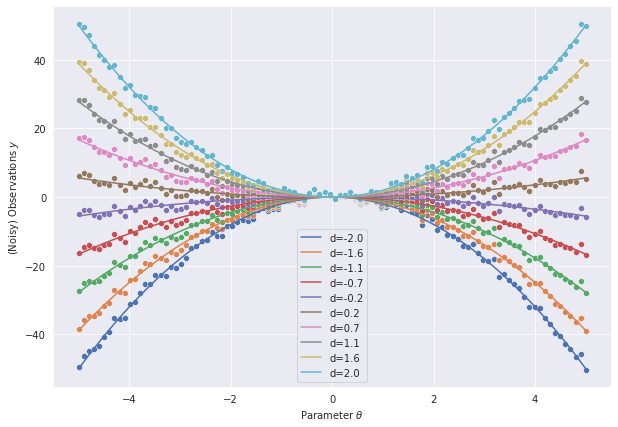

In [8]:
prngkey = jax.random.PRNGKey(42)
d_vals = jnp.linspace(-2, 2, 10) #, 1.5
noise_cov = 1*jnp.identity(ndim)
y, d = create_data(model_func, d_vals, noise_cov, prngkey)
fig = plot_data(y, d, model_func)
fig.show()

In [9]:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
noise_cov = jnp.identity(ndim)

Check things work with no $d$:

In [14]:
d_idx = 0
y_alone = y.reshape(-1,samples_per_d)[d_idx,:].reshape(-1,1)
model, model_grad = approx_post.models.from_jax(lambda theta, d: model_func(theta, 1.))
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)
prngkey = jax.random.PRNGKey(10)
approx_dist = approx_post.distributions.approx.Gaussian(ndim)
preprocessing = approx_post.distributions.amortised.Preprocessing.std_scaling(y_alone) #,d
phi_lims = None
amortised_dist = approx_post.distributions.amortised.NeuralNetwork(approx_dist, x_dim=1, prngkey=prngkey, 
                                                                   num_layers=3, width=10, activation='tanh', 
                                                                   preprocessing=preprocessing, phi_lims=phi_lims)

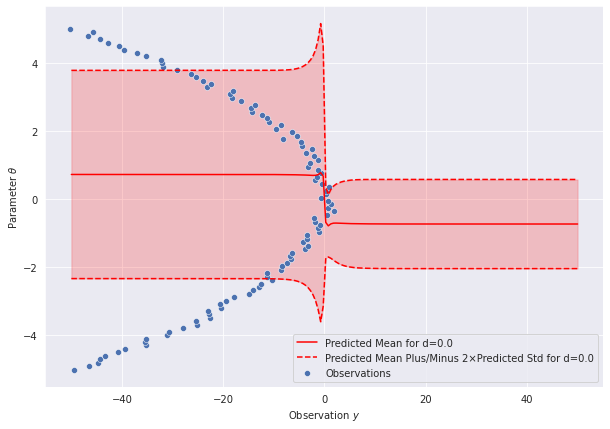

In [15]:
plot_phi_function(amortised_dist, y_obs=y_alone)

In [16]:
loss = approx_post.losses.ELBO(joint_dist, use_reparameterisation=True)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(amortised_dist, loss, x=y, prngkey=prngkey, verbose=True, num_samples=1000, max_iter=100) #d=d,

Loss = 128.5150909423828, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8152209 , -0.509059  ,  1.8475323 , -0.8378631 ,
              -2.0471652 ,  0.5254501 , -0.0938664 , -0.34642637,
               1.4270455 , -0.45711833]], dtype=float32), 'b_0': DeviceArray([-0.1       ,  0.1       , -0.1       ,  0.1       ,
             -0.1       ,  0.1       , -0.1       ,  0.10000001,
             -0.10000001,  0.1       ], dtype=float32), 'W_1': DeviceArray([[ 0.01059218,  0.14724535, -0.49323472, -0.4912987 ,
               0.6861102 , -0.63213646, -0.52255607,  0.4879025 ,
               0.46949065, -0.7133496 ],
             [ 0.11861829, -1.079063  , -0.24071357,  0.862651  ,
              -0.83058864, -0.26639324,  0.22558595,  0.23062214,
              -0.14766988,  0.7985727 ],
             [-0.24847469,  0.41080225,  0.12558243, -0.8550446 ,
              -0.09693774, -0.3967867 ,  0.13714892, -0.06730435,
               0.07136836, -0.22036953],
             [ 0.6121931 ,  0.04540924

KeyboardInterrupt: 

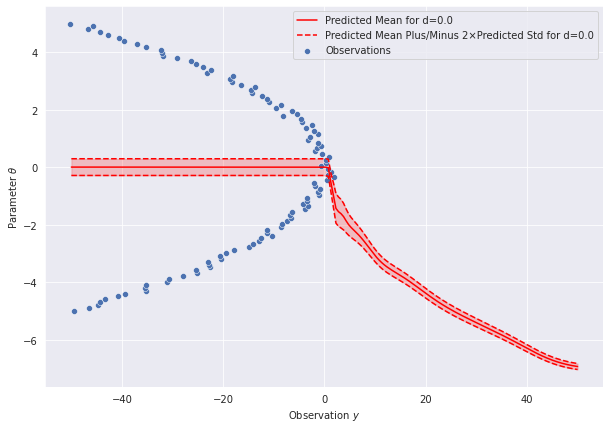

In [13]:
plot_phi_function(amortised_dist, y_obs=y_alone)

Now let's try include $d$:

In [28]:
model, model_grad = approx_post.models.from_jax(model_func)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)
prngkey = jax.random.PRNGKey(10)
approx_dist = approx_post.distributions.approx.Gaussian(1)
preprocessing = approx_post.distributions.amortised.Preprocessing.std_scaling(y, d) #,d
phi_lims = None # {'mean': {'lb': -50, 'ub': 50}}
amortised_dist = approx_post.distributions.amortised.NeuralNetwork(approx_dist, x_dim=1, d_dim=1, prngkey=prngkey, 
                                                                   num_layers=5, width=10, activation='tanh', 
                                                                   preprocessing=preprocessing, phi_lims=phi_lims)

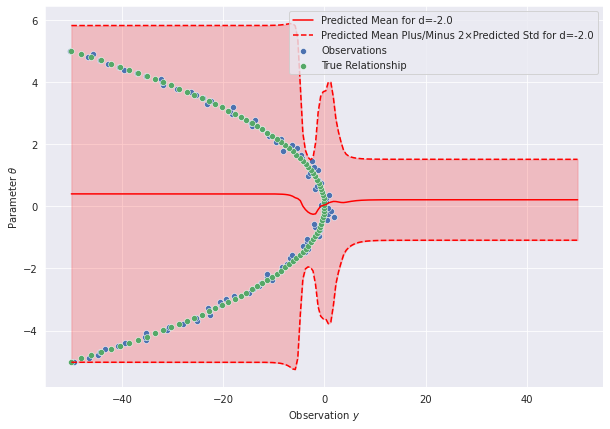

In [29]:
d_idx = 0
plot_phi_function(amortised_dist, d_idx, d=d, y_obs=y, model=model_func)

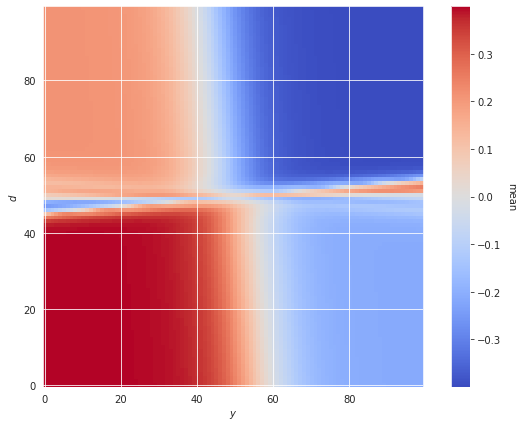

In [30]:
plot_phi_surface(amortised_dist, 'mean')

In [31]:
loss = approx_post.losses.ELBO(joint_dist, use_reparameterisation=True)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(amortised_dist, loss, x=y, d=d, prngkey=prngkey, verbose=True, num_samples=100, max_iter=200) 

Loss = 91.87319946289062, Params = Jaxtainer({'W_0': DeviceArray([[ 0.46915635, -0.09538334,  0.5206875 , -1.3245451 ,
               1.7359134 ,  1.1552569 ,  1.5268583 ,  0.39876086,
               1.1551124 ,  0.52448374],
             [-0.3258378 ,  1.3133421 , -0.5257412 , -0.8035197 ,
               1.0409783 ,  0.786783  , -0.90688205,  0.31471753,
               1.8556143 , -1.6147617 ]], dtype=float32), 'b_0': DeviceArray([-0.09999997,  0.1       , -0.10000001, -0.09999999,
             -0.1       ,  0.1       , -0.1       ,  0.1       ,
             -0.1       ,  0.10000001], dtype=float32), 'W_1': DeviceArray([[ 0.01059218,  0.14724535, -0.49323472, -0.4912987 ,
               0.48611018, -0.6321366 , -0.52255607,  0.4879025 ,
               0.46949065, -0.7133496 ],
             [-0.08138171, -0.87906307, -0.04071357,  0.66265094,
              -0.83058864, -0.46639323,  0.02558593,  0.03062213,
               0.05233011,  0.5985727 ],
             [-0.24847469,  0.41080225

Loss = 102.73250579833984, Params = Jaxtainer({'W_0': DeviceArray([[ 0.47245258, -0.02140508,  0.49757558, -1.3480703 ,
               1.758151  ,  1.1575003 ,  1.6219691 ,  0.49379116,
               1.1561565 ,  0.42811015],
             [-0.40293217,  1.3844594 , -0.58096045, -0.841181  ,
               1.0519805 ,  0.74955183, -0.8075095 ,  0.31343454,
               1.8914084 , -1.7141887 ]], dtype=float32), 'b_0': DeviceArray([-0.02907345,  0.18175578, -0.18541408, -0.0634774 ,
             -0.10486727,  0.13549931, -0.19873184,  0.16269939,
             -0.12414439,  0.09694458], dtype=float32), 'W_1': DeviceArray([[-0.05234399,  0.12125098, -0.403136  , -0.5254545 ,
               0.42214587, -0.6992567 , -0.6049174 ,  0.41838753,
               0.5366423 , -0.8070584 ],
             [-0.14844769, -0.7819367 ,  0.04914673,  0.6405087 ,
              -0.8965993 , -0.50700325, -0.0594291 , -0.03946024,
               0.12559175,  0.5009788 ],
             [-0.30957347,  0.3774824

Loss = 89.853515625, Params = Jaxtainer({'W_0': DeviceArray([[ 0.45948792,  0.04219475,  0.47737798, -1.3577074 ,
               1.7762519 ,  1.1574346 ,  1.6996232 ,  0.56182176,
               1.1521089 ,  0.35778278],
             [-0.47882658,  1.446373  , -0.6331619 , -0.876815  ,
               1.0596977 ,  0.7200714 , -0.7256013 ,  0.31473005,
               1.9222751 , -1.7887057 ]], dtype=float32), 'b_0': DeviceArray([ 0.05426212,  0.23950201, -0.24201363, -0.04148118,
             -0.10554309,  0.16324636, -0.279577  ,  0.21278295,
             -0.13603252,  0.09542766], dtype=float32), 'W_1': DeviceArray([[-1.00874312e-01,  6.15163334e-02, -3.32321882e-01,
              -5.52348018e-01,  3.71681750e-01, -7.53154874e-01,
              -6.67828083e-01,  3.64611179e-01,  5.87356389e-01,
              -8.41691256e-01],
             [-2.01020092e-01, -7.41966009e-01,  1.19287014e-01,
               6.24300957e-01, -9.48755622e-01, -5.39405644e-01,
              -1.22664593e-01, -

Loss = 64.42839050292969, Params = Jaxtainer({'W_0': DeviceArray([[ 0.4025231 ,  0.09452893,  0.4228606 , -1.3041828 ,
               1.7700927 ,  1.1608423 ,  1.7586386 ,  0.63288075,
               1.1045219 ,  0.29366732],
             [-0.5619475 ,  1.5003489 , -0.70368385, -0.9415429 ,
               1.0839423 ,  0.68534803, -0.65184456,  0.36241364,
               1.9810569 , -1.8584776 ]], dtype=float32), 'b_0': DeviceArray([ 0.12954904,  0.28423682, -0.21536824, -0.0875565 ,
             -0.08937046,  0.18716687, -0.3264758 ,  0.27403674,
             -0.11409815,  0.10786206], dtype=float32), 'W_1': DeviceArray([[-0.14045046,  0.00961477, -0.27675372, -0.5521805 ,
               0.33381388, -0.79692286, -0.7175222 ,  0.32401642,
               0.62810737, -0.8284728 ],
             [-0.24505427, -0.7154897 ,  0.17664233,  0.65961933,
              -0.99585724, -0.5637276 , -0.17049146, -0.14336379,
               0.22837856,  0.44536126],
             [-0.3948    ,  0.25737712

Loss = 43.1292724609375, Params = Jaxtainer({'W_0': DeviceArray([[ 0.33013955,  0.13904777,  0.35253367, -1.2378315 ,
               1.7324051 ,  1.1639107 ,  1.8191744 ,  0.6280581 ,
               1.0381335 ,  0.2196259 ],
             [-0.64987016,  1.5514787 , -0.7841433 , -1.0127026 ,
               1.1297729 ,  0.650904  , -0.5695063 ,  0.42984375,
               2.0529227 , -1.9385456 ]], dtype=float32), 'b_0': DeviceArray([ 0.21310015,  0.31657788, -0.16955404, -0.1500603 ,
             -0.0620061 ,  0.20824808, -0.3421692 ,  0.34901083,
             -0.1247237 ,  0.12675619], dtype=float32), 'W_1': DeviceArray([[-0.17193256, -0.02567642, -0.22500058, -0.50555676,
               0.31197977, -0.83100986, -0.7580202 ,  0.2990521 ,
               0.6617416 , -0.8301183 ],
             [-0.28437215, -0.7006315 ,  0.22784798,  0.7218016 ,
              -1.0430013 , -0.5878301 , -0.2117422 , -0.19568072,
               0.26793063,  0.44339386],
             [-0.4245336 ,  0.21896905,

Loss = 47.828857421875, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2799616 ,  0.17734662,  0.29728293, -1.1607891 ,
               1.6970892 ,  1.1515931 ,  1.8799264 ,  0.585527  ,
               0.97635144,  0.21807252],
             [-0.717051  ,  1.598185  , -0.8465768 , -1.0928028 ,
               1.169154  ,  0.6335564 , -0.48225847,  0.506999  ,
               2.1277013 , -1.979197  ]], dtype=float32), 'b_0': DeviceArray([ 0.28923354,  0.34270126, -0.12881532, -0.16857895,
             -0.06714925,  0.23648576, -0.34695512,  0.41525844,
             -0.16411044,  0.09607124], dtype=float32), 'W_1': DeviceArray([[-0.19664353, -0.05044947, -0.17877269, -0.4924063 ,
               0.29649124, -0.8571584 , -0.7922376 ,  0.2844201 ,
               0.69156843, -0.7833724 ],
             [-0.3214143 , -0.6943875 ,  0.26912057,  0.7556715 ,
              -1.0852969 , -0.61398906, -0.2485722 , -0.24819294,
               0.3010841 ,  0.49005094],
             [-0.4470719 ,  0.19089967, 

Loss = 27.84126853942871, Params = Jaxtainer({'W_0': DeviceArray([[ 0.22775078,  0.21078682,  0.23594898, -1.0787507 ,
               1.6399789 ,  1.1148114 ,  1.9218707 ,  0.52276254,
               0.9047304 ,  0.16995755],
             [-0.78339505,  1.6427131 , -0.9055457 , -1.1788039 ,
               1.2227776 ,  0.6316769 , -0.3964678 ,  0.5911858 ,
               2.209848  , -2.0406828 ]], dtype=float32), 'b_0': DeviceArray([ 0.3563741 ,  0.36127064, -0.0976465 , -0.14103577,
             -0.09364168,  0.26019847, -0.35480267,  0.4129918 ,
             -0.2049395 ,  0.04233851], dtype=float32), 'W_1': DeviceArray([[-0.21624498, -0.05833798, -0.13783385, -0.45218655,
               0.29071406, -0.87932426, -0.8225388 ,  0.27827927,
               0.7160458 , -0.75420374],
             [-0.35583588, -0.6975606 ,  0.3051244 ,  0.80707556,
              -1.1275316 , -0.6374163 , -0.28018445, -0.30083385,
               0.33108234,  0.5350708 ],
             [-0.46446642,  0.18008706

Loss = 27.312156677246094, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16763595,  0.24005537,  0.16288343, -0.9918455 ,
               1.5724791 ,  1.0562949 ,  1.9692019 ,  0.44882488,
               0.8244583 ,  0.1048375 ],
             [-0.8599206 ,  1.6818933 , -0.97735375, -1.2667886 ,
               1.2844837 ,  0.61463743, -0.32866827,  0.6712286 ,
               2.2975917 , -2.1138754 ]], dtype=float32), 'b_0': DeviceArray([ 0.43331397,  0.37348202, -0.05094015, -0.12066321,
             -0.11316145,  0.27881232, -0.36322573,  0.39629966,
             -0.21014406, -0.01297859], dtype=float32), 'W_1': DeviceArray([[-0.23574862, -0.05870024, -0.10435481, -0.40149847,
               0.28993207, -0.92083687, -0.85871774,  0.27685997,
               0.7376015 , -0.7182124 ],
             [-0.38127953, -0.70449674,  0.3409877 ,  0.86827826,
              -1.1681134 , -0.6182747 , -0.29610944, -0.35175   ,
               0.35719848,  0.52771974],
             [-0.48383906,  0.1773449

Loss = 61.743202209472656, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13479845,  0.26573536,  0.11775675, -0.9006357 ,
               1.4962394 ,  0.9921926 ,  2.0026326 ,  0.36707354,
               0.7383216 ,  0.14916696],
             [-0.9263286 ,  1.7214593 , -1.0376663 , -1.3580238 ,
               1.3505609 ,  0.60785997, -0.26504663,  0.75611377,
               2.3882387 , -2.0779784 ]], dtype=float32), 'b_0': DeviceArray([ 0.5020064 ,  0.37706682, -0.01111562, -0.07386335,
             -0.14719205,  0.28951505, -0.37526163,  0.34910974,
             -0.241176  , -0.01301089], dtype=float32), 'W_1': DeviceArray([[-0.25244868, -0.04866816, -0.07508564, -0.430199  ,
               0.29458046, -0.9574925 , -0.8911208 ,  0.2809315 ,
               0.75628823, -0.6608383 ],
             [-0.40448228, -0.71803325,  0.37303704,  0.85011995,
              -1.207092  , -0.6018728 , -0.31036967, -0.40155107,
               0.38065687,  0.5501195 ],
             [-0.50039005,  0.1846674

Loss = 29.0413818359375, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14323528,  0.28867215,  0.14271289, -0.8171836 ,
               1.4271216 ,  0.93215513,  2.0314    ,  0.2944942 ,
               0.6540091 ,  0.19628339],
             [-0.97555536,  1.7575097 , -1.0691948 , -1.4411813 ,
               1.4101077 ,  0.60330117, -0.20714223,  0.8336155 ,
               2.4755042 , -2.035042  ]], dtype=float32), 'b_0': DeviceArray([ 0.56934893,  0.3805948 ,  0.02610347, -0.0373024 ,
             -0.1750632 ,  0.3021824 , -0.3820459 ,  0.3082044 ,
             -0.2415716 , -0.0118431 ], dtype=float32), 'W_1': DeviceArray([[-0.26718876, -0.03943795, -0.04885877, -0.46335593,
               0.2988828 , -0.99048465, -0.9202853 ,  0.2848322 ,
               0.7731549 , -0.6019965 ],
             [-0.42540827, -0.73064107,  0.40175128,  0.8247494 ,
              -1.242517  , -0.5884565 , -0.3236481 , -0.4468199 ,
               0.40153518,  0.5776901 ],
             [-0.51494753,  0.19167408,

Loss = 20.680055618286133, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17662053,  0.30908182,  0.17386672, -0.73467857,
               1.3578192 ,  0.8675787 ,  2.0531156 ,  0.22585964,
               0.5645635 ,  0.23854055],
             [-1.0071149 ,  1.7928946 , -1.0893898 , -1.5208809 ,
               1.4669607 ,  0.6028047 , -0.1536517 ,  0.90810406,
               2.5665178 , -1.996266  ]], dtype=float32), 'b_0': DeviceArray([ 0.6392629 ,  0.38067567,  0.06925014, -0.00888913,
             -0.19858392,  0.32072064, -0.3860454 ,  0.26689243,
             -0.21530834,  0.00411092], dtype=float32), 'W_1': DeviceArray([[-0.2801973 , -0.02879076, -0.02544839, -0.4939109 ,
               0.30422935, -1.0196792 , -0.9464847 ,  0.28955352,
               0.78844655, -0.55225086],
             [-0.4445274 , -0.74339914,  0.42769727,  0.8023278 ,
              -1.2761261 , -0.5788314 , -0.33621162, -0.4893698 ,
               0.42025018,  0.6014478 ],
             [-0.5276353 ,  0.2005892

Loss = 25.5045108795166, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17317373,  0.32725272,  0.18290967, -0.6536215 ,
               1.2891959 ,  0.79781467,  2.0644689 ,  0.16209318,
               0.47084424,  0.27432913],
             [-1.0553203 ,  1.8272299 , -1.1205786 , -1.5967121 ,
               1.5200304 ,  0.60547197, -0.10466453,  0.97939235,
               2.6593454 , -1.9665527 ]], dtype=float32), 'b_0': DeviceArray([ 0.66121453,  0.3782534 ,  0.11024347,  0.01245004,
             -0.22100088,  0.34537572, -0.39495388,  0.2299987 ,
             -0.18251814,  0.04460597], dtype=float32), 'W_1': DeviceArray([[-0.29165182, -0.01748969, -0.00439987, -0.52172595,
               0.31055444, -1.0445694 , -0.9699573 ,  0.29474354,
               0.8024471 , -0.50486743],
             [-0.4625003 , -0.75569886,  0.45097548,  0.7859387 ,
              -1.3076822 , -0.56626457, -0.34552082, -0.5292091 ,
               0.43704122,  0.62367785],
             [-0.53838307,  0.21049796,

Loss = 24.571672439575195, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16233636,  0.34354973,  0.17287825, -0.5766487 ,
               1.2250872 ,  0.72503495,  2.0741286 ,  0.10543722,
               0.37581313,  0.3042797 ],
             [-1.1041098 ,  1.8590584 , -1.1620946 , -1.6670685 ,
               1.5690219 ,  0.6085375 , -0.06017537,  1.0458901 ,
               2.7480931 , -1.946774  ]], dtype=float32), 'b_0': DeviceArray([ 0.6780631 ,  0.37578493,  0.15393409,  0.02637785,
             -0.23880051,  0.36948806, -0.4020183 ,  0.20019615,
             -0.14770067,  0.08864853], dtype=float32), 'W_1': DeviceArray([[-0.30183014, -0.00684404,  0.0145276 , -0.54693365,
               0.3168217 , -1.0674334 , -0.99084735,  0.29974017,
               0.8150864 , -0.46122608],
             [-0.47884342, -0.7670634 ,  0.47201923,  0.774937  ,
              -1.3368754 , -0.55176747, -0.3536591 , -0.5659366 ,
               0.45218173,  0.6354895 ],
             [-0.547867  ,  0.2200365

Loss = 22.903427124023438, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14815326,  0.35771826,  0.14503141, -0.49765557,
               1.1628938 ,  0.6512363 ,  2.0824113 ,  0.04747348,
               0.27732033,  0.32866126],
             [-1.1478757 ,  1.8913207 , -1.2140706 , -1.7337762 ,
               1.6145891 ,  0.61135757, -0.02000546,  1.1093729 ,
               2.8346193 , -1.9373621 ]], dtype=float32), 'b_0': DeviceArray([ 0.6994876 ,  0.36565238,  0.18967059,  0.0487297 ,
             -0.2560758 ,  0.3891995 , -0.40797445,  0.16280319,
             -0.13999876,  0.11345224], dtype=float32), 'W_1': DeviceArray([[-0.31091797,  0.00568267,  0.0315293 , -0.56937647,
               0.32477564, -1.0885401 , -1.0093431 ,  0.30539542,
               0.8263185 , -0.42366767],
             [-0.49352032, -0.77766955,  0.49114951,  0.7690037 ,
              -1.3635519 , -0.53670454, -0.36165753, -0.5994319 ,
               0.46587327,  0.6378594 ],
             [-0.5563875 ,  0.2313688

Loss = 24.132896423339844, Params = Jaxtainer({'W_0': DeviceArray([[ 1.29901230e-01,  3.70545357e-01,  1.13078065e-01,
              -4.26069856e-01,  1.10581875e+00,  5.81115007e-01,
               2.08960891e+00,  3.48508358e-04,  1.85351849e-01,
               3.49948794e-01],
             [-1.18779254e+00,  1.92056727e+00, -1.26674557e+00,
              -1.79410899e+00,  1.65631926e+00,  6.12835765e-01,
               1.62509196e-02,  1.16753185e+00,  2.91252613e+00,
              -1.93130147e+00]], dtype=float32), 'b_0': DeviceArray([ 0.7206499 ,  0.35578716,  0.21820137,  0.06947216,
             -0.2715203 ,  0.40629026, -0.41309434,  0.12753645,
             -0.13781433,  0.1286329 ], dtype=float32), 'W_1': DeviceArray([[-3.19120646e-01,  1.69835724e-02,  4.68563102e-02,
              -5.89758992e-01,  3.32075208e-01, -1.10739982e+00,
              -1.02559912e+00,  3.10514480e-01,  8.36319149e-01,
              -3.89665961e-01],
             [-5.06698787e-01, -7.87233114e-01, 

Loss = 25.809337615966797, Params = Jaxtainer({'W_0': DeviceArray([[ 0.10660143,  0.38212115,  0.08081803, -0.3600584 ,
               1.0522143 ,  0.5142976 ,  2.095184  , -0.03726261,
               0.09624983,  0.36896333],
             [-1.2255226 ,  1.9473954 , -1.3173149 , -1.8490012 ,
               1.6947774 ,  0.6132158 ,  0.04905538,  1.22125   ,
               2.9839005 , -1.9267066 ]], dtype=float32), 'b_0': DeviceArray([ 0.738452  ,  0.34480488,  0.23810405,  0.09097811,
             -0.28656605,  0.41976553, -0.41792879,  0.09316888,
             -0.14814736,  0.13346645], dtype=float32), 'W_1': DeviceArray([[-0.3265231 ,  0.02773298,  0.06064164, -0.60821277,
               0.33918005, -1.1239324 , -1.03961   ,  0.31531748,
               0.845214  , -0.35922873],
             [-0.51854885, -0.79578996,  0.52439207,  0.76349396,
              -1.4093847 , -0.50908625, -0.37792975, -0.657136  ,
               0.4895868 ,  0.63549036],
             [-0.5711708 ,  0.2511311

Loss = 25.19948387145996, Params = Jaxtainer({'W_0': DeviceArray([[ 0.0719924 ,  0.39263088,  0.04761555, -0.30018544,
               1.0034281 ,  0.45071614,  2.10043   , -0.05264903,
               0.01290716,  0.385949  ],
             [-1.2644303 ,  1.9717891 , -1.366391  , -1.8987557 ,
               1.7297478 ,  0.61213654,  0.07843064,  1.2720455 ,
               3.0477567 , -1.9233431 ]], dtype=float32), 'b_0': DeviceArray([ 0.7514744 ,  0.33472   ,  0.25205556,  0.11028776,
             -0.29988766,  0.43092513, -0.4216323 ,  0.06172979,
             -0.16021141,  0.1324207 ], dtype=float32), 'W_1': DeviceArray([[-0.3332447 ,  0.03735609,  0.0730756 , -0.6257164 ,
               0.34560746, -1.1393218 , -1.0513307 ,  0.31963623,
               0.8532033 , -0.3314609 ],
             [-0.52925265, -0.80358154,  0.53883725,  0.7637557 ,
              -1.429079  , -0.49564338, -0.3864232 , -0.68200606,
               0.4997973 ,  0.63253254],
             [-0.5775761 ,  0.25972313

Loss = 22.37324333190918, Params = Jaxtainer({'W_0': DeviceArray([[ 0.03993752,  0.40210846,  0.01564844, -0.24415386,
               0.958248  ,  0.3882186 ,  2.104537  , -0.04607145,
              -0.07098264,  0.40120745],
             [-1.3026978 ,  1.9942788 , -1.4129511 , -1.9441354 ,
               1.7609713 ,  0.60899156,  0.1033331 ,  1.3216401 ,
               3.1057239 , -1.920745  ]], dtype=float32), 'b_0': DeviceArray([ 0.7598194 ,  0.32396692,  0.26150608,  0.13019913,
             -0.31406003,  0.43797448, -0.42594782,  0.02770066,
             -0.18247075,  0.1289635 ], dtype=float32), 'W_1': DeviceArray([[-0.33924478,  0.04658091,  0.08435567, -0.64390224,
               0.35194033, -1.1548611 , -1.0625011 ,  0.32370785,
               0.86042005, -0.30656412],
             [-0.5390823 , -0.81050026,  0.55194026,  0.7670042 ,
              -1.4467883 , -0.48154682, -0.39333403, -0.70452166,
               0.50896335,  0.62920123],
             [-0.5832514 ,  0.267865  

Loss = 22.48211669921875, Params = Jaxtainer({'W_0': DeviceArray([[ 0.08666493,  0.41075793,  0.01100812, -0.19374847,
               0.91902506,  0.3256111 ,  2.106102  , -0.09596124,
              -0.07970035,  0.4150733 ],
             [-1.2835037 ,  2.0148125 , -1.4489443 , -1.9852328 ,
               1.7870148 ,  0.60164446,  0.1204394 ,  1.3149872 ,
               3.160519  , -1.9183608 ]], dtype=float32), 'b_0': DeviceArray([ 0.7971093 ,  0.3145949 ,  0.2763498 ,  0.14764602,
             -0.3310588 ,  0.44119295, -0.4356701 , -0.02408864,
             -0.2025238 ,  0.12526697], dtype=float32), 'W_1': DeviceArray([[-3.4437111e-01,  5.4736931e-02,  9.4823547e-02,
              -6.5336955e-01,  3.5759759e-01, -1.1652844e+00,
              -1.0778935e+00,  3.2732853e-01,  8.6703467e-01,
              -2.8835034e-01],
             [-5.4852128e-01, -8.1688708e-01,  5.6364721e-01,
               7.5724924e-01, -1.4629242e+00, -4.7722378e-01,
              -3.9405772e-01, -7.2503203e-0

Loss = 19.481157302856445, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1809691e-01,  4.1848701e-01,  1.9878289e-03,
              -1.4351365e-01,  8.8322401e-01,  2.5760886e-01,
               2.1050360e+00, -1.2537910e-01, -1.0197153e-01,
               4.2655247e-01],
             [-1.2901111e+00,  2.0339680e+00, -1.4861203e+00,
              -2.0229247e+00,  1.8084389e+00,  5.8867514e-01,
               1.2976606e-01,  1.3329172e+00,  3.2092075e+00,
              -1.9195098e+00]], dtype=float32), 'b_0': DeviceArray([ 0.80879855,  0.30409467,  0.28280967,  0.16788447,
             -0.35175464,  0.4369899 , -0.45057827, -0.08597694,
             -0.23473378,  0.11901637], dtype=float32), 'W_1': DeviceArray([[-0.34866852,  0.06315742,  0.10456384, -0.6724419 ,
               0.36373737, -1.1807919 , -1.0988066 ,  0.3308966 ,
               0.8730821 , -0.27018607],
             [-0.5575641 , -0.8222231 ,  0.5740789 ,  0.7625525 ,
              -1.4771458 , -0.4645087 , -0.38690338, -0.

Loss = 22.31657600402832, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13268794,  0.42555156, -0.01072293, -0.09794182,
               0.8500854 ,  0.18281662,  2.1030073 , -0.13155158,
              -0.13470736,  0.4357307 ],
             [-1.3208916 ,  2.0516167 , -1.5243567 , -2.0572073 ,
               1.8272096 ,  0.57210904,  0.13613896,  1.3759067 ,
               3.249848  , -1.9243344 ]], dtype=float32), 'b_0': DeviceArray([ 0.7994918 ,  0.29458404,  0.28140733,  0.1860851 ,
             -0.37288252,  0.42975277, -0.46585935, -0.15536204,
             -0.2692389 ,  0.103318  ], dtype=float32), 'W_1': DeviceArray([[-0.35244825,  0.07077629,  0.11348981, -0.6985185 ,
               0.36933425, -1.1992388 , -1.1197096 ,  0.3340768 ,
               0.87851334, -0.25096777],
             [-0.56592035, -0.8271299 ,  0.58353996,  0.78182995,
              -1.4900924 , -0.4438374 , -0.3776992 , -0.7603778 ,
               0.53067964,  0.62365746],
             [-0.59488875,  0.28900054

Loss = 21.419418334960938, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12729315,  0.43199828, -0.02642626, -0.05646214,
               0.818002  ,  0.10457441,  2.1011038 , -0.11433287,
              -0.1801047 ,  0.44347143],
             [-1.3717366 ,  2.0679266 , -1.5628396 , -2.0885642 ,
               1.8448981 ,  0.5552082 ,  0.14190002,  1.4372009 ,
               3.2822127 , -1.9306352 ]], dtype=float32), 'b_0': DeviceArray([ 0.774754  ,  0.28646675,  0.27062455,  0.20172082,
             -0.39186573,  0.42005232, -0.4785711 , -0.21422863,
             -0.30664176,  0.07317616], dtype=float32), 'W_1': DeviceArray([[-0.3558401 ,  0.07775318,  0.12161573, -0.7246799 ,
               0.3744472 , -1.2163178 , -1.1376307 ,  0.33691123,
               0.88328695, -0.23219085],
             [-0.5735697 , -0.83161366,  0.59222734,  0.8105564 ,
              -1.5018772 , -0.41698885, -0.37018645, -0.77581024,
               0.5365365 ,  0.6161235 ],
             [-0.5977555 ,  0.2950545

Loss = 17.412763595581055, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12265356,  0.4378889 , -0.04200258, -0.01865111,
               0.7863087 ,  0.07489678,  2.0990353 , -0.10198111,
              -0.2465139 ,  0.45066383],
             [-1.4179496 ,  2.0830503 , -1.5989193 , -2.117406  ,
               1.8622435 ,  0.5429039 ,  0.14757924,  1.4907907 ,
               3.304855  , -1.9358858 ]], dtype=float32), 'b_0': DeviceArray([ 0.7298021 ,  0.27994138,  0.25319418,  0.21370617,
             -0.40724906,  0.40542924, -0.48776445, -0.19668475,
             -0.3539317 ,  0.04290482], dtype=float32), 'W_1': DeviceArray([[-0.3589067 ,  0.08471781,  0.1289736 , -0.7396476 ,
               0.3790927 , -1.2256819 , -1.1527466 ,  0.3395379 ,
               0.8872322 , -0.21863009],
             [-0.5807236 , -0.8353664 ,  0.6001662 ,  0.8330153 ,
              -1.512661  , -0.39237   , -0.36446744, -0.78985286,
               0.54193705,  0.6133696 ],
             [-0.6002436 ,  0.3000371

Loss = 19.75645637512207, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14739493,  0.4432572 , -0.05393358,  0.01967932,
               0.7542682 ,  0.10741226,  2.096231  , -0.12542436,
              -0.20044711,  0.45739084],
             [-1.42546   ,  2.0970554 , -1.6307945 , -2.1438131 ,
               1.879879  ,  0.53916854,  0.15356004,  1.505812  ,
               3.36154   , -1.9401463 ]], dtype=float32), 'b_0': DeviceArray([ 0.6751841 ,  0.2747125 ,  0.23430271,  0.22203192,
             -0.41815776,  0.38435528, -0.49292654, -0.1599098 ,
             -0.42168108,  0.01590545], dtype=float32), 'W_1': DeviceArray([[-0.3614681 ,  0.10065016,  0.13486443, -0.7510398 ,
               0.3873369 , -1.2376817 , -1.165895  ,  0.34474725,
               0.8871474 , -0.21653627],
             [-0.5874411 , -0.83200324,  0.60684335,  0.8375173 ,
              -1.5199122 , -0.38331363, -0.36006567, -0.7999435 ,
               0.5450278 ,  0.61600214],
             [-0.602381  ,  0.29458767

Loss = 15.713762283325195, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16853237,  0.44815752, -0.06479865,  0.07858275,
               0.7202908 ,  0.14089268,  2.090362  , -0.14679883,
              -0.18333702,  0.463733  ],
             [-1.4316293 ,  2.1101031 , -1.6596484 , -2.1669242 ,
               1.899402  ,  0.535907  ,  0.16206232,  1.5196861 ,
               3.3984613 , -1.9433099 ]], dtype=float32), 'b_0': DeviceArray([ 0.6303101 ,  0.2707448 ,  0.21746926,  0.22955568,
             -0.42235106,  0.36376226, -0.49126655, -0.13125497,
             -0.48802066, -0.00600734], dtype=float32), 'W_1': DeviceArray([[-0.3629393 ,  0.13037089,  0.13899802, -0.76195693,
               0.4028702 , -1.2550086 , -1.1782867 ,  0.35525927,
               0.88134354, -0.2250015 ],
             [-0.5942783 , -0.81765157,  0.6120583 ,  0.83856857,
              -1.5213089 , -0.38125795, -0.355797  , -0.8035637 ,
               0.5461746 ,  0.616062  ],
             [-0.6036616 ,  0.2736055

Loss = 25.858619689941406, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17552042,  0.4526418 , -0.07598031,  0.13439669,
               0.6839135 ,  0.1679834 ,  2.0788226 , -0.1473737 ,
              -0.12714054,  0.46965805],
             [-1.4499004 ,  2.122377  , -1.686332  , -2.1374712 ,
               1.9218135 ,  0.53074527,  0.17614292,  1.5492985 ,
               3.4600992 , -1.9456095 ]], dtype=float32), 'b_0': DeviceArray([ 0.60243744,  0.2683621 ,  0.20270742,  0.2673391 ,
             -0.41807076,  0.34535116, -0.47899872, -0.11141133,
             -0.44782335, -0.02258465], dtype=float32), 'W_1': DeviceArray([[-3.6247790e-01,  1.8025941e-01,  1.4645697e-01,
              -7.6823241e-01,  4.2512727e-01, -1.2577380e+00,
              -1.1901702e+00,  3.6542496e-01,  8.9012200e-01,
              -2.1772698e-01],
             [-6.0165220e-01, -7.8569299e-01,  6.1926430e-01,
               8.4690964e-01, -1.5175742e+00, -3.6601371e-01,
              -3.5041985e-01, -8.0652201e-

Loss = 23.0797119140625, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17184629,  0.45673501, -0.08710632,  0.15393645,
               0.64491045,  0.18991894,  2.0599904 , -0.13442297,
              -0.05942848,  0.47511378],
             [-1.4772336 ,  2.1339147 , -1.710894  , -2.138877  ,
               1.9470173 ,  0.5244369 ,  0.19750756,  1.589121  ,
               3.530464  , -1.9474012 ]], dtype=float32), 'b_0': DeviceArray([ 0.5886935 ,  0.26700807,  0.18950537,  0.2537638 ,
             -0.40707645,  0.3283238 , -0.45698357, -0.10380605,
             -0.38241738, -0.035324  ], dtype=float32), 'W_1': DeviceArray([[-0.3787727 ,  0.18870488,  0.16509515, -0.7713008 ,
               0.38706866, -1.2495238 , -1.1994677 ,  0.34524196,
               0.8954046 , -0.18505123],
             [-0.62704396, -0.7840142 ,  0.633946  ,  0.86061627,
              -1.5573928 , -0.34119207, -0.34299538, -0.83630764,
               0.5764102 ,  0.6556279 ],
             [-0.5832025 ,  0.22739154,

Loss = 18.432525634765625, Params = Jaxtainer({'W_0': DeviceArray([[ 1.62921458e-01,  4.60381806e-01, -9.74116474e-02,
               1.71546072e-01,  6.00133479e-01,  2.08924145e-01,
               2.03415775e+00, -1.20356604e-01,  2.17122212e-03,
               4.80132967e-01],
             [-1.50755417e+00,  2.14538717e+00, -1.73320723e+00,
              -2.14136028e+00,  1.97531831e+00,  5.18516779e-01,
               2.23704636e-01,  1.62930417e+00,  3.59486628e+00,
              -1.94877338e+00]], dtype=float32), 'b_0': DeviceArray([ 0.58261675,  0.27025375,  0.17810173,  0.23765233,
             -0.38436177,  0.3148381 , -0.4273929 , -0.11101664,
             -0.32057533, -0.04538467], dtype=float32), 'W_1': DeviceArray([[-0.3873487 ,  0.20564306,  0.17560011, -0.7768079 ,
               0.35424045, -1.258195  , -1.209248  ,  0.32447046,
               0.89753264, -0.16403398],
             [-0.6470952 , -0.7749832 ,  0.6428703 ,  0.87223697,
              -1.5922995 , -0.331204

Loss = 14.288121223449707, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15840927,  0.46360865, -0.10701992,  0.18793675,
               0.55003333,  0.22612144,  2.006336  , -0.11364781,
               0.05826388,  0.48484647],
             [-1.5309235 ,  2.156669  , -1.7535108 , -2.143367  ,
               2.0053475 ,  0.513504  ,  0.2500622 ,  1.6613381 ,
               3.6537886 , -1.9494317 ]], dtype=float32), 'b_0': DeviceArray([ 0.5703255 ,  0.27668905,  0.16690841,  0.21785352,
             -0.35380906,  0.30412918, -0.39637682, -0.11455021,
             -0.2626643 , -0.05384597], dtype=float32), 'W_1': DeviceArray([[-0.39306942,  0.22654265,  0.181204  , -0.7833471 ,
               0.32460156, -1.2750508 , -1.2187157 ,  0.3032343 ,
               0.8982636 , -0.149731  ],
             [-0.6646826 , -0.7623626 ,  0.6482375 ,  0.87864465,
              -1.62403   , -0.33124593, -0.33109114, -0.8955367 ,
               0.608818  ,  0.6963788 ],
             [-0.5547535 ,  0.1991253

Loss = 13.525313377380371, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15874717,  0.46640542, -0.11652356,  0.203388  ,
               0.49400234,  0.24134976,  1.9783376 , -0.10277442,
               0.10931962,  0.48930854],
             [-1.5477372 ,  2.1679657 , -1.7722986 , -2.1448705 ,
               2.0365639 ,  0.50964284,  0.27499324,  1.6947402 ,
               3.707772  , -1.9492482 ]], dtype=float32), 'b_0': DeviceArray([ 0.5410467 ,  0.28711113,  0.15385382,  0.18836796,
             -0.31561306,  0.29637405, -0.365828  , -0.0913115 ,
             -0.20798126, -0.0625061 ], dtype=float32), 'W_1': DeviceArray([[-0.39763322,  0.24653839,  0.18596159, -0.7846972 ,
               0.2976206 , -1.2878022 , -1.2274203 ,  0.28369707,
               0.8983379 , -0.13988759],
             [-0.68077844, -0.750337  ,  0.6528981 ,  0.88429976,
              -1.6531103 , -0.33158264, -0.32588756, -0.92280686,
               0.6238217 ,  0.71611255],
             [-0.5427083 ,  0.1834941

Loss = 13.881548881530762, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15304033,  0.46877423, -0.1264132 ,  0.2159544 ,
               0.43334043,  0.25344047,  1.9512348 , -0.07358597,
               0.15577301,  0.49344465],
             [-1.5705155 ,  2.1792312 , -1.7900331 , -2.1500192 ,
               2.0679572 ,  0.5067234 ,  0.298181  ,  1.7408398 ,
               3.757232  , -1.9484929 ]], dtype=float32), 'b_0': DeviceArray([ 0.49705032,  0.30076605,  0.1382004 ,  0.1495401 ,
             -0.27309078,  0.29157   , -0.33708754, -0.04380256,
             -0.15650052, -0.0741791 ], dtype=float32), 'W_1': DeviceArray([[-0.40154728,  0.2636136 ,  0.19111544, -0.77767134,
               0.27311915, -1.2917823 , -1.2352207 ,  0.26610425,
               0.8979701 , -0.13306116],
             [-0.6956217 , -0.7405067 ,  0.6577298 ,  0.8973239 ,
              -1.679719  , -0.3256319 , -0.32104567, -0.94762284,
               0.6377402 ,  0.73425984],
             [-0.5315045 ,  0.1705845

Loss = 11.756656646728516, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14317328,  0.4706707 , -0.13637984,  0.22588651,
               0.36832598,  0.25974762,  1.9256101 , -0.06627955,
               0.19801217,  0.4970355 ],
             [-1.5979289 ,  2.1904404 , -1.8066896 , -2.1586342 ,
               2.0987008 ,  0.503882  ,  0.3194647 ,  1.7737523 ,
               3.8025877 , -1.9481457 ]], dtype=float32), 'b_0': DeviceArray([ 4.4727606e-01,  3.1724977e-01,  1.2128849e-01,
              1.0769163e-01, -2.2964177e-01,  2.9168534e-01,
             -3.1106889e-01,  1.1257455e-04, -1.0804635e-01,
             -8.5532956e-02], dtype=float32), 'W_1': DeviceArray([[-4.0494451e-01,  2.8011975e-01,  1.9540466e-01,
              -7.7440250e-01,  2.5088760e-01, -1.2987152e+00,
              -1.2427695e+00,  2.5000197e-01,  8.9730793e-01,
              -1.2601937e-01],
             [-7.0912361e-01, -7.3065495e-01,  6.6184670e-01,
               9.1087383e-01, -1.7040905e+00, -3.2093227e-01,

Loss = 12.641969680786133, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1382424 ,  0.4721699 , -0.14601044,  0.23488353,
               0.30068862,  0.26105887,  1.9012979 , -0.09474908,
               0.23642004,  0.5002135 ],
             [-1.6205814 ,  2.2013803 , -1.8221304 , -2.1671138 ,
               2.128279  ,  0.5009578 ,  0.33889532,  1.7803836 ,
               3.8441517 , -1.9479606 ]], dtype=float32), 'b_0': DeviceArray([ 0.400462  ,  0.33487728,  0.10515143,  0.06976189,
             -0.18805179,  0.2965249 , -0.2876173 ,  0.03069639,
             -0.06291416, -0.09187334], dtype=float32), 'W_1': DeviceArray([[-4.0798318e-01,  2.9624629e-01,  1.9884852e-01,
              -7.8423083e-01,  2.3075148e-01, -1.3130934e+00,
              -1.2501661e+00,  2.3526922e-01,  8.9644086e-01,
              -1.1841032e-01],
             [-7.2142076e-01, -7.2059637e-01,  6.6526139e-01,
               9.1404188e-01, -1.7263865e+00, -3.2246876e-01,
              -3.1079623e-01, -9.9141574e-

Loss = 9.355911254882812, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13182165,  0.47349143, -0.15551536,  0.24313962,
               0.23684129,  0.2602668 ,  1.8780172 , -0.10538003,
               0.27138516,  0.50315946],
             [-1.642088  ,  2.2115467 , -1.8365164 , -2.1747658 ,
               2.1560721 ,  0.49786705,  0.35666704,  1.7975386 ,
               3.8820896 , -1.9473616 ]], dtype=float32), 'b_0': DeviceArray([ 0.3623051 ,  0.34998846,  0.08997974,  0.03862929,
             -0.15225643,  0.30219015, -0.2661707 ,  0.06739873,
             -0.02210843, -0.09507555], dtype=float32), 'W_1': DeviceArray([[-4.1066417e-01,  3.0951571e-01,  2.0253183e-01,
              -7.9028022e-01,  2.1253666e-01, -1.3231854e+00,
              -1.2570987e+00,  2.2189473e-01,  8.9539856e-01,
              -1.1120399e-01],
             [-7.3257047e-01, -7.1243888e-01,  6.6873002e-01,
               9.2114860e-01, -1.7466464e+00, -3.2005000e-01,
              -3.0596682e-01, -1.0104426e+0

Loss = 11.879168510437012, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13086694,  0.4746714 , -0.16482492,  0.25304428,
               0.1769898 ,  0.26002175,  1.8555325 , -0.09609107,
               0.30321825,  0.5060845 ],
             [-1.6534078 ,  2.2210965 , -1.8498553 , -2.1765208 ,
               2.1822362 ,  0.49542636,  0.37290782,  1.8257895 ,
               3.9167242 , -1.9457606 ]], dtype=float32), 'b_0': DeviceArray([ 0.32984537,  0.36348563,  0.07661832,  0.00887725,
             -0.11933322,  0.3079885 , -0.24639176,  0.11514302,
              0.0151787 , -0.09827978], dtype=float32), 'W_1': DeviceArray([[-0.4130456 ,  0.3192129 ,  0.2068211 , -0.78688204,
               0.19603378, -1.3248168 , -1.2619618 ,  0.20973954,
               0.89420295, -0.10781872],
             [-0.7428398 , -0.7079493 ,  0.672591  ,  0.9271819 ,
              -1.7651125 , -0.31533894, -0.30323988, -1.0277288 ,
               0.6817892 ,  0.7811974 ],
             [-0.49494952,  0.1279353

Loss = 11.365828514099121, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12401514,  0.47577763, -0.17400816,  0.2611318 ,
               0.12406598,  0.2554105 ,  1.8338145 , -0.07344333,
               0.33220533,  0.5083178 ],
             [-1.6684891 ,  2.2297964 , -1.8623635 , -2.1806061 ,
               2.2068155 ,  0.4910699 ,  0.3877803 ,  1.8626738 ,
               3.9483016 , -1.9458147 ]], dtype=float32), 'b_0': DeviceArray([ 0.315168  ,  0.37315252,  0.06539654, -0.01190101,
             -0.09339882,  0.31448853, -0.22850274,  0.15429434,
              0.04821937, -0.09579583], dtype=float32), 'W_1': DeviceArray([[-0.41521475,  0.32634208,  0.2111591 , -0.78418314,
               0.18111432, -1.3254471 , -1.268316  ,  0.19864382,
               0.8929221 , -0.10038505],
             [-0.75210404, -0.7046077 ,  0.6763759 ,  0.93857837,
              -1.7818223 , -0.30664712, -0.298941  , -1.0434456 ,
               0.69028467,  0.7893233 ],
             [-0.48755932,  0.1233178

Loss = 14.258557319641113, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14090551,  0.47677267, -0.18279488,  0.26956227,
               0.07220022,  0.25115353,  1.8128638 , -0.08546145,
               0.35855973,  0.51043415],
             [-1.662813  ,  2.2378814 , -1.8739455 , -2.1822124 ,
               2.2301393 ,  0.48693132,  0.4014286 ,  1.8713201 ,
               3.9771783 , -1.945404  ]], dtype=float32), 'b_0': DeviceArray([ 0.3095519 ,  0.3795421 ,  0.05651312, -0.03087007,
             -0.07347852,  0.3187036 , -0.21218014,  0.1564339 ,
              0.07716154, -0.09484796], dtype=float32), 'W_1': DeviceArray([[-4.17145520e-01,  3.33711803e-01,  2.14956403e-01,
              -7.93220103e-01,  1.67725429e-01, -1.33486271e+00,
              -1.27318871e+00,  1.88568860e-01,  8.91544282e-01,
              -9.42694843e-02],
             [-7.60641396e-01, -7.01544106e-01,  6.79737389e-01,
               9.31147993e-01, -1.79687786e+00, -3.11105669e-01,
              -2.96480179e

Loss = 14.0802583694458, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13797496,  0.477616  , -0.19163564,  0.27548507,
               0.02363409,  0.2377866 ,  1.7922769 , -0.08397655,
               0.3824954 ,  0.51150537],
             [-1.6741185 ,  2.2454574 , -1.8849237 , -2.1882813 ,
               2.2529783 ,  0.47944775,  0.41422096,  1.890825  ,
               4.0036454 , -1.9482774 ]], dtype=float32), 'b_0': DeviceArray([ 0.30928212,  0.38390893,  0.04929961, -0.04299064,
             -0.05789743,  0.3264932 , -0.19704983,  0.15698604,
              0.10248154, -0.0855111 ], dtype=float32), 'W_1': DeviceArray([[-4.1877282e-01,  3.3987951e-01,  2.1854487e-01,
              -7.9821187e-01,  1.5574957e-01, -1.3411191e+00,
              -1.2814610e+00,  1.7944196e-01,  8.9007127e-01,
              -8.2514390e-02],
             [-7.6822853e-01, -6.9826359e-01,  6.8281412e-01,
               9.3650550e-01, -1.8104379e+00, -3.0753818e-01,
              -2.9015499e-01, -1.0705785e+00

Loss = 9.180816650390625, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1365667 ,  0.47834206, -0.20029029,  0.28198928,
              -0.02454191,  0.22604391,  1.7727278 , -0.08150876,
               0.40421924,  0.51266646],
             [-1.6810443 ,  2.2525795 , -1.8951911 , -2.191146  ,
               2.2748163 ,  0.47318342,  0.42597097,  1.9099934 ,
               4.0279055 , -1.9499836 ]], dtype=float32), 'b_0': DeviceArray([ 0.30372298,  0.38687482,  0.04322219, -0.05672196,
             -0.04492887,  0.33267358, -0.18314432,  0.15312603,
              0.1246566 , -0.07800981], dtype=float32), 'W_1': DeviceArray([[-0.42009723,  0.34630919,  0.22173317, -0.7982941 ,
               0.14498469, -1.3443587 , -1.2875606 ,  0.17120624,
               0.888542  , -0.07413963],
             [-0.7751095 , -0.69519234,  0.6855608 ,  0.94057435,
              -1.8226861 , -0.30487135, -0.2857923 , -1.0822146 ,
               0.7111682 ,  0.80528337],
             [-0.46859014,  0.11214956

Loss = 10.216256141662598, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1464592 ,  0.47892922, -0.20864826,  0.28934795,
              -0.08858827,  0.21611911,  1.75455   , -0.09137649,
               0.42389783,  0.51398766],
             [-1.6754102 ,  2.2593167 , -1.9047623 , -2.1903775 ,
               2.2950737 ,  0.46840736,  0.4366872 ,  1.9182653 ,
               4.0502033 , -1.9503784 ]], dtype=float32), 'b_0': DeviceArray([ 0.28514147,  0.3884529 ,  0.0378934 , -0.07241259,
             -0.03566295,  0.33724868, -0.17057481,  0.14600089,
              0.14348623, -0.07117984], dtype=float32), 'W_1': DeviceArray([[-0.4211037 ,  0.354276  ,  0.22432747, -0.79729307,
               0.13532242, -1.3473755 , -1.290567  ,  0.16387463,
               0.8869947 , -0.06944478],
             [-0.7813417 , -0.69147927,  0.6878702 ,  0.93696856,
              -1.8337305 , -0.30753273, -0.28452247, -1.0926241 ,
               0.71689266,  0.8110788 ],
             [-0.4632773 ,  0.1088298

Loss = 11.964982986450195, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14264205,  0.47936997, -0.21681736,  0.29428568,
              -0.04008247,  0.19796516,  1.7376491 , -0.08743713,
               0.44171765,  0.51461405],
             [-1.6839037 ,  2.2656271 , -1.9138007 , -2.1943204 ,
               2.32437   ,  0.46138725,  0.44645876,  1.9371846 ,
               4.070698  , -1.9528179 ]], dtype=float32), 'b_0': DeviceArray([ 0.25914055,  0.3893197 ,  0.03293306, -0.08653908,
             -0.02192431,  0.34442675, -0.15952596,  0.14766735,
              0.15940931, -0.06261405], dtype=float32), 'W_1': DeviceArray([[-0.42191887,  0.36075008,  0.22719479, -0.79193   ,
               0.12663344, -1.3471144 , -1.2976347 ,  0.1573741 ,
               0.88546646, -0.06132185],
             [-0.78684515, -0.68808204,  0.6902307 ,  0.9441295 ,
              -1.8437039 , -0.30354542, -0.27791908, -1.1019073 ,
               0.7220371 ,  0.8123867 ],
             [-0.45851398,  0.1065026

Loss = 9.47607421875, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13887581,  0.47978354, -0.22460926,  0.29817238,
              -0.00902065,  0.17701054,  1.7221451 , -0.10047355,
               0.45793062,  0.5150969 ],
             [-1.6931998 ,  2.2713432 , -1.9222475 , -2.1995296 ,
               2.349587  ,  0.45394924,  0.45522448,  1.9420962 ,
               4.0893435 , -1.9552194 ]], dtype=float32), 'b_0': DeviceArray([ 0.2299504 ,  0.3902451 ,  0.02859383, -0.09801065,
             -0.01126828,  0.3541358 , -0.15024036,  0.14446957,
              0.1738663 , -0.05116754], dtype=float32), 'W_1': DeviceArray([[-0.4225918 ,  0.3690451 ,  0.22934718, -0.7934325 ,
               0.11870275, -1.3515103 , -1.3051661 ,  0.151393  ,
               0.884008  , -0.05317777],
             [-0.79177254, -0.6825362 ,  0.69201386,  0.94761926,
              -1.8527952 , -0.30246055, -0.27054864, -1.1103945 ,
               0.7266789 ,  0.8123648 ],
             [-0.45424953,  0.10142145,  0

Loss = 10.363847732543945, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14910685,  0.48018354, -0.23194733,  0.3026745 ,
               0.01593227,  0.16176715,  1.707995  , -0.12352847,
               0.47268325,  0.5158089 ],
             [-1.6879086 ,  2.2765534 , -1.9300716 , -2.2018428 ,
               2.372008  ,  0.44926015,  0.46297622,  1.9362776 ,
               4.106299  , -1.9563038 ]], dtype=float32), 'b_0': DeviceArray([ 0.2039357 ,  0.39066204,  0.0250088 , -0.10752001,
             -0.00336338,  0.36383227, -0.14264025,  0.1396844 ,
              0.18679072, -0.03946247], dtype=float32), 'W_1': DeviceArray([[-0.42312428,  0.37859222,  0.23101024, -0.79712915,
               0.11149391, -1.3579471 , -1.3069077 ,  0.14592406,
               0.8826203 , -0.04831244],
             [-0.7963088 , -0.67608905,  0.6934919 ,  0.94299734,
              -1.8610547 , -0.3067952 , -0.2697864 , -1.1181321 ,
               0.7309035 ,  0.81463176],
             [-0.45028633,  0.0950833

Loss = 9.79581356048584, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15545927,  0.4805502 , -0.23888972,  0.30693147,
               0.03908623,  0.14963984,  1.6947657 , -0.13073702,
               0.48609784,  0.5166779 ],
             [-1.6844234 ,  2.281357  , -1.9373438 , -2.2034938 ,
               2.392601  ,  0.4464779 ,  0.4698646 ,  1.9440446 ,
               4.121744  , -1.9562998 ]], dtype=float32), 'b_0': DeviceArray([ 0.18046291,  0.3903993 ,  0.02209948, -0.11470006,
              0.00179174,  0.37358788, -0.13677616,  0.14673619,
              0.1981722 , -0.02610663], dtype=float32), 'W_1': DeviceArray([[-0.42365143,  0.38313353,  0.2330958 , -0.79481953,
               0.10498258, -1.3587205 , -1.306199  ,  0.14095971,
               0.881313  , -0.04507498],
             [-0.8005059 , -0.67395425,  0.69526726,  0.94329786,
              -1.8685343 , -0.3063523 , -0.27114245, -1.1251545 ,
               0.7347274 ,  0.81781214],
             [-0.44656456,  0.09394334,

Loss = 9.794418334960938, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15576953,  0.48085475, -0.2454687 ,  0.3104034 ,
               0.06021715,  0.13552356,  1.6819632 , -0.12563571,
               0.49828178,  0.51741505],
             [-1.6860406 ,  2.2858684 , -1.9441115 , -2.2061446 ,
               2.4117513 ,  0.44365564,  0.47609186,  1.9630351 ,
               4.1358585 , -1.9563683 ]], dtype=float32), 'b_0': DeviceArray([ 0.15989411,  0.38936448,  0.01988719, -0.11926807,
              0.00431567,  0.3835613 , -0.13256252,  0.15974875,
              0.20802765, -0.01247422], dtype=float32), 'W_1': DeviceArray([[-0.42414862,  0.38323703,  0.23551802, -0.7883385 ,
               0.09915632, -1.355269  , -1.3059453 ,  0.13647719,
               0.8800652 , -0.04164762],
             [-0.80436045, -0.67551994,  0.69725055,  0.94899035,
              -1.8752838 , -0.30133265, -0.27154154, -1.131508  ,
               0.73818654,  0.8202676 ],
             [-0.44308728,  0.09729441

Loss = 8.917536735534668, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15572672,  0.4810747 , -0.2516556 ,  0.31334788,
               0.07876006,  0.11863762,  1.669248  , -0.11916603,
               0.5093336 ,  0.51797444],
             [-1.687918  ,  2.2901893 , -1.9503847 , -2.2093425 ,
               2.4297087 ,  0.44047344,  0.48182267,  1.982265  ,
               4.1488037 , -1.9567461 ]], dtype=float32), 'b_0': DeviceArray([ 0.14371614,  0.3874586 ,  0.01834119, -0.12143531,
              0.00465162,  0.393181  , -0.12974878,  0.1656399 ,
              0.21637212,  0.00045498], dtype=float32), 'W_1': DeviceArray([[-4.2452022e-01,  3.8258827e-01,  2.3777382e-01,
              -7.8225392e-01,  9.3994431e-02, -1.3523085e+00,
              -1.3066086e+00,  1.3245271e-01,  8.7885094e-01,
              -3.7956562e-02],
             [-8.0783623e-01, -6.7750770e-01,  6.9906843e-01,
               9.5503664e-01, -1.8813525e+00, -2.9657468e-01,
              -2.7098036e-01, -1.1372403e+0

Loss = 9.983169555664062, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15986174,  0.48120627, -0.25744435,  0.31606746,
               0.09473247,  0.1003541 ,  1.6564962 , -0.12841867,
               0.5193491 ,  0.5184426 ],
             [-1.686031  ,  2.2943714 , -1.956181  , -2.2123895 ,
               2.4466634 ,  0.4376168 ,  0.48715892,  1.9867563 ,
               4.160704  , -1.9571153 ]], dtype=float32), 'b_0': DeviceArray([ 0.13069381,  0.38471153,  0.01741853, -0.12190756,
              0.00328271,  0.4015263 , -0.1280396 ,  0.15186377,
              0.22330453,  0.01245625], dtype=float32), 'W_1': DeviceArray([[-0.4245321 ,  0.3914043 ,  0.2384301 , -0.78474224,
               0.08944737, -1.3575635 , -1.3080012 ,  0.12883765,
               0.87764484, -0.03476593],
             [-0.8107579 , -0.6713735 ,  0.69973177,  0.9535541 ,
              -1.8868003 , -0.2992601 , -0.27027097, -1.142418  ,
               0.7441803 ,  0.82283133],
             [-0.43720767,  0.09509283

Loss = 9.211529731750488, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16592495,  0.48125392, -0.26286688,  0.31860986,
               0.1083547 ,  0.08199412,  1.6437141 , -0.14087299,
               0.52841955,  0.5188588 ],
             [-1.6822063 ,  2.2984347 , -1.9615394 , -2.215187  ,
               2.4627607 ,  0.4353849 ,  0.4921777 ,  1.9871452 ,
               4.171658  , -1.9573268 ]], dtype=float32), 'b_0': DeviceArray([ 0.12082552,  0.38129357,  0.0170096 , -0.12130644,
              0.00085157,  0.40795198, -0.12712085,  0.12825401,
              0.22902054,  0.02354639], dtype=float32), 'W_1': DeviceArray([[-0.4243644 ,  0.40216258,  0.23863865, -0.78933215,
               0.085459  , -1.3652627 , -1.3099054 ,  0.12561326,
               0.8764478 , -0.03206043],
             [-0.8133176 , -0.66346717,  0.70004016,  0.9499431 ,
              -1.8916872 , -0.30447277, -0.26924196, -1.1470739 ,
               0.74678713,  0.8235544 ],
             [-0.43481776,  0.08687359

Loss = 9.349838256835938, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16993174,  0.48122594, -0.26797366,  0.3208894 ,
               0.11991595,  0.06513702,  1.6309564 , -0.1463183 ,
               0.53663   ,  0.519242  ],
             [-1.6799666 ,  2.3023858 , -1.9665066 , -2.217945  ,
               2.4781153 ,  0.43396384,  0.4969462 ,  1.9937298 ,
               4.1817474 , -1.9573096 ]], dtype=float32), 'b_0': DeviceArray([ 0.11229961,  0.37738356,  0.01702021, -0.12029111,
             -0.00208065,  0.41175735, -0.12668204,  0.10815305,
              0.23372741,  0.03376083], dtype=float32), 'W_1': DeviceArray([[-0.42416686,  0.4090518 ,  0.23910485, -0.79086787,
               0.08197466, -1.3700664 , -1.3121661 ,  0.12274943,
               0.87526494, -0.02972867],
             [-0.81567585, -0.65887874,  0.70050114,  0.9491164 ,
              -1.8960694 , -0.30724597, -0.2674716 , -1.1512489 ,
               0.74918205,  0.82415926],
             [-0.4325703 ,  0.08273673

Loss = 9.842596054077148, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1693301 ,  0.48113194, -0.27280024,  0.32290742,
               0.12967539,  0.05134841,  1.6182829 , -0.14054847,
               0.5440588 ,  0.5196168 ],
             [-1.6816447 ,  2.3062243 , -1.9711202 , -2.2206404 ,
               2.4928014 ,  0.43383515,  0.501522  ,  2.0118365 ,
               4.1910453 , -1.9569869 ]], dtype=float32), 'b_0': DeviceArray([ 0.10274069,  0.37311044,  0.01735307, -0.11958911,
             -0.00507736,  0.41203162, -0.12644689,  0.09781721,
              0.23759237,  0.04308134], dtype=float32), 'W_1': DeviceArray([[-0.42398724,  0.41089633,  0.23989946, -0.7875122 ,
               0.0789416 , -1.3697033 , -1.3145591 ,  0.12021057,
               0.8740994 , -0.02781813],
             [-0.81789875, -0.65880156,  0.7011798 ,  0.9528267 ,
              -1.8999984 , -0.3053812 , -0.26488525, -1.1549891 ,
               0.75139195,  0.8248154 ],
             [-0.43040594,  0.08412693

Loss = 9.25741958618164, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16830388,  0.48097777, -0.27734178,  0.3249443 ,
               0.13767189,  0.04573479,  1.6056999 , -0.12954447,
               0.55077624,  0.52001417],
             [-1.6831516 ,  2.309954  , -1.9753993 , -2.2226384 ,
               2.5068564 ,  0.43621582,  0.5059624 ,  2.0343273 ,
               4.199622  , -1.9562801 ]], dtype=float32), 'b_0': DeviceArray([ 0.09317899,  0.36849973,  0.01792187, -0.11944542,
             -0.00796353,  0.40833578, -0.12620434,  0.08961459,
              0.24069676,  0.05156318], dtype=float32), 'W_1': DeviceArray([[-0.42377478,  0.40984464,  0.24083504, -0.78156596,
               0.07631482, -1.3671633 , -1.3169562 ,  0.11796748,
               0.8729494 , -0.02656967],
             [-0.8199507 , -0.6612254 ,  0.7019345 ,  0.95816433,
              -1.9035168 , -0.30210003, -0.2620351 , -1.1583338 ,
               0.7534348 ,  0.8256817 ],
             [-0.42837146,  0.08858311,

Loss = 9.05305004119873, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17093192,  0.4807684 , -0.28160602,  0.32716897,
               0.14404349,  0.04555677,  1.5931695 , -0.12106958,
               0.55684584,  0.52043945],
             [-1.6808157 ,  2.313578  , -1.9793653 , -2.2236052 ,
               2.5203323 ,  0.44080782,  0.51035273,  2.0530083 ,
               4.207544  , -1.9552166 ]], dtype=float32), 'b_0': DeviceArray([ 0.0835768 ,  0.3635175 ,  0.01868982, -0.11980574,
             -0.01078621,  0.4019388 , -0.1257588 ,  0.07694713,
              0.24307503,  0.0592082 ], dtype=float32), 'W_1': DeviceArray([[-0.42344296,  0.41054946,  0.2415421 , -0.7770274 ,
               0.07405505, -1.3666198 , -1.319389  ,  0.11599412,
               0.87181324, -0.02610335],
             [-0.8217595 , -0.6619992 ,  0.7024995 ,  0.9610121 ,
              -1.9066613 , -0.3014725 , -0.25940722, -1.1613189 ,
               0.75532335,  0.82673967],
             [-0.42655063,  0.09103564,

Loss = 9.34278392791748, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17745307,  0.48051137, -0.28561872,  0.3295097 ,
               0.14900863,  0.03617079,  1.5806383 , -0.1262134 ,
               0.56232697,  0.52085567],
             [-1.6747841 ,  2.3170886 , -1.9830503 , -2.2237756 ,
               2.5332718 ,  0.44503728,  0.5148339 ,  2.0576816 ,
               4.2148657 , -1.9539956 ]], dtype=float32), 'b_0': DeviceArray([ 0.07372256,  0.35816255,  0.01963363, -0.12047327,
             -0.01360244,  0.39487734, -0.12487788,  0.05911253,
              0.24478382,  0.06575734], dtype=float32), 'W_1': DeviceArray([[-0.4229061 ,  0.4187202 ,  0.24167384, -0.77946293,
               0.07212344, -1.3721263 , -1.3221612 ,  0.11426205,
               0.8706913 , -0.02626554],
             [-0.8232459 , -0.65629494,  0.7026339 ,  0.9572819 ,
              -1.9094671 , -0.306637  , -0.2570379 , -1.1639806 ,
               0.7570668 ,  0.8276401 ],
             [-0.4250347 ,  0.08558065,

Loss = 8.563841819763184, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18222067,  0.48022553, -0.2894281 ,  0.33155638,
               0.15290038,  0.03512533,  1.5681562 , -0.12514241,
               0.5672799 ,  0.5211993 ],
             [-1.6706221 ,  2.3204455 , -1.986499  , -2.2241793 ,
               2.5456498 ,  0.44945538,  0.5195536 ,  2.0676749 ,
               4.221616  , -1.9529066 ]], dtype=float32), 'b_0': DeviceArray([ 0.06446589,  0.35268372,  0.02072077, -0.12121202,
             -0.01603377,  0.38397172, -0.12330177,  0.04122739,
              0.24604966,  0.07088957], dtype=float32), 'W_1': DeviceArray([[-0.422372  ,  0.42429122,  0.2418815 , -0.7791276 ,
               0.07046739, -1.3755435 , -1.3251995 ,  0.11273141,
               0.8695958 , -0.02628933],
             [-0.82459974, -0.65263134,  0.7027882 ,  0.9563565 ,
              -1.9119785 , -0.3097948 , -0.25403506, -1.1663607 ,
               0.7586802 ,  0.8281074 ],
             [-0.42363024,  0.08259305

Loss = 8.994370460510254, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1814812 ,  0.4799233 , -0.29308018,  0.33298504,
               0.1560014 ,  0.04137132,  1.5558023 , -0.11184083,
               0.57175684,  0.52146614],
             [-1.6722447 ,  2.323634  , -1.9897468 , -2.2256086 ,
               2.5574791 ,  0.45367122,  0.524495  ,  2.089648  ,
               4.2278304 , -1.9519641 ]], dtype=float32), 'b_0': DeviceArray([ 0.05453108,  0.34722197,  0.02191633, -0.12192189,
             -0.01790865,  0.36697158, -0.1210293 ,  0.02633025,
              0.24701345,  0.07471877], dtype=float32), 'W_1': DeviceArray([[-0.42189625,  0.42497316,  0.24221154, -0.7724348 ,
               0.06904731, -1.3723161 , -1.3283257 ,  0.11137016,
               0.8685278 , -0.02600505],
             [-0.8258802 , -0.65299016,  0.702994  ,  0.9620633 ,
              -1.9142312 , -0.3063433 , -0.25006264, -1.168495  ,
               0.76017493,  0.8281524 ],
             [-0.42228138,  0.08446403

Loss = 8.22983455657959, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18029019,  0.47960567, -0.2965708 ,  0.3343117 ,
               0.15830982,  0.03392981,  1.5436461 , -0.1082528 ,
               0.5757999 ,  0.5217499 ],
             [-1.6746562 ,  2.3266807 , -1.9927998 , -2.226778  ,
               2.5687938 ,  0.45781013,  0.5294634 ,  2.1019592 ,
               4.2335615 , -1.9507828 ]], dtype=float32), 'b_0': DeviceArray([ 0.04634748,  0.3416662 ,  0.0232949 , -0.12233948,
             -0.01955845,  0.3506242 , -0.1183543 ,  0.01721382,
              0.24764612,  0.0776763 ], dtype=float32), 'W_1': DeviceArray([[-0.4213552 ,  0.4298096 ,  0.24236436, -0.7709433 ,
               0.06784483, -1.3722527 , -1.3314359 ,  0.11016696,
               0.8674806 , -0.02629556],
             [-0.8269868 , -0.6496987 ,  0.703054  ,  0.9640014 ,
              -1.9162446 , -0.30532092, -0.24624597, -1.1704032 ,
               0.7615584 ,  0.8281607 ],
             [-0.42109573,  0.08183748,

Loss = 8.326719284057617, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17980962,  0.47928092, -0.29991475,  0.3358099 ,
               0.15994987,  0.01255862,  1.5318354 , -0.11844295,
               0.5794505 ,  0.52212894],
             [-1.6763432 ,  2.3295908 , -1.9956719 , -2.2269623 ,
               2.5795858 ,  0.46426934,  0.534303  ,  2.1014462 ,
               4.2388444 , -1.9490398 ]], dtype=float32), 'b_0': DeviceArray([ 0.04091818,  0.33605736,  0.02490349, -0.12255841,
             -0.02101525,  0.33578596, -0.11547147,  0.01242646,
              0.24801317,  0.07995129], dtype=float32), 'W_1': DeviceArray([[-0.42072716,  0.44070545,  0.24228568, -0.7762351 ,
               0.06683163, -1.3770944 , -1.3342094 ,  0.10910419,
               0.8664565 , -0.02768075],
             [-0.8279126 , -0.64121205,  0.7029421 ,  0.9603591 ,
              -1.9180437 , -0.30853087, -0.2432386 , -1.1721083 ,
               0.7628402 ,  0.8285619 ],
             [-0.4200847 ,  0.07283054

Loss = 8.985101699829102, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17430039,  0.47896305, -0.3031601 ,  0.33735326,
               0.16116172,  0.03215457,  1.520549  , -0.11036199,
               0.5827493 ,  0.52263665],
             [-1.6823113 ,  2.3323503 , -1.9983943 , -2.2263548 ,
               2.5898368 ,  0.48074728,  0.53895205,  2.1179116 ,
               4.243701  , -1.9465928 ]], dtype=float32), 'b_0': DeviceArray([ 0.03680353,  0.33060697,  0.0267469 , -0.1225413 ,
             -0.02198483,  0.30477422, -0.11239038,  0.00798642,
              0.24827683,  0.08153626], dtype=float32), 'W_1': DeviceArray([[-0.4201987 ,  0.44282326,  0.24243632, -0.7715897 ,
               0.06597105, -1.3720108 , -1.3357401 ,  0.10815812,
               0.86546725, -0.0298784 ],
             [-0.82884383, -0.6401497 ,  0.70298624,  0.9652169 ,
              -1.9196597 , -0.30285883, -0.24059734, -1.1736368 ,
               0.7640355 ,  0.8298416 ],
             [-0.41905677,  0.07279142

Loss = 8.073023796081543, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17063984,  0.47865587, -0.30628628,  0.33919877,
               0.16198511,  0.06139083,  1.5098321 , -0.10463097,
               0.5857302 ,  0.52327067],
             [-1.6860272 ,  2.334952  , -2.0009675 , -2.2244864 ,
               2.5995357 ,  0.5025026 ,  0.543397  ,  2.1310337 ,
               4.2481623 , -1.9434783 ]], dtype=float32), 'b_0': DeviceArray([ 0.03693675,  0.325275  ,  0.02885081, -0.12231883,
             -0.02267487,  0.273886  , -0.1091604 ,  0.0025783 ,
              0.24843803,  0.08278094], dtype=float32), 'W_1': DeviceArray([[-4.19656605e-01,  4.44626898e-01,  2.42559806e-01,
              -7.68426239e-01,  6.52408898e-02, -1.36883318e+00,
              -1.33646107e+00,  1.07315935e-01,  8.64511907e-01,
              -3.31628732e-02],
             [-8.29678237e-01, -6.39251053e-01,  7.03013420e-01,
               9.68129635e-01, -1.92111003e+00, -2.99318790e-01,
              -2.39161670e-

Loss = 8.705089569091797, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17022376,  0.47836336, -0.3092963 ,  0.34121853,
               0.16253588,  0.08795837,  1.4997123 , -0.12203757,
               0.58842456,  0.5239768 ],
             [-1.686573  ,  2.3373783 , -2.0034046 , -2.2218063 ,
               2.6086977 ,  0.5251367 ,  0.5476937 ,  2.1237352 ,
               4.252255  , -1.9399258 ]], dtype=float32), 'b_0': DeviceArray([ 0.04160474,  0.32005426,  0.03116908, -0.12161447,
             -0.02315538,  0.24544954, -0.10570957, -0.00239706,
              0.24851929,  0.08409777], dtype=float32), 'W_1': DeviceArray([[-0.4189969 ,  0.45699978,  0.24240325, -0.77632105,
               0.06461902, -1.3747666 , -1.3370179 ,  0.10656057,
               0.86358577, -0.03742126],
             [-0.83031875, -0.6293388 ,  0.7028463 ,  0.9614989 ,
              -1.9224122 , -0.3039034 , -0.23897377, -1.1762342 ,
               0.76617527,  0.8340344 ],
             [-0.41739246,  0.06197471

Loss = 10.023377418518066, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16055669,  0.47809377, -0.3122576 ,  0.34269723,
               0.16301581,  0.11124512,  1.4902394 , -0.11482204,
               0.5908625 ,  0.5246343 ],
             [-1.6955513 ,  2.3395965 , -2.005754  , -2.220195  ,
               2.6173627 ,  0.5457867 ,  0.55199814,  2.1398962 ,
               4.255998  , -1.9364028 ]], dtype=float32), 'b_0': DeviceArray([ 0.04706735,  0.3150865 ,  0.03358613, -0.11915588,
             -0.02320686,  0.21808025, -0.10176951, -0.00870301,
              0.248627  ,  0.0858568 ], dtype=float32), 'W_1': DeviceArray([[-4.1848874e-01,  4.5477223e-01,  2.4249834e-01,
              -7.7148163e-01,  6.4078435e-02, -1.3694565e+00,
              -1.3372560e+00,  1.0587123e-01,  8.6269933e-01,
              -4.1368537e-02],
             [-8.3101094e-01, -6.3192207e-01,  7.0283699e-01,
               9.6719933e-01, -1.9235886e+00, -2.9731941e-01,
              -2.3782346e-01, -1.1773418e+

Loss = 7.851240158081055, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15272063,  0.47784907, -0.31513137,  0.34400776,
               0.16342914,  0.13105252,  1.4813799 , -0.10496787,
               0.5930702 ,  0.5252389 ],
             [-1.7028207 ,  2.341586  , -2.0080044 , -2.218835  ,
               2.6255107 ,  0.56421494,  0.55640054,  2.15709   ,
               4.259414  , -1.9329802 ]], dtype=float32), 'b_0': DeviceArray([ 0.0546109 ,  0.31034395,  0.03603557, -0.11586866,
             -0.02291338,  0.19247387, -0.09727141, -0.01151384,
              0.24876127,  0.08746129], dtype=float32), 'W_1': DeviceArray([[-0.41804   ,  0.44899368,  0.24270654, -0.76635486,
               0.06360084, -1.3639071 , -1.3376282 ,  0.105235  ,
               0.86184824, -0.0451629 ],
             [-0.83167416, -0.6372421 ,  0.7028951 ,  0.97284746,
              -1.9246521 , -0.29073367, -0.23652582, -1.1783426 ,
               0.76802725,  0.8380954 ],
             [-0.4158456 ,  0.07346265

Loss = 10.340409278869629, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15495443,  0.4776306 , -0.3178939 ,  0.34532604,
               0.16384298,  0.1479932 ,  1.4731132 , -0.13080387,
               0.5950711 ,  0.52580106],
             [-1.7012277 ,  2.3433337 , -2.0101495 , -2.217327  ,
               2.6331346 ,  0.58044994,  0.5609464 ,  2.143491  ,
               4.2625246 , -1.9296514 ]], dtype=float32), 'b_0': DeviceArray([ 0.06233913,  0.30575052,  0.03841558, -0.11249501,
             -0.02238823,  0.16801298, -0.09222228, -0.00621534,
              0.24889684,  0.08841861], dtype=float32), 'W_1': DeviceArray([[-0.4174247 ,  0.46503523,  0.24226174, -0.7788068 ,
               0.06317184, -1.3705975 , -1.3386337 ,  0.10463843,
               0.8610235 , -0.04921725],
             [-0.83211154, -0.62381434,  0.702497  ,  0.96224207,
              -1.925612  , -0.2958921 , -0.23602751, -1.1792517 ,
               0.7688517 ,  0.8396672 ],
             [-0.41533124,  0.0583162

Loss = 9.278236389160156, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14935657,  0.47744334, -0.3206177 ,  0.34603903,
               0.16431281,  0.15967149,  1.4654412 , -0.14091909,
               0.59688616,  0.52618474],
             [-1.7064837 ,  2.3448272 , -2.0122428 , -2.2173035 ,
               2.640275  ,  0.5930932 ,  0.56578445,  2.144899  ,
               4.265349  , -1.9269578 ]], dtype=float32), 'b_0': DeviceArray([ 0.06871252,  0.30136773,  0.04063673, -0.10826758,
             -0.02158444,  0.14501037, -0.08646383, -0.00069311,
              0.2490882 ,  0.08926775], dtype=float32), 'W_1': DeviceArray([[-0.41695288,  0.46861285,  0.24220696, -0.78385687,
               0.06277628, -1.3714947 , -1.3409524 ,  0.10407372,
               0.86024034, -0.05221727],
             [-0.83257794, -0.6213759 ,  0.70234376,  0.9597988 ,
              -1.9264816 , -0.2948182 , -0.23320055, -1.1800772 ,
               0.7696149 ,  0.8404008 ],
             [-0.4147866 ,  0.05619891

Loss = 9.538402557373047, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13376996,  0.47728807, -0.32331026,  0.34631196,
               0.16482107,  0.16745277,  1.4584624 , -0.1371181 ,
               0.5985332 ,  0.5264585 ],
             [-1.7198784 ,  2.3460872 , -2.0142913 , -2.2182882 ,
               2.6469374 ,  0.6030398 ,  0.5707604 ,  2.160251  ,
               4.2679105 , -1.9245895 ]], dtype=float32), 'b_0': DeviceArray([ 0.0735232 ,  0.2971337 ,  0.04264561, -0.10379318,
             -0.02060679,  0.12307826, -0.08021595,  0.00215929,
              0.24931672,  0.08999357], dtype=float32), 'W_1': DeviceArray([[-4.1660428e-01,  4.6124336e-01,  2.4252330e-01,
              -7.8245950e-01,  6.2407982e-02, -1.3674457e+00,
              -1.3442320e+00,  1.0353846e-01,  8.5949785e-01,
              -5.4677762e-02],
             [-8.3307219e-01, -6.2946528e-01,  7.0245099e-01,
               9.6456534e-01, -1.9272685e+00, -2.8829437e-01,
              -2.2845209e-01, -1.1808259e+0

Loss = 8.721665382385254, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12986197,  0.47716045, -0.3259245 ,  0.34678048,
               0.16534078,  0.17408332,  1.4522318 , -0.1352085 ,
               0.6000282 ,  0.526786  ],
             [-1.7220315 ,  2.3471544 , -2.0162635 , -2.218604  ,
               2.6530986 ,  0.61188483,  0.5756306 ,  2.1718888 ,
               4.2702327 , -1.9218743 ]], dtype=float32), 'b_0': DeviceArray([ 0.07393838,  0.29302955,  0.04445728, -0.10004353,
             -0.01954819,  0.10209734, -0.07386699,  0.00880489,
              0.24955389,  0.09058669], dtype=float32), 'W_1': DeviceArray([[-4.1625679e-01,  4.5518523e-01,  2.4282844e-01,
              -7.8012496e-01,  6.2067959e-02, -1.3634418e+00,
              -1.3462514e+00,  1.0303435e-01,  8.5878652e-01,
              -5.7819422e-02],
             [-8.3358347e-01, -6.3628113e-01,  7.0258451e-01,
               9.6505117e-01, -1.9279790e+00, -2.8442881e-01,
              -2.2565342e-01, -1.1815048e+0

Loss = 9.55776309967041, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14160177,  0.4770572 , -0.32846472,  0.34736612,
               0.16591333,  0.17933534,  1.4467474 , -0.14082685,
               0.6013862 ,  0.52715737],
             [-1.7108032 ,  2.348041  , -2.0181665 , -2.2184944 ,
               2.6587768 ,  0.61959267,  0.5803802 ,  2.1747339 ,
               4.272335  , -1.9188443 ]], dtype=float32), 'b_0': DeviceArray([ 0.07187904,  0.28909895,  0.04609206, -0.09666613,
             -0.01845482,  0.08240835, -0.06755265,  0.01718187,
              0.24980678,  0.09159803], dtype=float32), 'W_1': DeviceArray([[-0.41579372,  0.46032342,  0.24257408, -0.78012586,
               0.06175353, -1.3623968 , -1.3472759 ,  0.10255541,
               0.8581014 , -0.06170546],
             [-0.8340077 , -0.63239384,  0.7023257 ,  0.95841753,
              -1.9286203 , -0.28570744, -0.22507915, -1.1821246 ,
               0.7716179 ,  0.84289825],
             [-0.41312245,  0.07121371,

Loss = 8.732664108276367, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15079069,  0.47697818, -0.33098242,  0.34715125,
               0.16658723,  0.18000434,  1.4420086 , -0.1455255 ,
               0.6026218 ,  0.52733856],
             [-1.7029788 ,  2.3487177 , -2.0200493 , -2.2205462 ,
               2.6640072 ,  0.6244649 ,  0.5851985 ,  2.1779375 ,
               4.2742305 , -1.9164408 ]], dtype=float32), 'b_0': DeviceArray([ 0.06914567,  0.2854063 ,  0.04751815, -0.09238484,
             -0.0173829 ,  0.064533  , -0.06122415,  0.02367996,
              0.25010982,  0.09463196], dtype=float32), 'W_1': DeviceArray([[-0.4153458 ,  0.46874276,  0.24221344, -0.78140414,
               0.06145374, -1.3623512 , -1.3521342 ,  0.10209248,
               0.85746306, -0.06480431],
             [-0.8343092 , -0.6251353 ,  0.70191854,  0.9535021 ,
              -1.9292    , -0.28686443, -0.22027601, -1.1826937 ,
               0.77218425,  0.8432499 ],
             [-0.41276148,  0.06319498

Loss = 9.514525413513184, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15050313,  0.47692186, -0.33350524,  0.34548947,
               0.16734922,  0.17526217,  1.4379789 , -0.14464153,
               0.6037465 ,  0.5272637 ],
             [-1.705685  ,  2.3491988 , -2.0219347 , -2.226532  ,
               2.6688256 ,  0.62619066,  0.59011465,  2.1868107 ,
               4.275937  , -1.9149169 ]], dtype=float32), 'b_0': DeviceArray([ 0.06620967,  0.2819646 ,  0.04872083, -0.08712418,
             -0.01643508,  0.04841483, -0.05492486,  0.02632828,
              0.25046355,  0.10020224], dtype=float32), 'W_1': DeviceArray([[-0.41497976,  0.47430825,  0.24203338, -0.7822874 ,
               0.06116519, -1.3614058 , -1.3623422 ,  0.10164414,
               0.85687894, -0.06670755],
             [-0.834511  , -0.6201895 ,  0.7015497 ,  0.9546358 ,
              -1.929724  , -0.28505492, -0.20887421, -1.1832166 ,
               0.77268255,  0.8423016 ],
             [-0.41251132,  0.05785607

Loss = 8.432236671447754, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14653294,  0.47688735, -0.33600798,  0.3437848 ,
               0.16812931,  0.16957283,  1.4345545 , -0.13922393,
               0.6047683 ,  0.5272544 ],
             [-1.7113012 ,  2.3495717 , -2.0237885 , -2.2324061 ,
               2.6732652 ,  0.62729913,  0.5948826 ,  2.2000546 ,
               4.2774796 , -1.9129804 ]], dtype=float32), 'b_0': DeviceArray([ 0.06532249,  0.27870232,  0.04984969, -0.08157811,
             -0.01564234,  0.03363302, -0.04880171,  0.02590266,
              0.25083533,  0.10651515], dtype=float32), 'W_1': DeviceArray([[-0.41464242,  0.47758704,  0.24196269, -0.78110504,
               0.06089703, -1.3592118 , -1.3717806 ,  0.10121991,
               0.8563284 , -0.06920159],
             [-0.83468735, -0.6174648 ,  0.7012682 ,  0.9583597 ,
              -1.930197  , -0.2816387 , -0.1980076 , -1.1836934 ,
               0.77314234,  0.8417275 ],
             [-0.41228974,  0.05509349

Loss = 8.831005096435547, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15057743,  0.4768701 , -0.33845264,  0.34294164,
               0.16886532,  0.16539854,  1.4315752 , -0.13396749,
               0.6056951 ,  0.52743036],
             [-1.7075107 ,  2.3498893 , -2.0255754 , -2.2357812 ,
               2.677355  ,  0.6290357 ,  0.5993947 ,  2.212012  ,
               4.2788787 , -1.9102348 ]], dtype=float32), 'b_0': DeviceArray([ 0.06261896,  0.2755814 ,  0.05091097, -0.07740238,
             -0.01497492,  0.0198585 , -0.04292602,  0.02568981,
              0.25120038,  0.11281952], dtype=float32), 'W_1': DeviceArray([[-0.41428614,  0.48223698,  0.2418417 , -0.77830786,
               0.06065518, -1.3567708 , -1.3773787 ,  0.10082583,
               0.8558037 , -0.07291699],
             [-0.8348673 , -0.61377186,  0.7009999 ,  0.9586351 ,
              -1.9306233 , -0.2800307 , -0.19185314, -1.1841255 ,
               0.77357745,  0.8422554 ],
             [-0.41206437,  0.05115068

Loss = 8.740467071533203, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16283661,  0.4768706 , -0.34083667,  0.34298235,
               0.16956148,  0.16285673,  1.4289625 , -0.12971002,
               0.60653603,  0.5277746 ],
             [-1.6943015 ,  2.350148  , -2.0272965 , -2.2366307 ,
               2.6811252 ,  0.6313763 ,  0.60371697,  2.2219427 ,
               4.280146  , -1.906772  ]], dtype=float32), 'b_0': DeviceArray([ 0.05777421,  0.2725347 ,  0.05188537, -0.07460946,
             -0.0144508 ,  0.00681016, -0.03721112,  0.02524104,
              0.2515456 ,  0.11891112], dtype=float32), 'W_1': DeviceArray([[-0.41391668,  0.4885581 ,  0.2416533 , -0.77471846,
               0.06043429, -1.354626  , -1.3794738 ,  0.10045782,
               0.8553027 , -0.07769077],
             [-0.835041  , -0.60873485,  0.7007208 ,  0.95517844,
              -1.9310067 , -0.2805936 , -0.1900797 , -1.1845171 ,
               0.7739881 ,  0.84376013],
             [-0.41184464,  0.04558997

Loss = 7.893959999084473, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17321102,  0.47689727, -0.34319097,  0.34331152,
               0.1702764 ,  0.16028397,  1.4266223 , -0.12193194,
               0.6073007 ,  0.5281721 ],
             [-1.682399  ,  2.3502994 , -2.0289834 , -2.2364523 ,
               2.6846044 ,  0.63319343,  0.608121  ,  2.2350166 ,
               4.2812867 , -1.9030558 ]], dtype=float32), 'b_0': DeviceArray([ 0.0547239 ,  0.26940474,  0.05277443, -0.07216059,
             -0.01422884, -0.00612599, -0.03142696,  0.02120252,
              0.25184476,  0.12453559], dtype=float32), 'W_1': DeviceArray([[-0.413578  ,  0.49256393,  0.2415456 , -0.7689324 ,
               0.06021797, -1.3514246 , -1.3804806 ,  0.10010388,
               0.85482544, -0.0828061 ],
             [-0.8351904 , -0.60565287,  0.7004968 ,  0.95374054,
              -1.9313494 , -0.28003335, -0.18939592, -1.1848733 ,
               0.77436745,  0.8455118 ],
             [-0.41164693,  0.04230949

Loss = 8.14380168914795, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17709677,  0.47695634, -0.34553444,  0.34283173,
               0.17106868,  0.15543868,  1.4242853 , -0.11219556,
               0.60799825,  0.52846795],
             [-1.6782308 ,  2.3502858 , -2.030661  , -2.238182  ,
               2.6878126 ,  0.6327744 ,  0.613032  ,  2.2497976 ,
               4.2823033 , -1.8997642 ]], dtype=float32), 'b_0': DeviceArray([ 0.05257389,  0.26605254,  0.05352674, -0.06903467,
             -0.01454399, -0.01960195, -0.02537956,  0.01154172,
              0.2520575 ,  0.12960513], dtype=float32), 'W_1': DeviceArray([[-0.41327313,  0.49560818,  0.2414589 , -0.7620496 ,
               0.05998896, -1.3479953 , -1.3825052 ,  0.09975201,
               0.8543702 , -0.08731628],
             [-0.83527404, -0.60309553,  0.7002465 ,  0.95656747,
              -1.9316531 , -0.27777877, -0.18689919, -1.1851991 ,
               0.77470803,  0.8465379 ],
             [-0.4115125 ,  0.03963368,

Loss = 8.303468704223633, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17639907,  0.47704053, -0.3478546 ,  0.34164906,
               0.17188218,  0.14844194,  1.4218487 , -0.11339054,
               0.60863346,  0.52866656],
             [-1.6799861 ,  2.3501177 , -2.0323236 , -2.2415862 ,
               2.6907926 ,  0.63012826,  0.6184943 ,  2.2546022 ,
               4.2832103 , -1.8968992 ]], dtype=float32), 'b_0': DeviceArray([ 0.05007422,  0.2624742 ,  0.05411489, -0.06553438,
             -0.01550838, -0.03374571, -0.01912486, -0.0032245 ,
              0.25215665,  0.13403991], dtype=float32), 'W_1': DeviceArray([[-0.4129411 ,  0.50732625,  0.2410821 , -0.76051074,
               0.05974885, -1.3494735 , -1.3856634 ,  0.09940291,
               0.85393065, -0.09131901],
             [-0.8352445 , -0.5928047 ,  0.69975734,  0.9578766 ,
              -1.9319204 , -0.27835456, -0.18293944, -1.1854961 ,
               0.77500933,  0.84677535],
             [-0.4114901 ,  0.02785979

Loss = 7.668544769287109, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17417163,  0.47710967, -0.3501337 ,  0.34054703,
               0.1720804 ,  0.14108276,  1.4193951 , -0.1200204 ,
               0.60919344,  0.5288915 ],
             [-1.6834944 ,  2.3499196 , -2.0339563 , -2.2445867 ,
               2.6937814 ,  0.62690747,  0.62415737,  2.2538226 ,
               4.2840643 , -1.8939122 ]], dtype=float32), 'b_0': DeviceArray([ 0.04666481,  0.2585403 ,  0.05457123, -0.062325  ,
             -0.01804092, -0.0482373 , -0.01287578, -0.0179909 ,
              0.25191903,  0.13787788], dtype=float32), 'W_1': DeviceArray([[-0.41256785,  0.5223829 ,  0.24061775, -0.7619283 ,
               0.05952503, -1.3535448 , -1.3885239 ,  0.09909318,
               0.8534965 , -0.09550811],
             [-0.8351266 , -0.5794796 ,  0.6991972 ,  0.9575941 ,
              -1.9321496 , -0.28069368, -0.17932558, -1.1857407 ,
               0.7752749 ,  0.84701085],
             [-0.4115296 ,  0.01261509

Loss = 7.938342571258545, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1722972 ,  0.47706553, -0.35234845,  0.34016338,
               0.16990922,  0.13453501,  1.4167895 , -0.11499552,
               0.6096303 ,  0.52923775],
             [-1.685515  ,  2.3499377 , -2.035556  , -2.2456105 ,
               2.6974132 ,  0.6246979 ,  0.62973917,  2.2633202 ,
               4.2850003 , -1.8903897 ]], dtype=float32), 'b_0': DeviceArray([ 0.04176714,  0.2534132 ,  0.05502938, -0.05948985,
             -0.02542085, -0.06302133, -0.00687838, -0.02453726,
              0.25053382,  0.14153154], dtype=float32), 'W_1': DeviceArray([[-4.12095338e-01,  5.24996519e-01,  2.40362018e-01,
              -7.57912457e-01,  5.93699142e-02, -1.35251451e+00,
              -1.38949597e+00,  9.89341065e-02,  8.53049159e-01,
              -1.00274377e-01],
             [-8.34906876e-01, -5.77018619e-01,  6.98802769e-01,
               9.60700572e-01, -1.93231928e+00, -2.79149830e-01,
              -1.77514344e-

Loss = 7.986298084259033, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17547292,  0.47688016, -0.3544692 ,  0.3407856 ,
               0.1650823 ,  0.13013594,  1.4139514 , -0.10890399,
               0.6099379 ,  0.52973735],
             [-1.6813376 ,  2.3502436 , -2.0371146 , -2.2440429 ,
               2.7018042 ,  0.624274  ,  0.63514966,  2.2724328 ,
               4.2860537 , -1.8862067 ]], dtype=float32), 'b_0': DeviceArray([ 0.03576303,  0.24703322,  0.05560438, -0.05681791,
             -0.0379496 , -0.07738605, -0.00123994, -0.02310157,
              0.24787506,  0.14530905], dtype=float32), 'W_1': DeviceArray([[-4.11458373e-01,  5.23593426e-01,  2.40142435e-01,
              -7.55300105e-01,  5.93039878e-02, -1.35190332e+00,
              -1.38816464e+00,  9.89551544e-02,  8.52581203e-01,
              -1.05842903e-01],
             [-8.34545970e-01, -5.78126967e-01,  6.98465109e-01,
               9.60395277e-01, -1.93242586e+00, -2.79029280e-01,
              -1.78746477e-

Loss = 7.7247490882873535, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1815207 ,  0.4765707 , -0.3565104 ,  0.34201363,
               0.15809721,  0.12724942,  1.4108381 , -0.10982503,
               0.61013293,  0.5303454 ],
             [-1.6738183 ,  2.350791  , -2.0386422 , -2.240921  ,
               2.706811  ,  0.62513477,  0.64050573,  2.2742589 ,
               4.2872043 , -1.8815259 ]], dtype=float32), 'b_0': DeviceArray([ 0.03081715,  0.23965485,  0.05632531, -0.05358702,
             -0.05462273, -0.09095888,  0.00403553, -0.02501466,
              0.24415435,  0.14947547], dtype=float32), 'W_1': DeviceArray([[-0.41064087,  0.52598494,  0.23979998, -0.75779897,
               0.05932294, -1.3561165 , -1.3857754 ,  0.09913407,
               0.8520952 , -0.11210749],
             [-0.8340209 , -0.5759848 ,  0.6980626 ,  0.9550177 ,
              -1.9324751 , -0.28335223, -0.18202153, -1.1855671 ,
               0.77584976,  0.851914  ],
             [-0.41178906,  0.0121063

Loss = 7.858892917633057, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18179026,  0.4762237 , -0.35854313,  0.342646  ,
               0.15064216,  0.12226561,  1.4074085 , -0.09920172,
               0.6102692 ,  0.5309219 ],
             [-1.6724888 ,  2.3513749 , -2.0401633 , -2.2392664 ,
               2.7119    ,  0.6251951 ,  0.6461585 ,  2.2863774 ,
               4.2883434 , -1.8769064 ]], dtype=float32), 'b_0': DeviceArray([ 0.02818474,  0.2322184 ,  0.0570534 , -0.04849438,
             -0.07230566, -0.10349572,  0.00899116, -0.02784826,
              0.24018908,  0.15464044], dtype=float32), 'W_1': DeviceArray([[-0.4098418 ,  0.5184119 ,  0.23962311, -0.75253993,
               0.05938784, -1.3539416 , -1.3837191 ,  0.09936782,
               0.85161906, -0.11825131],
             [-0.83348787, -0.58240503,  0.69776785,  0.958005  ,
              -1.932493  , -0.28121164, -0.18418716, -1.1853076 ,
               0.77598643,  0.8540533 ],
             [-0.41193357,  0.02122802

Loss = 7.932196140289307, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17948934,  0.4758587 , -0.3605518 ,  0.34271744,
               0.14307015,  0.11542348,  1.4034872 , -0.10466134,
               0.61036336,  0.53141   ],
             [-1.6746483 ,  2.351923  , -2.0416725 , -2.2391348 ,
               2.7169259 ,  0.62366253,  0.6523585 ,  2.2844708 ,
               4.2894454 , -1.8726321 ]], dtype=float32), 'b_0': DeviceArray([ 0.02773007,  0.22500665,  0.0577471 , -0.04159102,
             -0.09008738, -0.11491576,  0.01366051, -0.03733252,
              0.23620073,  0.16071205], dtype=float32), 'W_1': DeviceArray([[-0.4089888 ,  0.5202991 ,  0.23930034, -0.7566815 ,
               0.05948255, -1.3610857 , -1.3831282 ,  0.09962441,
               0.85115105, -0.12416167],
             [-0.83287525, -0.5805402 ,  0.69735605,  0.95529205,
              -1.9324905 , -0.28590944, -0.18531905, -1.1850249 ,
               0.7761023 ,  0.85561323],
             [-0.41216746,  0.02065789

Loss = 7.602069854736328, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17230481,  0.4754919 , -0.36255622,  0.3423349 ,
               0.1357291 ,  0.10528298,  1.3991129 , -0.10129544,
               0.6104279 ,  0.5318222 ],
             [-1.681828  ,  2.3524125 , -2.043174  , -2.2401366 ,
               2.721795  ,  0.6203941 ,  0.65910476,  2.2902682 ,
               4.290494  , -1.8686575 ]], dtype=float32), 'b_0': DeviceArray([ 0.02784771,  0.2182555 ,  0.05833215, -0.03370208,
             -0.10719443, -0.12606132,  0.01819449, -0.04511596,
              0.23237911,  0.16697845], dtype=float32), 'W_1': DeviceArray([[-4.0820244e-01,  5.1592988e-01,  2.3909131e-01,
              -7.5397211e-01,  5.9601218e-02, -1.3614668e+00,
              -1.3831241e+00,  9.9883862e-02,  8.5070789e-01,
              -1.2962432e-01],
             [-8.3229989e-01, -5.8407539e-01,  6.9700783e-01,
               9.5968646e-01, -1.9324747e+00, -2.8405079e-01,
              -1.8507779e-01, -1.1847377e+0

Loss = 7.513689041137695, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17003371,  0.47510698, -0.36450872,  0.34244463,
               0.12840378,  0.09672493,  1.3944995 , -0.10754303,
               0.6104618 ,  0.53226787],
             [-1.6839063 ,  2.3528996 , -2.0446396 , -2.2399058 ,
               2.726529  ,  0.6175322 ,  0.6660779 ,  2.2867413 ,
               4.2915053 , -1.864524  ]], dtype=float32), 'b_0': DeviceArray([ 0.02731557,  0.21204129,  0.05881595, -0.02651395,
             -0.12339879, -0.136596  ,  0.02275616, -0.05027174,
              0.2287292 ,  0.1725385 ], dtype=float32), 'W_1': DeviceArray([[-0.40740773,  0.5165159 ,  0.23885083, -0.7600565 ,
               0.05975646, -1.3694682 , -1.3829961 ,  0.10015923,
               0.8502872 , -0.13534646],
             [-0.83172166, -0.5833281 ,  0.6966445 ,  0.95558625,
              -1.9324473 , -0.2892953 , -0.18562678, -1.1844398 ,
               0.77631915,  0.8581896 ],
             [-0.41261244,  0.02701368

Loss = 7.802989482879639, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16706248,  0.47470695, -0.36643466,  0.34306687,
               0.12125255,  0.08613817,  1.3896967 , -0.09989857,
               0.6104693 ,  0.53275734],
             [-1.68504   ,  2.3534007 , -2.0460775 , -2.23829   ,
               2.7311356 ,  0.6149392 ,  0.6731968 ,  2.2960556 ,
               4.2924814 , -1.8601772 ]], dtype=float32), 'b_0': DeviceArray([ 0.02416176,  0.20643309,  0.05917071, -0.02047954,
             -0.13848212, -0.14757991,  0.02744096, -0.04770886,
              0.22530875,  0.17710905], dtype=float32), 'W_1': DeviceArray([[-4.06704962e-01,  5.08560777e-01,  2.38723606e-01,
              -7.55706906e-01,  5.99529669e-02, -1.36540341e+00,
              -1.38182890e+00,  1.00448430e-01,  8.49898577e-01,
              -1.41137570e-01],
             [-8.31243157e-01, -5.90263724e-01,  6.96368933e-01,
               9.58644688e-01, -1.93240929e+00, -2.84794003e-01,
              -1.86424300e-

Loss = 7.706326961517334, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17250396,  0.47428694, -0.3683058 ,  0.34427902,
               0.11408575,  0.08089932,  1.3846284 , -0.10304334,
               0.61045283,  0.5332876 ],
             [-1.6778927 ,  2.3539188 , -2.0474772 , -2.2352285 ,
               2.7356083 ,  0.61367345,  0.6804827 ,  2.2950978 ,
               4.293428  , -1.8556448 ]], dtype=float32), 'b_0': DeviceArray([ 0.02169583,  0.20144914,  0.05945629, -0.01555257,
             -0.15239932, -0.1576307 ,  0.03227927, -0.05148807,
              0.22212717,  0.18061432], dtype=float32), 'W_1': DeviceArray([[-0.40597007,  0.5062013 ,  0.23855115, -0.760882  ,
               0.06019128, -1.3721553 , -1.3805656 ,  0.10075138,
               0.8495277 , -0.14725874],
             [-0.8307528 , -0.59235597,  0.6960715 ,  0.9516734 ,
              -1.9323635 , -0.29065278, -0.18840821, -1.1838268 ,
               0.77655756,  0.8618151 ],
             [-0.4129442 ,  0.04045839

Loss = 7.982058525085449, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16877325,  0.473866  , -0.37019372,  0.3452648 ,
               0.10724737,  0.06647801,  1.3789504 , -0.09463317,
               0.6104212 ,  0.53375036],
             [-1.6787155 ,  2.354411  , -2.0488763 , -2.2326694 ,
               2.7399552 ,  0.6098338 ,  0.6882803 ,  2.3053997 ,
               4.294334  , -1.8513921 ]], dtype=float32), 'b_0': DeviceArray([ 0.02200694,  0.1971548 ,  0.05964221, -0.01024096,
             -0.16509101, -0.16944084,  0.03726611, -0.0550789 ,
              0.21927643,  0.18316838], dtype=float32), 'W_1': DeviceArray([[-4.05309618e-01,  4.98397022e-01,  2.38473445e-01,
              -7.50222623e-01,  6.04637712e-02, -1.36369753e+00,
              -1.37957871e+00,  1.01047575e-01,  8.49172771e-01,
              -1.52899399e-01],
             [-8.30328524e-01, -5.99350452e-01,  6.95821881e-01,
               9.59014058e-01, -1.93231475e+00, -2.82589763e-01,
              -1.89228997e-

Loss = 8.394890785217285, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17020965,  0.47343487, -0.37204936,  0.34628996,
               0.10038731,  0.06145101,  1.3725051 , -0.110571  ,
               0.61037576,  0.53414506],
             [-1.6752725 ,  2.3548703 , -2.050255  , -2.2301583 ,
               2.7441506 ,  0.60571724,  0.6966569 ,  2.2950141 ,
               4.295205  , -1.8474516 ]], dtype=float32), 'b_0': DeviceArray([ 0.02399987,  0.19356261,  0.05973199, -0.00495755,
             -0.17654335, -0.18017153,  0.04232781, -0.06706647,
              0.21674494,  0.18472753], dtype=float32), 'W_1': DeviceArray([[-0.4045584 ,  0.5023151 ,  0.2381997 , -0.7578704 ,
               0.06076876, -1.3746412 , -1.379986  ,  0.10133892,
               0.8488177 , -0.15843323],
             [-0.82982284, -0.5961168 ,  0.6954167 ,  0.9510938 ,
              -1.9322662 , -0.2912378 , -0.18996899, -1.1832479 ,
               0.77679163,  0.8645989 ],
             [-0.41333908,  0.04747298

Loss = 8.97468376159668, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15747178,  0.4730075 , -0.37395346,  0.34647623,
               0.09386452,  0.02896513,  1.3651091 , -0.11216559,
               0.610322  ,  0.53438914],
             [-1.6852213 ,  2.3552842 , -2.0516553 , -2.2297997 ,
               2.7482207 ,  0.5941718 ,  0.70576054,  2.299071  ,
               4.2960367 , -1.8441582 ]], dtype=float32), 'b_0': DeviceArray([ 0.02460846,  0.19072616,  0.05961726,  0.00089253,
             -0.18685058, -0.19642647,  0.0473248 , -0.07288626,
              0.21458384,  0.18548413], dtype=float32), 'W_1': DeviceArray([[-4.03912425e-01,  4.99588221e-01,  2.38062993e-01,
              -7.50157773e-01,  6.11032546e-02, -1.36814713e+00,
              -1.38153601e+00,  1.01613216e-01,  8.48469794e-01,
              -1.63037091e-01],
             [-8.29394460e-01, -5.98798156e-01,  6.95053160e-01,
               9.58914042e-01, -1.93222010e+00, -2.83044368e-01,
              -1.87910214e-0

Loss = 7.410656452178955, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15140377,  0.4725767 , -0.37583584,  0.3468611 ,
               0.08723518,  0.00863852,  1.3572848 , -0.11413772,
               0.6102613 ,  0.5346174 ],
             [-1.6888186 ,  2.355676  , -2.0530365 , -2.2290456 ,
               2.752085  ,  0.58487827,  0.7150892 ,  2.3019326 ,
               4.296832  , -1.840905  ]], dtype=float32), 'b_0': DeviceArray([ 0.02479715,  0.18863207,  0.05936226,  0.00608794,
             -0.19609305, -0.21087575,  0.05215554, -0.0764363 ,
              0.21276517,  0.1854861 ], dtype=float32), 'W_1': DeviceArray([[-0.40329674,  0.49770918,  0.23794371, -0.7443953 ,
               0.06146161, -1.3636036 , -1.3833039 ,  0.10187563,
               0.8481273 , -0.1676459 ],
             [-0.8290117 , -0.6006134 ,  0.6946831 ,  0.963353  ,
              -1.9321786 , -0.27753317, -0.18593235, -1.1827523 ,
               0.77700233,  0.8656306 ],
             [-0.41371685,  0.0549538 

Loss = 8.350139617919922, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15877266,  0.47214094, -0.3776806 ,  0.34763178,
               0.08037697,  0.06279345,  1.3493031 , -0.12715714,
               0.61019504,  0.5348871 ],
             [-1.6804906 ,  2.356062  , -2.0543878 , -2.227409  ,
               2.7557209 ,  0.5926506 ,  0.7243891 ,  2.2935913 ,
               4.2975926 , -1.8374218 ]], dtype=float32), 'b_0': DeviceArray([ 0.02447794,  0.1872843 ,  0.05901133,  0.01038256,
             -0.20435306, -0.21230921,  0.05671132, -0.08088838,
              0.211274  ,  0.18510869], dtype=float32), 'W_1': DeviceArray([[-4.02633339e-01,  5.03763020e-01,  2.37502262e-01,
              -7.46590436e-01,  6.18401319e-02, -1.36749327e+00,
              -1.38490927e+00,  1.02129124e-01,  8.47788870e-01,
              -1.72741354e-01],
             [-8.28620613e-01, -5.95241010e-01,  6.94085121e-01,
               9.57863569e-01, -1.93214345e+00, -2.80949473e-01,
              -1.85521021e-

Loss = 7.814587593078613, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16125211,  0.4716998 , -0.3795506 ,  0.34787172,
               0.0734004 ,  0.10337727,  1.3409808 , -0.13064572,
               0.6101233 ,  0.53506404],
             [-1.6766746 ,  2.3564513 , -2.0557487 , -2.2272868 ,
               2.75917   ,  0.59577024,  0.733834  ,  2.2946157 ,
               4.2983265 , -1.8342845 ]], dtype=float32), 'b_0': DeviceArray([ 0.02365137,  0.18679442,  0.05853735,  0.01489709,
             -0.21178503, -0.21642123,  0.06087963, -0.08157247,
              0.21014155,  0.18469098], dtype=float32), 'W_1': DeviceArray([[-4.02057260e-01,  5.03511727e-01,  2.37301558e-01,
              -7.43980408e-01,  6.22463673e-02, -1.36619377e+00,
              -1.38801026e+00,  1.02373175e-01,  8.47459495e-01,
              -1.77489877e-01],
             [-8.28301311e-01, -5.95447838e-01,  6.93605304e-01,
               9.57900882e-01, -1.93211627e+00, -2.79289037e-01,
              -1.82593465e-

Loss = 8.10353946685791, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15659556,  0.47125402, -0.38146058,  0.34720287,
               0.06629834,  0.13386449,  1.3324956 , -0.12491237,
               0.61004657,  0.5351292 ],
             [-1.6801322 ,  2.3568554 , -2.0571296 , -2.2296863 ,
               2.7624311 ,  0.59514266,  0.74330765,  2.304991  ,
               4.2990365 , -1.8315605 ]], dtype=float32), 'b_0': DeviceArray([ 0.02274587,  0.18715689,  0.05796741,  0.01995869,
             -0.2185274 , -0.22232914,  0.06461028, -0.07997002,
              0.20935751,  0.18459095], dtype=float32), 'W_1': DeviceArray([[-0.40156442,  0.49681997,  0.23735608, -0.73670894,
               0.06268017, -1.3598821 , -1.3933465 ,  0.10260957,
               0.84714013, -0.18188736],
             [-0.8280361 , -0.6013241 ,  0.6932473 ,  0.9645343 ,
              -1.9320982 , -0.2722365 , -0.1761316 , -1.1821626 ,
               0.77729297,  0.8669962 ],
             [-0.41422075,  0.0585193 ,

Loss = 7.511825084686279, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15557428,  0.47080505, -0.38336954,  0.34662768,
               0.05880316,  0.15987353,  1.3243288 , -0.1233298 ,
               0.6099658 ,  0.5352358 ],
             [-1.6803985 ,  2.357299  , -2.058501  , -2.2318692 ,
               2.76546   ,  0.59423244,  0.75238544,  2.310897  ,
               4.2997236 , -1.8285748 ]], dtype=float32), 'b_0': DeviceArray([ 0.02217088,  0.18828404,  0.05737649,  0.02456279,
             -0.22464076, -0.22778723,  0.06798176, -0.07985497,
              0.20888364,  0.18474531], dtype=float32), 'W_1': DeviceArray([[-0.4010251 ,  0.49677455,  0.23728427, -0.7321903 ,
               0.06313536, -1.3567741 , -1.398718  ,  0.10284238,
               0.8468266 , -0.18680188],
             [-0.8277389 , -0.6011473 ,  0.6927926 ,  0.968234  ,
              -1.9320892 , -0.2683565 , -0.16997275, -1.1820028 ,
               0.7773818 ,  0.8674012 ],
             [-0.41440728,  0.05908693

Loss = 8.011261940002441, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16143045,  0.47035632, -0.38526458,  0.34660983,
               0.05080613,  0.18287836,  1.3166738 , -0.13204472,
               0.6098819 ,  0.5354595 ],
             [-1.6741432 ,  2.357796  , -2.0598514 , -2.2325058 ,
               2.7682421 ,  0.59405416,  0.7608724 ,  2.3067439 ,
               4.3003883 , -1.8250111 ]], dtype=float32), 'b_0': DeviceArray([ 0.02166398,  0.19009984,  0.05680269,  0.02820003,
             -0.2302118 , -0.23211679,  0.07100989, -0.08324234,
              0.20869084,  0.18522811], dtype=float32), 'W_1': DeviceArray([[-0.40034905,  0.51084346,  0.23678437, -0.73329276,
               0.0636077 , -1.3599296 , -1.4025583 ,  0.10307337,
               0.8465156 , -0.19258498],
             [-0.8273392 , -0.5884057 ,  0.69205797,  0.96532816,
              -1.9320894 , -0.27070335, -0.16648996, -1.1818557 ,
               0.7774709 ,  0.8682591 ],
             [-0.41472635,  0.04507783

Loss = 7.440639972686768, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16441289,  0.46991292, -0.3871848 ,  0.34657848,
               0.04245755,  0.20221038,  1.3094754 , -0.13521096,
               0.60979563,  0.535761  ],
             [-1.6705543 ,  2.3583488 , -2.0612044 , -2.2329867 ,
               2.7707915 ,  0.59393567,  0.7688366 ,  2.3078818 ,
               4.3010325 , -1.8210176 ]], dtype=float32), 'b_0': DeviceArray([ 0.0223967 ,  0.19257826,  0.05624589,  0.03152806,
             -0.23547724, -0.23576865,  0.073668  , -0.08817777,
              0.20877542,  0.18623576], dtype=float32), 'W_1': DeviceArray([[-0.39972344,  0.51981014,  0.23646152, -0.73157686,
               0.06409767, -1.3608171 , -1.405376  ,  0.10329951,
               0.84621274, -0.19884627],
             [-0.8269834 , -0.58005667,  0.69144106,  0.9655959 ,
              -1.9320991 , -0.27071804, -0.16330732, -1.1817242 ,
               0.77755994,  0.86953706],
             [-0.4150182 ,  0.0360867 

Loss = 7.88792085647583, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1607825 ,  0.46947598, -0.38914713,  0.3461821 ,
               0.03388873,  0.21779956,  1.3026077 , -0.12872308,
               0.60970724,  0.53611565],
             [-1.6735424 ,  2.3589575 , -2.0625715 , -2.2341774 ,
               2.7731338 ,  0.5935153 ,  0.7763759 ,  2.3187933 ,
               4.301659  , -1.816697  ]], dtype=float32), 'b_0': DeviceArray([ 0.02394812,  0.19568932,  0.05568837,  0.03451179,
             -0.2405349 , -0.2391163 ,  0.07598849, -0.0943442 ,
              0.20912947,  0.18770953], dtype=float32), 'W_1': DeviceArray([[-0.3991935 ,  0.5172526 ,  0.23645571, -0.7248401 ,
               0.06460615, -1.3570395 , -1.4076346 ,  0.10351986,
               0.84591776, -0.20540136],
             [-0.82669926, -0.5818572 ,  0.69102526,  0.97206396,
              -1.9321185 , -0.2658043 , -0.15919004, -1.1816092 ,
               0.77764744,  0.8711614 ],
             [-0.41525185,  0.03875547,

Loss = 7.266669273376465, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1580364 ,  0.4690414 , -0.39111874,  0.34623352,
               0.02453012,  0.2306011 ,  1.2959349 , -0.12267954,
               0.60961664,  0.5365616 ],
             [-1.6754329 ,  2.3596177 , -2.0639322 , -2.2339723 ,
               2.77522   ,  0.5931012 ,  0.7835362 ,  2.3288827 ,
               4.3022704 , -1.8119302 ]], dtype=float32), 'b_0': DeviceArray([ 0.02404817,  0.19939716,  0.05509874,  0.03609893,
             -0.24536057, -0.24208277,  0.07808826, -0.10110651,
              0.20973651,  0.1892891 ], dtype=float32), 'W_1': DeviceArray([[-0.39864957,  0.5162441 ,  0.23641519, -0.7183926 ,
               0.06513197, -1.3540375 , -1.4080644 ,  0.10373655,
               0.8456231 , -0.21245582],
             [-0.8264062 , -0.5820928 ,  0.6905833 ,  0.9777577 ,
              -1.9321481 , -0.26172012, -0.15672375, -1.1815078 ,
               0.77773535,  0.8731584 ],
             [-0.41551378,  0.0395737 

Loss = 7.755810737609863, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16071199,  0.4686049 , -0.39307964,  0.34695807,
               0.01357559,  0.24094634,  1.2891654 , -0.12845567,
               0.60952365,  0.5370863 ],
             [-1.672009  ,  2.3603156 , -2.065277  , -2.2318797 ,
               2.77697   ,  0.59244275,  0.79051304,  2.3277586 ,
               4.30287   , -1.8068018 ]], dtype=float32), 'b_0': DeviceArray([ 0.02088958,  0.20366648,  0.05445698,  0.03598334,
             -0.2499841 , -0.24493328,  0.08005811, -0.10721662,
              0.21058215,  0.19072145], dtype=float32), 'W_1': DeviceArray([[-0.3979539 ,  0.53191745,  0.23590475, -0.7178977 ,
               0.06567499, -1.3571233 , -1.4068453 ,  0.10395144,
               0.8453213 , -0.22006568],
             [-0.8259868 , -0.5674693 ,  0.68981755,  0.976774  ,
              -1.9321882 , -0.26354435, -0.15686063, -1.1814177 ,
               0.7778224 ,  0.87537163],
             [-0.41593054,  0.02327842

Loss = 7.200423717498779, Params = Jaxtainer({'W_0': DeviceArray([[ 1.6100742e-01,  4.6816880e-01, -3.9506099e-01,
               3.4741613e-01,  1.5359875e-03,  2.4814503e-01,
               1.2815725e+00, -1.3080344e-01,  6.0942858e-01,
               5.3756964e-01],
             [-1.6713488e+00,  2.3610146e+00, -2.0666320e+00,
              -2.2304587e+00,  2.7784271e+00,  5.9010351e-01,
               7.9789424e-01,  2.3294344e+00,  4.3034587e+00,
              -1.8018473e+00]], dtype=float32), 'b_0': DeviceArray([ 0.01579361,  0.20841189,  0.05375037,  0.03485249,
             -0.25466466, -0.24865656,  0.08175901, -0.11257266,
              0.21164192,  0.19197741], dtype=float32), 'W_1': DeviceArray([[-0.3973101 ,  0.54191625,  0.23556757, -0.7163446 ,
               0.06623472, -1.3591127 , -1.4064541 ,  0.1041596 ,
               0.845018  , -0.22746328],
             [-0.8255938 , -0.55751354,  0.6891208 ,  0.97766256,
              -1.9322379 , -0.264077  , -0.15507756, -1.1

Loss = 7.545485973358154, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15606038,  0.4677392 , -0.39707142,  0.34724537,
              -0.01097682,  0.25220993,  1.272506  , -0.12362836,
               0.6093326 ,  0.5379473 ],
             [-1.6762724 ,  2.3616726 , -2.0680065 , -2.2307153 ,
               2.7796607 ,  0.585141  ,  0.8061976 ,  2.3399856 ,
               4.304034  , -1.7973859 ]], dtype=float32), 'b_0': DeviceArray([ 0.01006449,  0.21346948,  0.05300723,  0.03369876,
             -0.259641  , -0.25361165,  0.08293148, -0.11735012,
              0.21286003,  0.19326201], dtype=float32), 'W_1': DeviceArray([[-0.39678758,  0.5369661 ,  0.23561813, -0.71107864,
               0.06680395, -1.3572118 , -1.4076675 ,  0.1043574 ,
               0.84471625, -0.23416129],
             [-0.82527655, -0.5605228 ,  0.6886246 ,  0.98358345,
              -1.9322946 , -0.26050895, -0.15002938, -1.1812813 ,
               0.7779813 ,  0.87910354],
             [-0.41667044,  0.01617279

Loss = 7.160765647888184, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15486164,  0.46731788, -0.39907014,  0.3474419 ,
              -0.02647436,  0.25431997,  1.2621834 , -0.1200297 ,
               0.60923684,  0.53830045],
             [-1.6774619 ,  2.362283  , -2.0693736 , -2.2299883 ,
               2.7803407 ,  0.57841283,  0.8152521 ,  2.3465571 ,
               4.3045936 , -1.7930809 ]], dtype=float32), 'b_0': DeviceArray([ 0.00424248,  0.21872267,  0.05228946,  0.03249758,
             -0.26518437, -0.25908425,  0.08362791, -0.12216059,
              0.21419053,  0.19460751], dtype=float32), 'W_1': DeviceArray([[-0.39624912,  0.5350914 ,  0.23561087, -0.7081774 ,
               0.06737465, -1.3577043 , -1.4079553 ,  0.10454658,
               0.84441155, -0.2406116 ],
             [-0.82494926, -0.56053334,  0.68807316,  0.98643404,
              -1.9323567 , -0.2594505 , -0.14648807, -1.1812307 ,
               0.77805674,  0.88059527],
             [-0.4170278 ,  0.01657234

Loss = 7.39592981338501, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15994549,  0.46691012, -0.40104428,  0.34822196,
              -0.04813756,  0.2549983 ,  1.250716  , -0.12561539,
               0.60914266,  0.5386495 ],
             [-1.6724026 ,  2.3628283 , -2.0707266 , -2.2276826 ,
               2.78      ,  0.5701545 ,  0.8250198 ,  2.3442552 ,
               4.3051324 , -1.7888509 ]], dtype=float32), 'b_0': DeviceArray([-0.00060229,  0.22402036,  0.05164218,  0.0315863 ,
             -0.27190214, -0.26487267,  0.08378487, -0.12637573,
              0.21557994,  0.19613954], dtype=float32), 'W_1': DeviceArray([[-0.39564428,  0.54351896,  0.23538752, -0.71005833,
               0.06793781, -1.3629348 , -1.406593  ,  0.10472675,
               0.8441045 , -0.2469283 ],
             [-0.8245745 , -0.5512814 ,  0.68737334,  0.9834841 ,
              -1.9324216 , -0.26320446, -0.14603958, -1.1811873 ,
               0.7781324 ,  0.88196206],
             [-0.4174446 ,  0.00634778,

Loss = 7.301542282104492, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16079415,  0.46652982, -0.40303406,  0.34870937,
              -0.06700968,  0.2537654 ,  1.2377021 , -0.122366  ,
               0.6090522 ,  0.5389168 ],
             [-1.6713576 ,  2.3632603 , -2.0720937 , -2.2260873 ,
               2.7799084 ,  0.55926317,  0.83590996,  2.349856  ,
               4.3056445 , -1.785037  ]], dtype=float32), 'b_0': DeviceArray([-0.0027655 ,  0.22911206,  0.05108086,  0.03253162,
             -0.27943745, -0.27169278,  0.08302793, -0.12971444,
              0.21695209,  0.19824404], dtype=float32), 'W_1': DeviceArray([[-0.3951543 ,  0.5385608 ,  0.2354968 , -0.70828784,
               0.0684809 , -1.3643498 , -1.4051841 ,  0.10489093,
               0.8438046 , -0.25251183],
             [-0.8242642 , -0.5537068 ,  0.68684846,  0.98500896,
              -1.9324838 , -0.26297072, -0.14473303, -1.1811529 ,
               0.77820385,  0.88292974],
             [-0.4177939 ,  0.00944406

Loss = 7.118101119995117, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15830812,  0.46617776, -0.405035  ,  0.3490383 ,
              -0.08056654,  0.25086635,  1.2235631 , -0.11407825,
               0.6089657 ,  0.53912985],
             [-1.673473  ,  2.363586  , -2.0734713 , -2.2248101 ,
               2.780467  ,  0.54628634,  0.84762406,  2.359764  ,
               4.3061295 , -1.7815071 ]], dtype=float32), 'b_0': DeviceArray([-0.00289997,  0.23394336,  0.05060192,  0.03500261,
             -0.28756514, -0.279613  ,  0.08149592, -0.13160653,
              0.21829064,  0.20079225], dtype=float32), 'W_1': DeviceArray([[-0.39473528,  0.52639174,  0.2358059 , -0.7042722 ,
               0.06900127, -1.3633542 , -1.4034307 ,  0.10504021,
               0.84351087, -0.25760335],
             [-0.8239752 , -0.56235766,  0.68640375,  0.9895265 ,
              -1.9325423 , -0.2600555 , -0.14317194, -1.1811254 ,
               0.77827144,  0.8836099 ],
             [-0.41812143,  0.01961621

Loss = 7.409438133239746, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16055934,  0.4658464 , -0.40701076,  0.35002488,
              -0.13557535,  0.24709804,  1.2091717 , -0.11942073,
               0.6088827 ,  0.5393752 ],
             [-1.6706533 ,  2.363844  , -2.0748346 , -2.2216535 ,
               2.773643  ,  0.5327815 ,  0.859492  ,  2.3575032 ,
               4.3065906 , -1.7778709 ]], dtype=float32), 'b_0': DeviceArray([-0.00283603,  0.23858261,  0.05019092,  0.03748041,
             -0.30014768, -0.2881163 ,  0.0795881 , -0.12693928,
              0.2196124 ,  0.20335035], dtype=float32), 'W_1': DeviceArray([[-3.9420071e-01,  5.2949446e-01,  2.3573269e-01,
              -7.0671910e-01,  6.9501646e-02, -1.3680688e+00,
              -1.3997760e+00,  1.0518050e-01,  8.4321743e-01,
              -2.6285234e-01],
             [-8.2357335e-01, -5.5755788e-01,  6.8567538e-01,
               9.8722899e-01, -1.9325993e+00, -2.6256651e-01,
              -1.4484477e-01, -1.1811004e+0

Loss = 10.28551197052002, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15985684,  0.46554244, -0.40898886,  0.35118312,
              -0.03898955,  0.24202034,  1.1946547 , -0.0825816 ,
               0.6088042 ,  0.5396233 ],
             [-1.6699892 ,  2.3640232 , -2.0762002 , -2.21787   ,
               2.862426  ,  0.51855403,  0.871468  ,  2.3879437 ,
               4.3070254 , -1.7742425 ]], dtype=float32), 'b_0': DeviceArray([-0.0035831 ,  0.24289788,  0.04984293,  0.04026305,
             -0.22074574, -0.297881  ,  0.07725577, -0.07193898,
              0.22088337,  0.20593418], dtype=float32), 'W_1': DeviceArray([[-4.23839658e-01,  4.45610791e-01,  2.87643671e-01,
              -6.88676298e-01,  6.98088408e-02, -1.36886704e+00,
              -1.37194920e+00,  1.01718456e-01,  8.43361855e-01,
              -2.66968608e-01],
             [-8.51697743e-01, -6.37003899e-01,  7.23774076e-01,
               1.00146067e+00, -1.93279898e+00, -2.61337191e-01,
              -1.27477095e-

Loss = 11.6422119140625, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16325866,  0.4650575 , -0.41088128,  0.35273197,
               0.04760242,  0.23499633,  1.1799366 , -0.06374506,
               0.608613  ,  0.5398993 ],
             [-1.6657877 ,  2.3645682 , -2.0775912 , -2.2131217 ,
               2.9423099 ,  0.50494814,  0.88307804,  2.4037793 ,
               4.307704  , -1.7705096 ]], dtype=float32), 'b_0': DeviceArray([-0.00312125,  0.24459206,  0.05006568,  0.04331703,
             -0.15182284, -0.3108695 ,  0.0746821 , -0.02112074,
              0.22019212,  0.20824073], dtype=float32), 'W_1': DeviceArray([[-4.50559199e-01,  3.71167362e-01,  3.34536612e-01,
              -6.91663086e-01,  7.02072009e-02, -1.38668025e+00,
              -1.34520316e+00,  9.88797322e-02,  8.43420804e-01,
              -2.71286488e-01],
             [-8.77075911e-01, -7.07476795e-01,  7.58143783e-01,
               9.97952342e-01, -1.93290961e+00, -2.74865180e-01,
              -1.13479875e-0

Loss = 11.048384666442871, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14364976,  0.46462634, -0.41289294,  0.3509122 ,
               0.12584728,  0.22379582,  1.1661583 , -0.0482621 ,
               0.60843676,  0.5399609 ],
             [-1.6873684 ,  2.3650486 , -2.0790522 , -2.217436  ,
               3.014478  ,  0.48980042,  0.89440596,  2.4170828 ,
               4.3083434 , -1.7676393 ]], dtype=float32), 'b_0': DeviceArray([ 0.00250755,  0.24631107,  0.05057308,  0.05347921,
             -0.08990801, -0.32614005,  0.07171324,  0.02390095,
              0.21974096,  0.21206209], dtype=float32), 'W_1': DeviceArray([[-4.7470808e-01,  3.0388284e-01,  3.7696239e-01,
              -6.9648898e-01,  7.0597917e-02, -1.4025286e+00,
              -1.3268498e+00,  9.6308134e-02,  8.4344572e-01,
              -2.7529463e-01],
             [-8.9996475e-01, -7.7104646e-01,  7.8916091e-01,
               1.0030657e+00, -1.9330164e+00, -2.8195065e-01,
              -9.1382779e-02, -1.1900314e+

Loss = 9.004118919372559, Params = Jaxtainer({'W_0': DeviceArray([[ 0.10592717,  0.4641841 , -0.41498116,  0.34939104,
               0.19652784,  0.21179731,  1.1540153 , -0.03438609,
               0.6082466 ,  0.54010606],
             [-1.724175  ,  2.3658032 , -2.080543  , -2.2202365 ,
               3.0797968 ,  0.4799909 ,  0.9040214 ,  2.4291873 ,
               4.3090425 , -1.764302  ]], dtype=float32), 'b_0': DeviceArray([ 0.01964287,  0.24709344,  0.05156   ,  0.06671988,
             -0.03460441, -0.3390667 ,  0.06791675,  0.06317832,
              0.21891154,  0.21677825], dtype=float32), 'W_1': DeviceArray([[-4.9648547e-01,  2.4307115e-01,  4.1529042e-01,
              -6.9813871e-01,  7.1074575e-02, -1.4139307e+00,
              -1.3044921e+00,  9.4047137e-02,  8.4342569e-01,
              -2.8019199e-01],
             [-9.2063081e-01, -8.2849622e-01,  8.1722724e-01,
               1.0157202e+00, -1.9330773e+00, -2.8181478e-01,
              -7.6356731e-02, -1.1923480e+0

Loss = 16.71343421936035, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15621054,  0.4633015 , -0.4169419 ,  0.35079437,
               0.26020992,  0.200672  ,  1.1351622 , -0.0229881 ,
               0.60785425,  0.5404345 ],
             [-1.6891326 ,  2.368119  , -2.0820436 , -2.2154577 ,
               3.139639  ,  0.47732982,  0.9123741 ,  2.4392295 ,
               4.31047   , -1.7602334 ]], dtype=float32), 'b_0': DeviceArray([ 0.03909539,  0.23895605,  0.05339738,  0.0785232 ,
              0.01004038, -0.3587293 ,  0.06065028,  0.09796561,
              0.21267632,  0.22036088], dtype=float32), 'W_1': DeviceArray([[-5.15930235e-01,  1.88518733e-01,  4.49909538e-01,
              -7.06245005e-01,  7.22236112e-02, -1.43611765e+00,
              -1.25988519e+00,  9.23783928e-02,  8.43158484e-01,
              -2.85792023e-01],
             [-9.39357281e-01, -8.80257905e-01,  8.42686236e-01,
               9.91804123e-01, -1.93276358e+00, -3.05735916e-01,
              -1.00565054e-

Loss = 41.3974723815918, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15146723,  0.46264324, -0.4193197 ,  0.33040994,
               0.31777984,  0.14203691,  1.1069498 , -0.01232806,
               0.60752946,  0.53873354],
             [-1.7201577 ,  2.369315  , -2.0839112 , -2.2678192 ,
               3.1935618 ,  0.41134304,  0.9305547 ,  2.4485307 ,
               4.31168   , -1.7661293 ]], dtype=float32), 'b_0': DeviceArray([ 0.04650684,  0.23040529,  0.05426976,  0.09049019,
              0.05015319, -0.43626446,  0.05321278,  0.12741646,
              0.20718275,  0.21264474], dtype=float32), 'W_1': DeviceArray([[-5.3361386e-01,  1.3903846e-01,  4.8153925e-01,
              -7.1394259e-01,  7.3145986e-02, -1.4498503e+00,
              -1.2870113e+00,  9.0793520e-02,  8.4309769e-01,
              -2.7722692e-01],
             [-9.5609176e-01, -9.2697626e-01,  8.6544573e-01,
               1.0064918e+00, -1.9324610e+00, -3.0156979e-01,
              -5.8018729e-02, -1.1959028e+00

Loss = 9.37945556640625, Params = Jaxtainer({'W_0': DeviceArray([[ 1.4028692e-01,  4.6204162e-01, -4.2168674e-01,
               3.1181076e-01,  3.6980507e-01,  8.2992032e-02,
               1.0806973e+00, -2.7207602e-03,  6.0723102e-01,
               5.3713012e-01],
             [-1.7549797e+00,  2.3703928e+00, -2.0857325e+00,
              -2.3153632e+00,  3.2423735e+00,  3.4561455e-01,
               9.4801712e-01,  2.4569023e+00,  4.3128099e+00,
              -1.7716173e+00]], dtype=float32), 'b_0': DeviceArray([ 0.0595765 ,  0.22329575,  0.05513133,  0.1014041 ,
              0.08733079, -0.51537836,  0.04882038,  0.15323023,
              0.20269766,  0.20291579], dtype=float32), 'W_1': DeviceArray([[-5.49571931e-01,  9.42891538e-02,  5.10206103e-01,
              -7.22720563e-01,  7.40240812e-02, -1.46301556e+00,
              -1.31192470e+00,  8.93552005e-02,  8.42992902e-01,
              -2.69073993e-01],
             [-9.71242785e-01, -9.69229996e-01,  8.85984480e-01,
     

Loss = 27.196983337402344, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15802188,  0.461399  , -0.4238965 ,  0.30111226,
               0.41679817,  0.08567986,  1.0549743 ,  0.00567169,
               0.60693383,  0.5358941 ],
             [-1.7586894 ,  2.371739  , -2.0873985 , -2.3454068 ,
               3.286681  ,  0.31200087,  0.96372247,  2.4642255 ,
               4.3139443 , -1.77565   ]], dtype=float32), 'b_0': DeviceArray([ 0.06853054,  0.2188368 ,  0.05593711,  0.11027371,
              0.12241565, -0.56255454,  0.04700217,  0.17733923,
              0.19944122,  0.19332165], dtype=float32), 'W_1': DeviceArray([[-5.6395799e-01,  5.3853195e-02,  5.3612328e-01,
              -7.5874370e-01,  7.4959606e-02, -1.4860984e+00,
              -1.3170003e+00,  8.8094361e-02,  8.4284681e-01,
              -2.6214227e-01],
             [-9.8500782e-01, -1.0074397e+00,  9.0457243e-01,
               1.0019851e+00, -1.9320502e+00, -3.0638838e-01,
              -5.0102221e-03, -1.1988522e+

Loss = 15.576541900634766, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1822686 ,  0.460392  , -0.42596927,  0.29504445,
               0.45908073,  0.11815287,  1.0177481 ,  0.0131514 ,
               0.60651   ,  0.5349157 ],
             [-1.7532631 ,  2.3744607 , -2.089019  , -2.3654375 ,
               3.3275394 ,  0.29417485,  0.9794785 ,  2.4708278 ,
               4.3156075 , -1.7785339 ]], dtype=float32), 'b_0': DeviceArray([ 0.08486196,  0.21215479,  0.05730374,  0.11966442,
              0.15281214, -0.5983301 ,  0.04295087,  0.19838981,
              0.19460852,  0.18305779], dtype=float32), 'W_1': DeviceArray([[-5.7673490e-01,  1.7522492e-02,  5.5960339e-01,
              -8.0813950e-01,  7.6450020e-02, -1.5297809e+00,
              -1.3156970e+00,  8.7274745e-02,  8.4242135e-01,
              -2.5658834e-01],
             [-9.9745160e-01, -1.0419320e+00,  9.2133170e-01,
               9.7011161e-01, -1.9318511e+00, -3.3559030e-01,
              -1.3428410e-03, -1.2000391e+

Loss = 17.706356048583984, Params = Jaxtainer({'W_0': DeviceArray([[ 0.19654226,  0.45829108, -0.427941  ,  0.28280228,
               0.49674526,  0.11076123,  0.94536364,  0.01985998,
               0.60569715,  0.53335184],
             [-1.7588403 ,  2.3808742 , -2.0907934 , -2.3977687 ,
               3.3666213 ,  0.24283311,  1.0009276 ,  2.4768906 ,
               4.318824  , -1.7843195 ]], dtype=float32), 'b_0': DeviceArray([ 0.09890518,  0.20549735,  0.05974026,  0.13283677,
              0.17965695, -0.6597133 ,  0.03279798,  0.21673588,
              0.18822145,  0.17459205], dtype=float32), 'W_1': DeviceArray([[-0.5877323 , -0.01473273,  0.5812738 , -0.85343754,
               0.07978646, -1.5683093 , -1.3247032 ,  0.08736968,
               0.8411347 , -0.24636182],
             [-1.0087177 , -1.0730413 ,  0.9361248 ,  0.9451984 ,
              -1.9316318 , -0.35858026,  0.01451202, -1.200964  ,
               0.7794774 ,  0.84999824],
             [-0.2185034 ,  0.5538649

Loss = 16.012332916259766, Params = Jaxtainer({'W_0': DeviceArray([[ 0.19986571,  0.45582855, -0.42995614,  0.25789094,
               0.53049636,  0.09081092,  0.8590667 ,  0.02588475,
               0.60473806,  0.53176224],
             [-1.7779666 ,  2.3888829 , -2.0926898 , -2.453248  ,
               3.403082  ,  0.1965864 ,  1.0229338 ,  2.4824343 ,
               4.3226933 , -1.7897341 ]], dtype=float32), 'b_0': DeviceArray([ 0.11600619,  0.19030964,  0.06315492,  0.15538904,
              0.19798224, -0.7205539 ,  0.01106057,  0.23217687,
              0.17711355,  0.17327781], dtype=float32), 'W_1': DeviceArray([[-0.59734493, -0.04350433,  0.6008507 , -0.89545834,
               0.08373991, -1.6025656 , -1.3393978 ,  0.08803093,
               0.83948267, -0.23827025],
             [-1.0188534 , -1.1010808 ,  0.9494803 ,  0.92789584,
              -1.931271  , -0.3753668 ,  0.04015555, -1.20164   ,
               0.7794066 ,  0.84056556],
             [-0.2074649 ,  0.5835146

Loss = 17.329011917114258, Params = Jaxtainer({'W_0': DeviceArray([[ 0.20132273,  0.4530722 , -0.4319935 ,  0.23103413,
               0.5607273 ,  0.08454593,  0.75958544,  0.03130951,
               0.60366344,  0.53036493],
             [-1.7962575 ,  2.3983374 , -2.0946207 , -2.5100586 ,
               3.4371097 ,  0.16421036,  1.0447814 ,  2.487576  ,
               4.327047  , -1.794287  ]], dtype=float32), 'b_0': DeviceArray([ 0.15092967,  0.1697275 ,  0.06722471,  0.20499483,
              0.2104013 , -0.77581453, -0.01749016,  0.24481827,
              0.16324878,  0.17165428], dtype=float32), 'W_1': DeviceArray([[-0.6057123 , -0.06919485,  0.618465  , -0.93247557,
               0.08816161, -1.6331483 , -1.3454673 ,  0.08919796,
               0.8375795 , -0.23149998],
             [-1.0279762 , -1.1263648 ,  0.9615586 ,  0.9140459 ,
              -1.9308631 , -0.38833216,  0.0554524 , -1.2021152 ,
               0.7793146 ,  0.8320348 ],
             [-0.19748907,  0.6103306

Loss = 18.318500518798828, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2055498 ,  0.4500015 , -0.43402082,  0.20568246,
               0.5877794 ,  0.09982929,  0.6479946 ,  0.03621551,
               0.6024957 ,  0.52909315],
             [-1.806306  ,  2.4091198 , -2.0965128 , -2.561644  ,
               3.4688795 ,  0.14741875,  1.0661666 ,  2.492329  ,
               4.331729  , -1.7984365 ]], dtype=float32), 'b_0': DeviceArray([ 0.19291164,  0.16305602,  0.07067502,  0.2603147 ,
              0.22892022, -0.8152262 , -0.02803807,  0.2566178 ,
              0.15590745,  0.17056932], dtype=float32), 'W_1': DeviceArray([[-0.6130406 , -0.09224348,  0.63429594, -0.96326256,
               0.09316674, -1.6602246 , -1.3396664 ,  0.09047654,
               0.83546317, -0.22550525],
             [-1.0362802 , -1.1492649 ,  0.9725418 ,  0.90051746,
              -1.9307401 , -0.3983772 ,  0.0537536 , -1.2025906 ,
               0.7793065 ,  0.8244793 ],
             [-0.18854868,  0.6345190

Loss = 17.803621292114258, Params = Jaxtainer({'W_0': DeviceArray([[ 0.21691297,  0.44666728, -0.43606573,  0.1849852 ,
               0.61196315,  0.15210804,  0.52444035,  0.04065077,
               0.60124964,  0.52793866],
             [-1.8020556 ,  2.4210227 , -2.0983849 , -2.6032863 ,
               3.4985788 ,  0.15350409,  1.0872886 ,  2.4967165 ,
               4.3366785 , -1.8022265 ]], dtype=float32), 'b_0': DeviceArray([ 0.25496352,  0.16957931,  0.0729304 ,  0.32243916,
              0.2532659 , -0.83296496, -0.01818187,  0.26768792,
              0.15485926,  0.16877687], dtype=float32), 'W_1': DeviceArray([[-0.61945724, -0.1129382 ,  0.6485017 , -0.9888015 ,
               0.09862958, -1.6845101 , -1.3235155 ,  0.09180522,
               0.8331868 , -0.22017165],
             [-1.0438478 , -1.1700113 ,  0.9825499 ,  0.88549   ,
              -1.9308811 , -0.40656203,  0.03221919, -1.2030736 ,
               0.7793726 ,  0.8180596 ],
             [-0.18055472,  0.6563207

Loss = 17.259614944458008, Params = Jaxtainer({'W_0': DeviceArray([[ 0.21796224,  0.44360378, -0.4382056 ,  0.16348757,
               0.63376373,  0.18764454,  0.41165918,  0.04465502,
               0.6000974 ,  0.5269392 ],
             [-1.8112917 ,  2.4321783 , -2.1002731 , -2.6463287 ,
               3.525569  ,  0.15363334,  1.106884  ,  2.5006762 ,
               4.341262  , -1.8052789 ]], dtype=float32), 'b_0': DeviceArray([ 0.31173742,  0.17794673,  0.07394978,  0.3731134 ,
              0.27677387, -0.85742897, -0.00386414,  0.27774715,
              0.15496783,  0.1631071 ], dtype=float32), 'W_1': DeviceArray([[-0.6252227 , -0.13164358,  0.6613038 , -1.0110351 ,
               0.10369743, -1.705569  , -1.3049634 ,  0.09298955,
               0.8310424 , -0.21547082],
             [-1.0507061 , -1.1887738 ,  0.99162847,  0.8757813 ,
              -1.9310591 , -0.41021225,  0.01569719, -1.2035259 ,
               0.77944404,  0.8114929 ],
             [-0.1733482 ,  0.6760183

Loss = 17.378999710083008, Params = Jaxtainer({'W_0': DeviceArray([[ 0.21212266,  0.44036826, -0.44035026,  0.14247996,
               0.653235  ,  0.20481849,  0.28736144,  0.04825122,
               0.59889466,  0.52589655],
             [-1.8296851 ,  2.443882  , -2.1022024 , -2.6890056 ,
               3.5507321 ,  0.14611453,  1.1274096 ,  2.5042453 ,
               4.346006  , -1.8082497 ]], dtype=float32), 'b_0': DeviceArray([ 0.36173812,  0.1960424 ,  0.07377464,  0.4098323 ,
              0.30435485, -0.88891983,  0.02787054,  0.2876608 ,
              0.15973778,  0.1558724 ], dtype=float32), 'W_1': DeviceArray([[-6.3027084e-01, -1.4842764e-01,  6.7288309e-01,
              -1.0311364e+00,  1.0887943e-01, -1.7240629e+00,
              -1.2888559e+00,  9.4108023e-02,  8.2882196e-01,
              -2.1143857e-01],
             [-1.0569676e+00, -1.2057829e+00,  9.9983817e-01,
               8.7047648e-01, -1.9314281e+00, -4.1055086e-01,
               6.3373903e-03, -1.2039909e+

Loss = 17.099184036254883, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2024057 ,  0.43747425, -0.4424923 ,  0.12249718,
               0.670826  ,  0.21437971,  0.18251458,  0.05148947,
               0.5978167 ,  0.5248437 ],
             [-1.8524795 ,  2.4544091 , -2.1041348 , -2.7294881 ,
               3.5734224 ,  0.13574746,  1.1466775 ,  2.5074065 ,
               4.3503036 , -1.8111556 ]], dtype=float32), 'b_0': DeviceArray([ 0.4051168 ,  0.21346876,  0.07301909,  0.43986052,
              0.32987744, -0.9232156 ,  0.05733576,  0.29709437,
              0.16424729,  0.14801958], dtype=float32), 'W_1': DeviceArray([[-6.3481450e-01, -1.6356324e-01,  6.8337667e-01,
              -1.0490338e+00,  1.1350872e-01, -1.7401925e+00,
              -1.2746574e+00,  9.5029168e-02,  8.2675487e-01,
              -2.0806472e-01],
             [-1.0626422e+00, -1.2211727e+00,  1.0072463e+00,
               8.6776572e-01, -1.9317861e+00, -4.0868285e-01,
               1.1705277e-03, -1.2044328e+

Loss = 16.703773498535156, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18906002,  0.43486503, -0.44462857,  0.10348831,
               0.68670946,  0.21907884,  0.09653629,  0.05440779,
               0.59684086,  0.5237629 ],
             [-1.8786693 ,  2.4639277 , -2.1060958 , -2.7676694 ,
               3.5939114 ,  0.12370292,  1.1654012 ,  2.5102038 ,
               4.354244  , -1.8141738 ]], dtype=float32), 'b_0': DeviceArray([ 0.4434455 ,  0.22948581,  0.07180092,  0.46425325,
              0.3530423 , -0.95889664,  0.08254401,  0.3059053 ,
              0.16802754,  0.14032327], dtype=float32), 'W_1': DeviceArray([[-6.38878644e-01, -1.77167177e-01,  6.92916691e-01,
              -1.06436515e+00,  1.17688306e-01, -1.75387692e+00,
              -1.26116252e+00,  9.58185941e-02,  8.24797511e-01,
              -2.05190763e-01],
             [-1.06778276e+00, -1.23510110e+00,  1.01391101e+00,
               8.66907239e-01, -1.93211591e+00, -4.04465258e-01,
              -1.75812235e

Loss = 16.025650024414062, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17533   ,  0.43237108, -0.4467241 ,  0.08555304,
               0.7009892 ,  0.2206733 ,  0.0187355 ,  0.05701987,
               0.5959019 ,  0.5226465 ],
             [-1.9046203 ,  2.472936  , -2.1081119 , -2.80341   ,
               3.6126375 ,  0.11046134,  1.1851782 ,  2.5126832 ,
               4.358062  , -1.8174694 ]], dtype=float32), 'b_0': DeviceArray([ 0.46629936,  0.2415545 ,  0.07016233,  0.48171225,
              0.37230062, -0.99608773,  0.09743543,  0.31383896,
              0.16962902,  0.13342163], dtype=float32), 'W_1': DeviceArray([[-6.4240706e-01, -1.8931349e-01,  7.0163876e-01,
              -1.0771050e+00,  1.2173973e-01, -1.7657243e+00,
              -1.2476058e+00,  9.6684352e-02,  8.2279611e-01,
              -2.0258752e-01],
             [-1.0724126e+00, -1.2476985e+00,  1.0198753e+00,
               8.6651164e-01, -1.9323436e+00, -4.0006220e-01,
              -3.3062771e-03, -1.2051606e+

Loss = 14.716846466064453, Params = Jaxtainer({'W_0': DeviceArray([[ 0.159677  ,  0.42958102, -0.44874483,  0.06861219,
               0.7136558 ,  0.21683359, -0.07186677,  0.0593273 ,
               0.5948412 ,  0.5215321 ],
             [-1.933175  ,  2.482733  , -2.11024   , -2.8371153 ,
               3.6303716 ,  0.09586906,  1.2094469 ,  2.5149498 ,
               4.3623195 , -1.8208702 ]], dtype=float32), 'b_0': DeviceArray([ 0.46693566,  0.24229044,  0.06853224,  0.49349388,
              0.3834576 , -1.040182  ,  0.08584025,  0.31979188,
              0.16510703,  0.12816474], dtype=float32), 'W_1': DeviceArray([[-6.4509028e-01, -1.9994591e-01,  7.0964485e-01,
              -1.0878879e+00,  1.2641034e-01, -1.7761892e+00,
              -1.2357594e+00,  9.8205820e-02,  8.2047278e-01,
              -2.0038109e-01],
             [-1.0764712e+00, -1.2590394e+00,  1.0251604e+00,
               8.6705524e-01, -1.9322726e+00, -3.9496878e-01,
              -9.8907109e-04, -1.2052172e+

Loss = 13.583062171936035, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14145914,  0.4265456 , -0.45069972,  0.05300567,
               0.7248854 ,  0.18882628, -0.03203721,  0.06135302,
               0.59367716,  0.5202076 ],
             [-1.9657853 ,  2.4931011 , -2.1124694 , -2.8686984 ,
               3.647105  ,  0.06696654,  1.2462429 ,  2.5170038 ,
               4.3669243 , -1.8250115 ]], dtype=float32), 'b_0': DeviceArray([ 0.44289917,  0.23371837,  0.06688554,  0.49948403,
              0.38813314, -1.1042299 ,  0.0617312 ,  0.32418287,
              0.15545468,  0.1215577 ], dtype=float32), 'W_1': DeviceArray([[-0.6470485 , -0.20923744,  0.7170256 , -1.0991051 ,
               0.13160864, -1.7860634 , -1.232383  ,  0.10025018,
               0.8179244 , -0.19630542],
             [-1.0800134 , -1.2692451 ,  1.029821  ,  0.8698656 ,
              -1.9319223 , -0.389102  ,  0.01082355, -1.2050437 ,
               0.77966344,  0.7697452 ],
             [-0.1427592 ,  0.760453 

Loss = 12.657600402832031, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13377906,  0.4237842 , -0.45266354,  0.03908841,
               0.73501587,  0.17226386, -0.08768331,  0.06314772,
               0.592617  ,  0.5190978 ],
             [-1.989048  ,  2.502522  , -2.114693  , -2.8975508 ,
               3.66224   ,  0.05066995,  1.2742943 ,  2.5187852 ,
               4.371158  , -1.8282087 ]], dtype=float32), 'b_0': DeviceArray([ 0.39195496,  0.2259506 ,  0.06469079,  0.4984065 ,
              0.3922814 , -1.1575434 ,  0.04806335,  0.32855555,
              0.14633274,  0.11645473], dtype=float32), 'W_1': DeviceArray([[-0.64877063, -0.21755905,  0.7238261 , -1.1074393 ,
               0.13632792, -1.7955718 , -1.2254577 ,  0.10209062,
               0.815531  , -0.19564329],
             [-1.0832176 , -1.2784811 ,  1.0339209 ,  0.86921054,
              -1.9316082 , -0.38690054,  0.01956812, -1.2048872 ,
               0.7795472 ,  0.7630378 ],
             [-0.13922955,  0.7702964

Loss = 11.520248413085938, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1275391 ,  0.4213104 , -0.4546767 ,  0.0262943 ,
               0.74416363,  0.13842167, -0.05486063,  0.06473454,
               0.591666  ,  0.5179902 ],
             [-2.0106797 ,  2.5109756 , -2.1169155 , -2.9242907 ,
               3.6758847 ,  0.0275555 ,  1.3104737 ,  2.520304  ,
               4.3750014 , -1.8311719 ]], dtype=float32), 'b_0': DeviceArray([ 0.3202147 ,  0.21965213,  0.06196582,  0.49132726,
              0.39636478, -1.2179703 ,  0.05331139,  0.3331153 ,
              0.13813044,  0.11215906], dtype=float32), 'W_1': DeviceArray([[-6.5031779e-01, -2.2504213e-01,  7.3000741e-01,
              -1.1143090e+00,  1.4055514e-01, -1.8038296e+00,
              -1.2200791e+00,  1.0368841e-01,  8.1332290e-01,
              -1.9478078e-01],
             [-1.0861230e+00, -1.2868510e+00,  1.0375789e+00,
               8.6811012e-01, -1.9313459e+00, -3.8527602e-01,
               3.0395262e-02, -1.2047654e+

Loss = 10.767070770263672, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12312526,  0.41909674, -0.45676383,  0.01436684,
               0.75241786,  0.10243852,  0.00674319,  0.06612508,
               0.590812  ,  0.516848  ],
             [-2.0293932 ,  2.5185907 , -2.1191332 , -2.9491346 ,
               3.6881924 ,  0.00949441,  1.3458606 ,  2.5215716 ,
               4.3784957 , -1.8340553 ]], dtype=float32), 'b_0': DeviceArray([ 0.23839937,  0.21458538,  0.05907477,  0.4795739 ,
              0.40042058, -1.2715771 ,  0.06152211,  0.33801454,
              0.13076057,  0.11300533], dtype=float32), 'W_1': DeviceArray([[-6.5170622e-01, -2.3178698e-01,  7.3553568e-01,
              -1.1198320e+00,  1.4435633e-01, -1.8107172e+00,
              -1.2178980e+00,  1.0507850e-01,  8.1127709e-01,
              -1.9532140e-01],
             [-1.0887568e+00, -1.2944218e+00,  1.0409111e+00,
               8.6674827e-01, -1.9311279e+00, -3.8380551e-01,
               4.4025548e-02, -1.2046720e+

Loss = 10.834753036499023, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2495460e-01,  4.1712254e-01, -4.5891866e-01,
               3.3663549e-03,  7.5986129e-01,  1.2839934e-01,
               4.5672573e-02,  6.7334913e-02,  5.9004444e-01,
               5.1567137e-01],
             [-2.0412662e+00,  2.5254884e+00, -2.1213226e+00,
              -2.9719548e+00,  3.6992998e+00,  2.3690660e-02,
               1.3748595e+00,  2.5226068e+00,  4.3816762e+00,
              -1.8367856e+00]], dtype=float32), 'b_0': DeviceArray([ 0.16187507,  0.21039777,  0.05656953,  0.46593595,
              0.40450877, -1.2846924 ,  0.06524809,  0.34338787,
              0.12414903,  0.12191611], dtype=float32), 'W_1': DeviceArray([[-0.6529509 , -0.23787966,  0.7405867 , -1.1252662 ,
               0.147788  , -1.816377  , -1.2234856 ,  0.10629611,
               0.80938333, -0.19990018],
             [-1.0911444 , -1.3012601 ,  1.0438774 ,  0.8649287 ,
              -1.9309458 , -0.3830948 ,  0.06208724, -1.

Loss = 12.121505737304688, Params = Jaxtainer({'W_0': DeviceArray([[ 0.11734139,  0.41539663, -0.46116418, -0.00733124,
               0.7665832 ,  0.07422205,  0.10648195,  0.06839704,
               0.5893613 ,  0.51405203],
             [-2.0585847 ,  2.5317018 , -2.123473  , -2.9934728 ,
               3.7092955 , -0.02250972,  1.4068485 ,  2.5234413 ,
               4.3845444 , -1.8407464 ]], dtype=float32), 'b_0': DeviceArray([ 0.09673033,  0.20605884,  0.05460783,  0.45087   ,
              0.40838513, -1.3492801 ,  0.07786469,  0.34888354,
              0.11801638,  0.1253172 ], dtype=float32), 'W_1': DeviceArray([[-0.65408546, -0.2433924 ,  0.7428835 , -1.1331378 ,
               0.15084891, -1.8200266 , -1.2388302 ,  0.10737222,
               0.807691  , -0.1937074 ],
             [-1.0932956 , -1.3074297 ,  1.048315  ,  0.86821985,
              -1.9307657 , -0.37865484,  0.08965886, -1.2045411 ,
               0.77912945,  0.7371566 ],
             [-0.12814918,  0.8011934

Loss = 20.31744384765625, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14680956,  0.41387308, -0.46336147, -0.01616983,
               0.7726428 ,  0.17089212,  0.14726877,  0.06936715,
               0.58874184,  0.5130525 ],
             [-2.0399494 ,  2.5374353 , -2.125496  , -3.0121713 ,
               3.7183433 ,  0.05332484,  1.4335021 ,  2.5242226 ,
               4.3871565 , -1.8425922 ]], dtype=float32), 'b_0': DeviceArray([ 0.04435742,  0.20195116,  0.05319989,  0.43973148,
              0.41222632, -1.2827289 ,  0.0875213 ,  0.3540959 ,
              0.11257105,  0.13022265], dtype=float32), 'W_1': DeviceArray([[-0.65509826, -0.24832834,  0.74517155, -1.1175421 ,
               0.15363513, -1.8209382 , -1.1912887 ,  0.10834399,
               0.80611265, -0.21544887],
             [-1.0952464 , -1.3130573 ,  1.0521797 ,  0.8456588 ,
              -1.9306111 , -0.37462085,  0.0508438 , -1.2044894 ,
               0.7790708 ,  0.76103055],
             [-0.1260084 ,  0.80719995

Loss = 50.09559631347656, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14504372,  0.412703  , -0.46564606, -0.02486183,
               0.7782021 ,  0.24246459,  0.20485115,  0.07021169,
               0.58825505,  0.50909257],
             [-2.049132  ,  2.5417724 , -2.1275823 , -3.0298219 ,
               3.7261434 ,  0.10597809,  1.4659039 ,  2.5246997 ,
               4.3893275 , -1.8572316 ]], dtype=float32), 'b_0': DeviceArray([-0.0029935 ,  0.19555396,  0.05382206,  0.42963278,
              0.4140126 , -1.2400812 ,  0.09081692,  0.3601406 ,
              0.10591972,  0.14773662], dtype=float32), 'W_1': DeviceArray([[-0.6561418 , -0.25281274,  0.7274554 , -1.1099485 ,
               0.1557644 , -1.8188866 , -1.1671346 ,  0.10910306,
               0.80479556, -0.2135426 ],
             [-1.0969758 , -1.3181263 ,  1.0706974 ,  0.83783203,
              -1.9303498 , -0.36105207,  0.03764644, -1.204453  ,
               0.7789491 ,  0.76447374],
             [-0.12397987,  0.8126556 

Loss = 12.835949897766113, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12966694,  0.4113052 , -0.4678981 , -0.03304873,
               0.7831017 ,  0.3043592 ,  0.25621763,  0.07092607,
               0.5876893 ,  0.50420403],
             [-2.0695884 ,  2.5465925 , -2.1297119 , -3.0464137 ,
               3.7335832 ,  0.14958952,  1.4992939 ,  2.52507   ,
               4.391766  , -1.8752419 ]], dtype=float32), 'b_0': DeviceArray([-0.04035053,  0.1846303 ,  0.0558238 ,  0.41989848,
              0.41332474, -1.2078863 ,  0.0783758 ,  0.36566535,
              0.09664547,  0.17924002], dtype=float32), 'W_1': DeviceArray([[-0.65689325, -0.25675404,  0.7111988 , -1.1065161 ,
               0.15801491, -1.81501   , -1.1543162 ,  0.11011764,
               0.8034013 , -0.20638305],
             [-1.0984933 , -1.3226675 ,  1.0876255 ,  0.8368404 ,
              -1.9300331 , -0.3434426 ,  0.03589335, -1.2043105 ,
               0.77877253,  0.7624934 ],
             [-0.12217856,  0.8175606

Loss = 22.01700782775879, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16691104,  0.40963393, -0.46998197, -0.03988956,
               0.7873734 ,  0.36065102,  0.29592234,  0.07152518,
               0.5870183 ,  0.49967697],
             [-2.0453393 ,  2.5521688 , -2.1317563 , -3.0610375 ,
               3.7408159 ,  0.1883365 ,  1.5318741 ,  2.5254383 ,
               4.394534  , -1.8918276 ]], dtype=float32), 'b_0': DeviceArray([-0.02644734,  0.16816972,  0.05876024,  0.4151144 ,
              0.40931702, -1.1801231 ,  0.04917832,  0.37019816,
              0.08437388,  0.21087681], dtype=float32), 'W_1': DeviceArray([[-0.6573874 , -0.26020202,  0.69740385, -1.1003566 ,
               0.16046068, -1.8164533 , -1.1386575 ,  0.11143024,
               0.80181104, -0.2028416 ],
             [-1.0998197 , -1.3267363 ,  1.1022483 ,  0.8190734 ,
              -1.9296515 , -0.34001917,  0.01706509, -1.2040535 ,
               0.77859014,  0.76469016],
             [-0.12059037,  0.8219675 

Loss = 17.88258934020996, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2106359 ,  0.4077286 , -0.47188893, -0.04593048,
               0.79107976,  0.41151047,  0.32493487,  0.07203283,
               0.5862622 ,  0.49568278],
             [-2.011497  ,  2.5584166 , -2.1336906 , -3.074293  ,
               3.7478793 ,  0.22290754,  1.5635453 ,  2.5258183 ,
               4.3975654 , -1.9064921 ]], dtype=float32), 'b_0': DeviceArray([-0.00126404,  0.14968126,  0.06218422,  0.41201755,
              0.4039683 , -1.1564344 ,  0.01181817,  0.37389025,
              0.07104026,  0.23851915], dtype=float32), 'W_1': DeviceArray([[-0.6576329 , -0.26318392,  0.68544316, -1.091431  ,
               0.16314761, -1.8193253 , -1.1197217 ,  0.11298163,
               0.8000537 , -0.20142712],
             [-1.1009954 , -1.3303968 ,  1.1150742 ,  0.796057  ,
              -1.9292934 , -0.34006092, -0.00722887, -1.2037419 ,
               0.7784226 ,  0.768279  ],
             [-0.11920392,  0.82591933

Loss = 15.776094436645508, Params = Jaxtainer({'W_0': DeviceArray([[ 0.24810238,  0.4056829 , -0.47366774, -0.05144817,
               0.79430807,  0.45730755,  0.3455021 ,  0.07246318,
               0.5854551 ,  0.4923873 ],
             [-1.9832555 ,  2.565054  , -2.1355271 , -3.0865185 ,
               3.7546763 ,  0.25411463,  1.5939113 ,  2.5262125 ,
               4.400739  , -1.9185616 ]], dtype=float32), 'b_0': DeviceArray([ 0.00962049,  0.12781426,  0.06582738,  0.40959445,
              0.39638105, -1.1369472 , -0.03571108,  0.37653387,
              0.0559822 ,  0.26442814], dtype=float32), 'W_1': DeviceArray([[-0.6576816 , -0.26576996,  0.6751198 , -1.0819179 ,
               0.16591103, -1.8216488 , -1.1003522 ,  0.11476699,
               0.7982063 , -0.20152916],
             [-1.1020204 , -1.333678  ,  1.126288  ,  0.7743778 ,
              -1.9289234 , -0.33916774, -0.0276527 , -1.2033832 ,
               0.77824694,  0.7724162 ],
             [-0.11798902,  0.8294709

Loss = 17.240615844726562, Params = Jaxtainer({'W_0': DeviceArray([[ 0.27506688,  0.4032918 , -0.47532865, -0.05648279,
               0.79701734,  0.49827585,  0.3544396 ,  0.07281995,
               0.5845257 ,  0.4894461 ],
             [-1.9684583 ,  2.5727868 , -2.1373143 , -3.098077  ,
               3.7615688 ,  0.2823978 ,  1.6242275 ,  2.5266373 ,
               4.4043226 , -1.9290537 ]], dtype=float32), 'b_0': DeviceArray([ 0.00478592,  0.10761159,  0.06915861,  0.4051607 ,
              0.38960037, -1.1218983 , -0.08371184,  0.37835968,
              0.04176789,  0.28463483], dtype=float32), 'W_1': DeviceArray([[-6.57410502e-01, -2.67873764e-01,  6.66186869e-01,
              -1.07297099e+00,  1.69231847e-01, -1.82153654e+00,
              -1.08283818e+00,  1.16871320e-01,  7.96118319e-01,
              -2.02649578e-01],
             [-1.10294461e+00, -1.33665061e+00,  1.13610768e+00,
               7.56157458e-01, -1.92868304e+00, -3.32987726e-01,
              -3.85031886e

Loss = 17.846988677978516, Params = Jaxtainer({'W_0': DeviceArray([[ 0.29317707,  0.4008412 , -0.47690555, -0.06113077,
               0.7993572 ,  0.53499025,  0.3575097 ,  0.07312807,
               0.5835804 ,  0.48682153],
             [-1.9653997 ,  2.5806987 , -2.1390276 , -3.1089044 ,
               3.768188  ,  0.3082104 ,  1.6532639 ,  2.5270677 ,
               4.407938  , -1.938185  ]], dtype=float32), 'b_0': DeviceArray([-0.0157986 ,  0.08821303,  0.07230027,  0.39977145,
              0.383062  , -1.1102878 , -0.13227299,  0.3795634 ,
              0.02810844,  0.29951093], dtype=float32), 'W_1': DeviceArray([[-0.656971  , -0.26964578,  0.65827405, -1.063838  ,
               0.17262997, -1.8177184 , -1.0665091 ,  0.11907142,
               0.79402745, -0.2043912 ],
             [-1.1037745 , -1.3393339 ,  1.1448449 ,  0.7411836 ,
              -1.9285063 , -0.3206052 , -0.04330853, -1.2026694 ,
               0.7779776 ,  0.78162414],
             [-0.11609665,  0.835445 

Loss = 17.2954044342041, Params = Jaxtainer({'W_0': DeviceArray([[ 0.303127  ,  0.39803624, -0.47834882, -0.06531941,
               0.8012445 ,  0.5681001 ,  0.3511787 ,  0.073401  ,
               0.5825178 ,  0.4847353 ],
             [-1.9732074 ,  2.5899124 , -2.1406767 , -3.1192613 ,
               3.7750652 ,  0.3321289 ,  1.6824932 ,  2.527524  ,
               4.4120116 , -1.9447551 ]], dtype=float32), 'b_0': DeviceArray([-0.04099649,  0.08170926,  0.07480185,  0.3898749 ,
              0.38310054, -1.0993414 , -0.1595707 ,  0.38115972,
              0.0209998 ,  0.31574777], dtype=float32), 'W_1': DeviceArray([[-0.6562449 , -0.27090898,  0.6511742 , -1.053866  ,
               0.17707236, -1.8074329 , -1.0511789 ,  0.12136471,
               0.7915864 , -0.20793936],
             [-1.1045936 , -1.3418342 ,  1.1527056 ,  0.72960913,
              -1.9286516 , -0.299738  , -0.04667094, -1.2024112 ,
               0.7779594 ,  0.7876882 ],
             [-0.1153897 ,  0.8379095 ,

Loss = 16.276512145996094, Params = Jaxtainer({'W_0': DeviceArray([[ 0.3076766 ,  0.39493924, -0.47964948, -0.06906662,
               0.80273795,  0.59795123,  0.33731604,  0.07365125,
               0.58136094,  0.48308286],
             [-1.9870679 ,  2.6001601 , -2.1422698 , -3.1291232 ,
               3.782129  ,  0.35399747,  1.7118819 ,  2.528001  ,
               4.416461  , -1.9494978 ]], dtype=float32), 'b_0': DeviceArray([-0.06706323,  0.08709621,  0.07656973,  0.37616074,
              0.389217  , -1.0890666 , -0.16617993,  0.3831405 ,
              0.02004765,  0.32983974], dtype=float32), 'W_1': DeviceArray([[-0.65527815, -0.271711  ,  0.6447786 , -1.0433749 ,
               0.18245737, -1.7886709 , -1.0371835 ,  0.12370868,
               0.78882843, -0.212155  ],
             [-1.1054046 , -1.3441731 ,  1.1598003 ,  0.72031486,
              -1.9290859 , -0.27081066, -0.05007382, -1.2022396 ,
               0.7780372 ,  0.7941667 ],
             [-0.11482959,  0.8400525

Loss = 18.056264877319336, Params = Jaxtainer({'W_0': DeviceArray([[ 0.31113288,  0.39187294, -0.48079553, -0.07199435,
               0.803982  ,  0.62501204,  0.31978494,  0.07386488,
               0.5802205 ,  0.48201442],
             [-2.0003695 ,  2.6103363 , -2.1437488 , -3.137855  ,
               3.7889283 ,  0.37409854,  1.7397776 ,  2.5284448 ,
               4.420851  , -1.9517337 ]], dtype=float32), 'b_0': DeviceArray([-0.07869366,  0.09749095,  0.07839026,  0.3648019 ,
              0.39767495, -1.0786148 , -0.16531624,  0.38503662,
              0.02171578,  0.3439559 ], dtype=float32), 'W_1': DeviceArray([[-0.6542323 , -0.27227122,  0.6390042 , -1.0426666 ,
               0.18797716, -1.8370327 , -1.0249149 ,  0.12595615,
               0.78605044, -0.21906754],
             [-1.1061774 , -1.3463233 ,  1.1662116 ,  0.70550674,
              -1.9296267 , -0.29864654, -0.0538822 , -1.2021135 ,
               0.7781569 ,  0.80104005],
             [-0.11436585,  0.841948 

Loss = 16.57853126525879, Params = Jaxtainer({'W_0': DeviceArray([[ 0.30774856,  0.3882194 , -0.48179728, -0.07457103,
               0.8047758 ,  0.64943147,  0.29108936,  0.07408186,
               0.5788731 ,  0.4812834 ],
             [-2.0222018 ,  2.6224616 , -2.1452305 , -3.1464655 ,
               3.7963386 ,  0.3923377 ,  1.7694474 ,  2.528966  ,
               4.4260087 , -1.9522934 ]], dtype=float32), 'b_0': DeviceArray([-0.09224242,  0.12409854,  0.07946526,  0.34821412,
              0.41454884, -1.0679377 , -0.13840969,  0.3873856 ,
              0.03182586,  0.35895932], dtype=float32), 'W_1': DeviceArray([[-0.65279996, -0.27220038,  0.6338143 , -1.040288  ,
               0.19513063, -1.8631715 , -1.0137086 ,  0.12841135,
               0.7826602 , -0.22699605],
             [-1.1069897 , -1.3484029 ,  1.1720009 ,  0.6933876 ,
              -1.9305931 , -0.30570644, -0.05757895, -1.2020994 ,
               0.778416  ,  0.80892533],
             [-0.1140831 ,  0.8435013 

Loss = 16.974973678588867, Params = Jaxtainer({'W_0': DeviceArray([[ 0.29707322,  0.3839995 , -0.48266688, -0.07684255,
               0.80515224,  0.6714031 ,  0.2519511 ,  0.07429718,
               0.5773175 ,  0.48082778],
             [-2.053452  ,  2.6362727 , -2.1467416 , -3.1549664 ,
               3.804268  ,  0.40855467,  1.8008928 ,  2.529553  ,
               4.4318695 , -1.9514586 ]], dtype=float32), 'b_0': DeviceArray([-0.10779934,  0.16358905,  0.07970908,  0.326891  ,
              0.43824217, -1.0576786 , -0.09086964,  0.39007   ,
              0.04898088,  0.3742675 ], dtype=float32), 'W_1': DeviceArray([[-6.5102690e-01, -2.7153155e-01,  6.2915903e-01,
              -1.0368366e+00,  2.0374231e-01, -1.8684999e+00,
              -1.0034688e+00,  1.3110243e-01,  7.7875715e-01,
              -2.3580040e-01],
             [-1.1078268e+00, -1.3504201e+00,  1.1772236e+00,
               6.8348336e-01, -1.9319357e+00, -2.9298061e-01,
              -6.1001584e-02, -1.2021846e+

Loss = 16.94471549987793, Params = Jaxtainer({'W_0': DeviceArray([[ 0.28326958,  0.3801307 , -0.48346415, -0.07890403,
               0.8054709 ,  0.6912606 ,  0.21544628,  0.0744169 ,
               0.57588696,  0.48075184],
             [-2.0877352 ,  2.648877  , -2.1481626 , -3.1627076 ,
               3.8114974 ,  0.42288977,  1.8299073 ,  2.530014  ,
               4.4372506 , -1.9492481 ]], dtype=float32), 'b_0': DeviceArray([-0.13336083,  0.19844504,  0.08031484,  0.3075336 ,
              0.4591586 , -1.0480458 , -0.05091388,  0.39278916,
              0.0638632 ,  0.38602966], dtype=float32), 'W_1': DeviceArray([[-0.6493783 , -0.270912  ,  0.6249518 , -1.0337076 ,
               0.21158485, -1.9594966 , -0.99412245,  0.13361287,
               0.77520055, -0.24753766],
             [-1.1085771 , -1.3522536 ,  1.1819417 ,  0.67398757,
              -1.9331411 , -0.3637654 , -0.06401594, -1.202249  ,
               0.77912825,  0.8247002 ],
             [-0.11388947,  0.84582376

Loss = 17.99423599243164, Params = Jaxtainer({'W_0': DeviceArray([[ 0.26354086,  0.37653413, -0.48425826, -0.08084806,
               0.80571747,  0.7091428 ,  0.18043306,  0.07453129,
               0.5745479 ,  0.48064193],
             [-2.1303494 ,  2.6605337 , -2.1495585 , -3.1699028 ,
               3.8181567 ,  0.43527085,  1.8572603 ,  2.5304573 ,
               4.442272  , -1.9468555 ]], dtype=float32), 'b_0': DeviceArray([-0.1612435 ,  0.2280308 ,  0.08157676,  0.29094929,
              0.4770937 , -1.0396556 , -0.02004191,  0.39489597,
              0.07610916,  0.3995826 ], dtype=float32), 'W_1': DeviceArray([[-0.6478132 , -0.27029955,  0.62114924, -1.030556  ,
               0.21879163, -2.0399127 , -0.9855923 ,  0.13602434,
               0.7719306 , -0.25969318],
             [-1.109241  , -1.353901  ,  1.186203  ,  0.66693044,
              -1.9342077 , -0.4224536 , -0.06652737, -1.2022786 ,
               0.77942514,  0.832303  ],
             [-0.11382125,  0.84681726

Loss = 18.05540657043457, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2335037 ,  0.3731719 , -0.48509702, -0.08268324,
               0.80588406,  0.72519666,  0.14525977,  0.07463104,
               0.5732803 ,  0.48003381],
             [-2.1886861 ,  2.6713724 , -2.1509836 , -3.1766481 ,
               3.8243275 ,  0.44573084,  1.883161  ,  2.5308704 ,
               4.447001  , -1.945759  ]], dtype=float32), 'b_0': DeviceArray([-0.18256389,  0.25218916,  0.08336787,  0.2766982 ,
              0.49218857, -1.032757  ,  0.00255451,  0.39650872,
              0.08568162,  0.4196592 ], dtype=float32), 'W_1': DeviceArray([[-0.6463262 , -0.26969418,  0.6177315 , -1.0290579 ,
               0.2254654 , -2.113161  , -0.9778686 ,  0.13836384,
               0.7688982 , -0.27191138],
             [-1.1098205 , -1.3553773 ,  1.1900421 ,  0.66474557,
              -1.9351326 , -0.46813053, -0.068106  , -1.2022655 ,
               0.7796791 ,  0.8401905 ],
             [-0.11377249,  0.847707  

Loss = 17.005996704101562, Params = Jaxtainer({'W_0': DeviceArray([[ 0.20232242,  0.36999235, -0.48599568, -0.08441935,
               0.8059677 ,  0.7395486 ,  0.10904229,  0.07471456,
               0.5720668 ,  0.4791231 ],
             [-2.2479982 ,  2.681534  , -2.152446  , -3.183015  ,
               3.8300817 ,  0.45399198,  1.9077762 ,  2.5312572 ,
               4.4514995 , -1.9454993 ]], dtype=float32), 'b_0': DeviceArray([-0.19137268,  0.2713028 ,  0.08596288,  0.26508933,
              0.5045286 , -1.0275503 ,  0.01715952,  0.39762324,
              0.09262058,  0.44351217], dtype=float32), 'W_1': DeviceArray([[-0.6449096 , -0.2690976 ,  0.6146568 , -1.0298315 ,
               0.23169714, -2.18022   , -0.9708496 ,  0.14064446,
               0.76605755, -0.28330356],
             [-1.1103227 , -1.3566976 ,  1.1935065 ,  0.6659048 ,
              -1.9359134 , -0.50655514, -0.06936065, -1.2022042 ,
               0.7798881 ,  0.8476332 ],
             [-0.11374139,  0.8485025

Loss = 16.862653732299805, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17206013,  0.366976  , -0.48693123, -0.08604867,
               0.80598086,  0.7522659 ,  0.07219164,  0.0747819 ,
               0.57090557,  0.47826055],
             [-2.3047743 ,  2.6909716 , -2.153937  , -3.1890037 ,
               3.8354554 ,  0.45938745,  1.9313248 ,  2.5316098 ,
               4.4557757 , -1.9455736 ]], dtype=float32), 'b_0': DeviceArray([-0.18850061,  0.2859325 ,  0.0891315 ,  0.25576955,
              0.5144262 , -1.0248375 ,  0.02510522,  0.39829317,
              0.09720789,  0.46301028], dtype=float32), 'W_1': DeviceArray([[-0.64357066, -0.2685181 ,  0.6119196 , -1.0313023 ,
               0.23751825, -2.2415164 , -0.9642413 ,  0.14285418,
               0.76340526, -0.2901764 ],
             [-1.1107501 , -1.3578726 ,  1.196616  ,  0.6681341 ,
              -1.936558  , -0.5397748 , -0.07067128, -1.202099  ,
               0.78005254,  0.8519539 ],
             [-0.11372657,  0.8492107

Loss = 16.30539894104004, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14512649,  0.36412778, -0.4879325 , -0.08759686,
               0.8059437 ,  0.763156  ,  0.03514491,  0.07483641,
               0.5698071 ,  0.47746947],
             [-2.3560123 ,  2.699563  , -2.1554797 , -3.194653  ,
               3.8404372 ,  0.4580162 ,  1.9539748 ,  2.5319195 ,
               4.459795  , -1.9461664 ]], dtype=float32), 'b_0': DeviceArray([-0.17364734,  0.29732436,  0.09280694,  0.24836545,
              0.52252746, -1.0285344 ,  0.02966509,  0.39863202,
              0.10008408,  0.4763306 ], dtype=float32), 'W_1': DeviceArray([[-0.64231694, -0.26796356,  0.6094881 , -1.0318825 ,
               0.24291305, -2.2968843 , -0.957714  ,  0.1449606 ,
               0.7609605 , -0.28830194],
             [-1.1111118 , -1.3589162 ,  1.1994013 ,  0.6699168 ,
              -1.9370929 , -0.5694028 , -0.07223298, -1.2019645 ,
               0.78018224,  0.8501207 ],
             [-0.11372542,  0.8498391 

Loss = 15.521759986877441, Params = Jaxtainer({'W_0': DeviceArray([[ 1.3262883e-01,  3.6142132e-01, -4.8904350e-01,
              -8.9106493e-02,  8.0586380e-01,  7.7188522e-01,
              -2.4552308e-03,  7.4874729e-02,  5.6876975e-01,
               4.7669184e-01],
             [-2.3914421e+00,  2.7072701e+00, -2.1571169e+00,
              -3.2000513e+00,  3.8450429e+00,  4.4491631e-01,
               1.9760243e+00,  2.5321729e+00,  4.4635639e+00,
              -1.9478000e+00]], dtype=float32), 'b_0': DeviceArray([-0.13801673,  0.30616206,  0.09686021,  0.24230102,
              0.5291594 , -1.0439014 ,  0.03219629,  0.3987389 ,
              0.10151964,  0.48142344], dtype=float32), 'W_1': DeviceArray([[-0.64114255, -0.2674297 ,  0.6073413 , -1.027931  ,
               0.24790105, -2.3430555 , -0.95038754,  0.14696443,
               0.7587207 , -0.27316433],
             [-1.1114107 , -1.3598393 ,  1.2018856 ,  0.6677823 ,
              -1.937534  , -0.6009365 , -0.07507555, -1.

Loss = 15.010978698730469, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1219477 ,  0.35884243, -0.49032053, -0.09062358,
               0.8057491 ,  0.7787448 , -0.05023334,  0.07488595,
               0.56779796,  0.4749045 ],
             [-2.4244325 ,  2.7140048 , -2.158912  , -3.20531   ,
               3.8492699 ,  0.42488605,  1.9953982 ,  2.5323317 ,
               4.467065  , -1.954005  ]], dtype=float32), 'b_0': DeviceArray([-0.08843637,  0.31351292,  0.10081855,  0.23659487,
              0.5347603 , -1.0679687 ,  0.0345031 ,  0.39891648,
              0.10192967,  0.48476624], dtype=float32), 'W_1': DeviceArray([[-6.4004904e-01, -2.6694432e-01,  6.0544914e-01,
              -1.0388142e+00,  2.5249228e-01, -2.3937507e+00,
              -9.4598532e-01,  1.4885235e-01,  7.5667566e-01,
              -2.4520727e-01],
             [-1.1116549e+00, -1.3606286e+00,  1.2040980e+00,
               6.7604536e-01, -1.9378997e+00, -6.2025195e-01,
              -7.5155325e-02, -1.2016348e+

Loss = 13.636594772338867, Params = Jaxtainer({'W_0': DeviceArray([[ 0.11309276,  0.35638458, -0.49181262, -0.09219977,
               0.80561393,  0.784193  , -0.1171955 ,  0.07487338,
               0.5668961 ,  0.47287437],
             [-2.454078  ,  2.7197533 , -2.1609025 , -3.2105298 ,
               3.8531277 ,  0.40303215,  2.0101926 ,  2.5324082 ,
               4.4702764 , -1.9619533 ]], dtype=float32), 'b_0': DeviceArray([-0.03497357,  0.32000515,  0.10372122,  0.2302002 ,
              0.53957903, -1.0970988 ,  0.03763008,  0.39904824,
              0.10169338,  0.477001  ], dtype=float32), 'W_1': DeviceArray([[-0.63904077, -0.2664912 ,  0.6037913 , -1.0465211 ,
               0.25669542, -2.4387019 , -0.9448669 ,  0.1506088 ,
               0.75480187, -0.21459927],
             [-1.1118559 , -1.3613214 ,  1.2060611 ,  0.6822617 ,
              -1.9382064 , -0.6374318 , -0.07163597, -1.201462  ,
               0.7804506 ,  0.7959115 ],
             [-0.11379174,  0.8512613

Loss = 14.16440200805664, Params = Jaxtainer({'W_0': DeviceArray([[ 1.21338144e-01,  3.53994697e-01, -4.93517786e-01,
              -9.38701034e-02,  8.05459440e-01,  7.88466573e-01,
              -3.27790529e-03,  7.48323202e-02,  5.66047907e-01,
               4.70758766e-01],
             [-2.46717238e+00,  2.72480488e+00, -2.16307163e+00,
              -3.21581030e+00,  3.85666561e+00,  3.81265491e-01,
               2.11599898e+00,  2.53242612e+00,  4.47325993e+00,
              -1.97065914e+00]], dtype=float32), 'b_0': DeviceArray([-6.62371516e-04,  3.25688601e-01,  1.04919836e-01,
              2.22320005e-01,  5.43365240e-01, -1.12973309e+00,
             -2.43746117e-03,  3.99088144e-01,  1.00667708e-01,
              4.56736267e-01], dtype=float32), 'W_1': DeviceArray([[-0.63808453, -0.2660002 ,  0.60231215, -1.0382946 ,
               0.2605818 , -2.4569027 , -0.946929  ,  0.15227072,
               0.7529988 , -0.18492153],
             [-1.1120223 , -1.3619833 ,  1.207822 

Loss = 26.853845596313477, Params = Jaxtainer({'W_0': DeviceArray([[ 0.10718711,  0.35162207, -0.49555165, -0.09565096,
               0.80528086,  0.79150784,  0.0962416 ,  0.07473845,
               0.56524897,  0.46335223],
             [-2.5002112 ,  2.7291517 , -2.1657653 , -3.2214649 ,
               3.8597965 ,  0.35973522,  2.2069376 ,  2.5323205 ,
               4.4759855 , -1.9954462 ]], dtype=float32), 'b_0': DeviceArray([-0.00170063,  0.33247027,  0.10185561,  0.21069677,
              0.5458117 , -1.1674469 , -0.05465349,  0.39968327,
              0.09884103,  0.43779764], dtype=float32), 'W_1': DeviceArray([[-0.6371932 , -0.26557934,  0.6009913 , -1.0670199 ,
               0.26416564, -2.5250902 , -0.96549046,  0.15384573,
               0.75149125, -0.15862162],
             [-1.112146  , -1.3625151 ,  1.2093955 ,  0.6989153 ,
              -1.9386469 , -0.64897305, -0.04109969, -1.2010922 ,
               0.7806214 ,  0.75512916],
             [-0.11387046,  0.8519714

Loss = 24.80161476135254, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16133112,  0.34936187, -0.49757722, -0.09740608,
               0.8050986 ,  0.7940315 ,  0.18584052,  0.07464099,
               0.56450385,  0.45697114],
             [-2.4773054 ,  2.733088  , -2.1683617 , -3.2268589 ,
               3.8626783 ,  0.3402334 ,  2.2890575 ,  2.5322187 ,
               4.478509  , -2.0165634 ]], dtype=float32), 'b_0': DeviceArray([-0.01045758,  0.3386156 ,  0.09867953,  0.19932647,
              0.54753256, -1.2035911 , -0.10403606,  0.40038955,
              0.09662899,  0.41644853], dtype=float32), 'W_1': DeviceArray([[-0.6363569 , -0.2651375 ,  0.5997939 , -1.0711544 ,
               0.26746476, -2.5466135 , -0.9824927 ,  0.15533271,
               0.75006384, -0.13495097],
             [-1.1122468 , -1.363025  ,  1.2108165 ,  0.6998841 ,
              -1.9388032 , -0.669889  , -0.02229123, -1.2009017 ,
               0.78067935,  0.73774827],
             [-0.11391819,  0.8522788 

Loss = 11.901468276977539, Params = Jaxtainer({'W_0': DeviceArray([[ 0.20824824,  0.3471948 , -0.499555  , -0.09910057,
               0.8049202 ,  0.79615545,  0.26664752,  0.07452975,
               0.5638078 ,  0.45150432],
             [-2.45937   ,  2.7366354 , -2.1708624 , -3.2319875 ,
               3.8653443 ,  0.3228442 ,  2.363431  ,  2.5320978 ,
               4.480854  , -2.033873  ]], dtype=float32), 'b_0': DeviceArray([-9.9834055e-04,  3.4426263e-01,  9.5485978e-02,
              1.8863347e-01,  5.4855895e-01, -1.2379644e+00,
             -1.5216587e-01,  4.0142936e-01,  9.4049454e-02,
              3.9841908e-01], dtype=float32), 'W_1': DeviceArray([[-6.3556880e-01, -2.6471293e-01,  5.9870511e-01,
              -1.0751530e+00,  2.7050924e-01, -2.5691271e+00,
              -9.9854898e-01,  1.5675206e-01,  7.4876070e-01,
              -1.1667940e-01],
             [-1.1123248e+00, -1.3634720e+00,  1.2120985e+00,
               7.0184708e-01, -1.9389259e+00, -6.8511331e-01,

Loss = 15.436102867126465, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2455968 ,  0.3451232 , -0.5014743 , -0.10071342,
               0.8047433 ,  0.7979569 ,  0.33958223,  0.07440556,
               0.56315774,  0.44639665],
             [-2.4502873 ,  2.7398593 , -2.1732817 , -3.2368484 ,
               3.867744  ,  0.30737323,  2.4308403 ,  2.531953  ,
               4.483038  , -2.048957  ]], dtype=float32), 'b_0': DeviceArray([ 0.01615306,  0.34916562,  0.09265667,  0.17917626,
              0.5495419 , -1.2705271 , -0.1970132 ,  0.40277612,
              0.09118029,  0.39041734], dtype=float32), 'W_1': DeviceArray([[-6.34824812e-01, -2.64302194e-01,  5.97713947e-01,
              -1.08108485e+00,  2.73321241e-01, -2.59341931e+00,
              -1.01143849e+00,  1.58115119e-01,  7.47579694e-01,
              -1.04205579e-01],
             [-1.11238348e+00, -1.36386371e+00,  1.21325457e+00,
               7.06101477e-01, -1.93902040e+00, -6.93935394e-01,
               1.22791622e

Loss = 16.485305786132812, Params = Jaxtainer({'W_0': DeviceArray([[ 0.27415693,  0.34319252, -0.503324  , -0.10224225,
               0.8045536 ,  0.7994696 ,  0.40536058,  0.07427438,
               0.56254935,  0.44130415],
             [-2.4502544 ,  2.7429297 , -2.175622  , -3.241451  ,
               3.869836  ,  0.29351085,  2.491895  ,  2.5317981 ,
               4.485079  , -2.0633478 ]], dtype=float32), 'b_0': DeviceArray([ 0.03885167,  0.35249847,  0.09010212,  0.17088997,
              0.5510383 , -1.3015044 , -0.23634905,  0.40414563,
              0.08805598,  0.38769197], dtype=float32), 'W_1': DeviceArray([[-6.34119809e-01, -2.63897896e-01,  5.96811891e-01,
              -1.08931768e+00,  2.75923163e-01, -2.61765480e+00,
              -1.01735139e+00,  1.59432128e-01,  7.46506512e-01,
              -9.61068794e-02],
             [-1.11242568e+00, -1.36421132e+00,  1.21429634e+00,
               7.12586343e-01, -1.93909061e+00, -6.98539078e-01,
               3.30581293e

Loss = 16.350847244262695, Params = Jaxtainer({'W_0': DeviceArray([[ 0.29324672,  0.34141412, -0.5051203 , -0.10371216,
               0.8043466 ,  0.80070174,  0.4646412 ,  0.07413899,
               0.561977  ,  0.43640536],
             [-2.4612677 ,  2.7459276 , -2.1779027 , -3.2458565 ,
               3.8716614 ,  0.28102306,  2.5472698 ,  2.531638  ,
               4.487001  , -2.076808  ]], dtype=float32), 'b_0': DeviceArray([ 0.04898775,  0.35405198,  0.08735425,  0.1629892 ,
              0.5529479 , -1.3312374 , -0.27053794,  0.4053616 ,
              0.08463809,  0.38134974], dtype=float32), 'W_1': DeviceArray([[-0.63344634, -0.26349214,  0.5959932 , -1.0976386 ,
               0.2783419 , -2.6404016 , -1.0230023 ,  0.16071701,
               0.7455226 , -0.09061731],
             [-1.1124532 , -1.3645209 ,  1.2152331 ,  0.7229829 ,
              -1.9391376 , -0.7002807 ,  0.05309805, -1.2000972 ,
               0.78086054,  0.7017764 ],
             [-0.11413214,  0.8531792

Loss = 17.283416748046875, Params = Jaxtainer({'W_0': DeviceArray([[ 0.30474693,  0.3397714 , -0.5068568 , -0.10512175,
               0.8041265 ,  0.8016873 ,  0.5180759 ,  0.07400047,
               0.5614374 ,  0.43207332],
             [-2.4807184 ,  2.7488403 , -2.1801279 , -3.2500734 ,
               3.8732774 ,  0.26968908,  2.597628  ,  2.5314724 ,
               4.488822  , -2.0881228 ]], dtype=float32), 'b_0': DeviceArray([ 0.04367992,  0.354089  ,  0.08427285,  0.15518273,
              0.55502266, -1.3597718 , -0.30015242,  0.4063803 ,
              0.08093024,  0.3694409 ], dtype=float32), 'W_1': DeviceArray([[-0.63279986, -0.2630819 ,  0.59525406, -1.1050138 ,
               0.28059566, -2.6611001 , -1.0275898 ,  0.16197647,
               0.7446142 , -0.08771361],
             [-1.1124682 , -1.3647952 ,  1.2160734 ,  0.7366364 ,
              -1.9391639 , -0.70061415,  0.07416672, -1.1998839 ,
               0.78089434,  0.69910634],
             [-0.11418697,  0.8533531

Loss = 17.437992095947266, Params = Jaxtainer({'W_0': DeviceArray([[ 0.31152332,  0.33823818, -0.50850224, -0.1064532 ,
               0.80391   ,  0.80248135,  0.5662914 ,  0.07386068,
               0.56093085,  0.42846453],
             [-2.5040567 ,  2.7515702 , -2.182265  , -3.2540536 ,
               3.8747675 ,  0.25933537,  2.6435292 ,  2.5313032 ,
               4.490543  , -2.096926  ]], dtype=float32), 'b_0': DeviceArray([ 0.03012551,  0.35328007,  0.08105466,  0.14773594,
              0.55679876, -1.3868371 , -0.32605752,  0.40723237,
              0.07704677,  0.3537387 ], dtype=float32), 'W_1': DeviceArray([[-6.32182121e-01, -2.62670428e-01,  5.94591141e-01,
              -1.11172807e+00,  2.82688141e-01, -2.67981482e+00,
              -1.02912593e+00,  1.63199931e-01,  7.43774533e-01,
              -8.72349665e-02],
             [-1.11247373e+00, -1.36503410e+00,  1.21682644e+00,
               7.51077652e-01, -1.93917513e+00, -7.00521111e-01,
               9.72914323e

Loss = 16.858287811279297, Params = Jaxtainer({'W_0': DeviceArray([[ 0.316093  ,  0.33679867, -0.51002944, -0.10766625,
               0.8037123 ,  0.803141  ,  0.6098244 ,  0.07373167,
               0.5604587 ,  0.4257004 ],
             [-2.5274322 ,  2.7540274 , -2.1842763 , -3.2577362 ,
               3.8761969 ,  0.24987115,  2.685336  ,  2.5311415 ,
               4.492154  , -2.10272   ]], dtype=float32), 'b_0': DeviceArray([ 0.01756541,  0.35235023,  0.07797177,  0.14124529,
              0.5578751 , -1.4120699 , -0.34964225,  0.4080866 ,
              0.07313516,  0.33985162], dtype=float32), 'W_1': DeviceArray([[-0.631598  , -0.26226687,  0.5940014 , -1.1211071 ,
               0.28461835, -2.6967835 , -1.0422246 ,  0.16436853,
               0.74299383, -0.09148276],
             [-1.1124732 , -1.3652407 ,  1.2175016 ,  0.7626352 ,
              -1.9391768 , -0.700335  ,  0.10966349, -1.1994607 ,
               0.78094816,  0.69855285],
             [-0.11429171,  0.8536371

Loss = 14.981494903564453, Params = Jaxtainer({'W_0': DeviceArray([[ 0.3167907 ,  0.3354599 , -0.5114643 , -0.10883   ,
               0.80353963,  0.80368906,  0.64914113,  0.07360383,
               0.5600203 ,  0.4236335 ],
             [-2.553744  ,  2.7561789 , -2.1861706 , -3.2611978 ,
               3.8776107 ,  0.2411831 ,  2.7234254 ,  2.530973  ,
               4.4936557 , -2.1057413 ]], dtype=float32), 'b_0': DeviceArray([ 0.00409261,  0.35171995,  0.07500016,  0.13542368,
              0.5580204 , -1.4354718 , -0.37145016,  0.40891668,
              0.06927785,  0.33229557], dtype=float32), 'W_1': DeviceArray([[-0.63105035, -0.2618858 ,  0.59348327, -1.1277452 ,
               0.28639635, -2.7120461 , -1.0508268 ,  0.16547304,
               0.74226624, -0.09811018],
             [-1.112469  , -1.3654251 ,  1.218106  ,  0.7763456 ,
              -1.9391708 , -0.7000763 ,  0.12491818, -1.1992596 ,
               0.7809699 ,  0.70133966],
             [-0.11434014,  0.8537537

Loss = 15.224241256713867, Params = Jaxtainer({'W_0': DeviceArray([[ 0.3138657 ,  0.33421722, -0.5128152 , -0.10996201,
               0.8033949 ,  0.8041502 ,  0.68465453,  0.07347766,
               0.5596125 ,  0.4220322 ],
             [-2.5826504 ,  2.7579908 , -2.187961  , -3.2644706 ,
               3.8790545 ,  0.23313123,  2.7581787 ,  2.53079   ,
               4.495058  , -2.1067293 ]], dtype=float32), 'b_0': DeviceArray([-0.00823069,  0.3516516 ,  0.07220116,  0.13045916,
              0.5570205 , -1.4570428 , -0.3918933 ,  0.4098163 ,
              0.06547353,  0.33417183], dtype=float32), 'W_1': DeviceArray([[-0.6305388 , -0.26153252,  0.59303665, -1.1308508 ,
               0.28803787, -2.7256458 , -1.0540797 ,  0.16651943,
               0.7415842 , -0.1062521 ],
             [-1.1124614 , -1.3655896 ,  1.2186451 ,  0.792863  ,
              -1.9391576 , -0.6999498 ,  0.14379297, -1.1990654 ,
               0.78098947,  0.70625097],
             [-0.11438673,  0.8538554

Loss = 15.602165222167969, Params = Jaxtainer({'W_0': DeviceArray([[ 0.30710724,  0.3330407 , -0.5140747 , -0.11100391,
               0.80327225,  0.80454135,  0.7167157 ,  0.07336605,
               0.5592291 ,  0.42084414],
             [-2.614529  ,  2.7594552 , -2.1896634 , -3.2675204 ,
               3.880549  ,  0.22552462,  2.789956  ,  2.5305989 ,
               4.4963837 , -2.1059492 ]], dtype=float32), 'b_0': DeviceArray([-0.00846746,  0.35213262,  0.06968017,  0.12680611,
              0.55485165, -1.4768308 , -0.41141236,  0.41095278,
              0.06161874,  0.3460896 ], dtype=float32), 'W_1': DeviceArray([[-0.6300594 , -0.2612081 ,  0.592662  , -1.133876  ,
               0.28956798, -2.7374675 , -1.1008935 ,  0.16753142,
               0.74093163, -0.12010323],
             [-1.1124499 , -1.3657382 ,  1.2191228 ,  0.8104939 ,
              -1.9391347 , -0.7004149 ,  0.12660165, -1.1988728 ,
               0.7810008 ,  0.7087746 ],
             [-0.1144333 ,  0.8539448

Loss = 14.323689460754395, Params = Jaxtainer({'W_0': DeviceArray([[ 0.29531235,  0.33188376, -0.5152545 , -0.1120287 ,
               0.803166  ,  0.8048409 ,  0.745628  ,  0.07324897,
               0.558859  ,  0.41988775],
             [-2.6509366 ,  2.7605982 , -2.1913056 , -3.270443  ,
               3.8821251 ,  0.21812972,  2.8191404 ,  2.53038   ,
               4.49767   , -2.1042027 ]], dtype=float32), 'b_0': DeviceArray([-0.01037375,  0.3531095 ,  0.06730308,  0.12329066,
              0.5514083 , -1.495167  , -0.43053252,  0.4121703 ,
              0.05749613,  0.3654936 ], dtype=float32), 'W_1': DeviceArray([[-0.629603  , -0.2609021 ,  0.592359  , -1.1282619 ,
               0.2910209 , -2.7479823 , -1.1335855 ,  0.16855474,
               0.74030846, -0.13272937],
             [-1.1124322 , -1.365864  ,  1.2195412 ,  0.83502316,
              -1.9390981 , -0.7009586 ,  0.12053654, -1.198671  ,
               0.7810095 ,  0.7126598 ],
             [-0.11448271,  0.8540141

Loss = 13.31879997253418, Params = Jaxtainer({'W_0': DeviceArray([[ 0.28303576,  0.33073395, -0.51635027, -0.11295211,
               0.80307776,  0.8050633 ,  0.7717321 ,  0.07311993,
               0.5585096 ,  0.41919577],
             [-2.6857545 ,  2.7613354 , -2.1928926 , -3.2731566 ,
               3.8837588 ,  0.21072604,  2.845955  ,  2.5301194 ,
               4.4988933 , -2.101841  ]], dtype=float32), 'b_0': DeviceArray([-0.02038294,  0.35490134,  0.06494367,  0.11954564,
              0.54701436, -1.5120825 , -0.44806027,  0.41362724,
              0.05334997,  0.38726005], dtype=float32), 'W_1': DeviceArray([[-0.6291781 , -0.26058978,  0.5921281 , -1.1527916 ,
               0.29237923, -2.7574267 , -1.1571139 ,  0.16955031,
               0.73971933, -0.14443651],
             [-1.1124103 , -1.3659306 ,  1.2199024 ,  0.8363286 ,
              -1.9390544 , -0.70150673,  0.12069567, -1.1984702 ,
               0.7810146 ,  0.7162051 ],
             [-0.11453413,  0.85402364

Loss = 12.777817726135254, Params = Jaxtainer({'W_0': DeviceArray([[ 0.26914963,  0.32963765, -0.5173888 , -0.11386398,
               0.80300957,  0.80522275,  0.7953367 ,  0.07299093,
               0.5581878 ,  0.41854918],
             [-2.7202625 ,  2.761622  , -2.1944427 , -3.2757385 ,
               3.885435  ,  0.2031082 ,  2.8706138 ,  2.529818  ,
               4.500028  , -2.0995495 ]], dtype=float32), 'b_0': DeviceArray([-0.03125112,  0.35768685,  0.06243918,  0.11551602,
              0.54192364, -1.5275826 , -0.4628443 ,  0.41531697,
              0.04941276,  0.41055593], dtype=float32), 'W_1': DeviceArray([[-0.628793  , -0.26032692,  0.59197074, -1.1692921 ,
               0.29362732, -2.7659473 , -1.1727346 ,  0.17047964,
               0.7391697 , -0.15372473],
             [-1.1123856 , -1.3659803 ,  1.2202078 ,  0.8424588 ,
              -1.9390093 , -0.7019991 ,  0.12632401, -1.1982807 ,
               0.7810171 ,  0.7190328 ],
             [-0.11458687,  0.8540161

Loss = 12.124855041503906, Params = Jaxtainer({'W_0': DeviceArray([[ 0.25223485,  0.3285937 , -0.5183739 , -0.11473933,
               0.8029595 ,  0.80533797,  0.81669426,  0.07286473,
               0.5578938 ,  0.417989  ],
             [-2.756245  ,  2.761459  , -2.1959608 , -3.2781725 ,
               3.8871467 ,  0.19522828,  2.8933325 ,  2.5294795 ,
               4.501074  , -2.0972025 ]], dtype=float32), 'b_0': DeviceArray([-0.04137788,  0.36137936,  0.05977354,  0.11146437,
              0.5363051 , -1.5417073 , -0.4745095 ,  0.41725907,
              0.0457388 ,  0.43462223], dtype=float32), 'W_1': DeviceArray([[-0.6284482 , -0.26011488,  0.5918833 , -1.1791512 ,
               0.29476815, -2.7733562 , -1.1838648 ,  0.1713367 ,
               0.7386584 , -0.16094989],
             [-1.1123583 , -1.3660152 ,  1.22046   ,  0.85326684,
              -1.9389646 , -0.70274836,  0.134811  , -1.1981044 ,
               0.7810176 ,  0.7209917 ],
             [-0.11464119,  0.8539932

Loss = 11.491357803344727, Params = Jaxtainer({'W_0': DeviceArray([[ 0.23754424,  0.32758972, -0.5193056 , -0.11554055,
               0.8029241 ,  0.80541533,  0.8360172 ,  0.07274244,
               0.55762416,  0.41759595],
             [-2.7875712 ,  2.7608998 , -2.1974435 , -3.2804344 ,
               3.8888834 ,  0.18719135,  2.9143083 ,  2.5291114 ,
               4.5020413 , -2.0945072 ]], dtype=float32), 'b_0': DeviceArray([-0.05002376,  0.3656968 ,  0.05699785,  0.10782786,
              0.53029954, -1.5546621 , -0.48315218,  0.41943163,
              0.04228199,  0.45877784], dtype=float32), 'W_1': DeviceArray([[-0.6281394 , -0.25994352,  0.591857  , -1.189807  ,
               0.29581374, -2.779586  , -1.2025132 ,  0.17213324,
               0.73818046, -0.16805173],
             [-1.1123279 , -1.3660338 ,  1.220663  ,  0.8610468 ,
              -1.9389197 , -0.7040204 ,  0.13579121, -1.1979387 ,
               0.7810149 ,  0.7218729 ],
             [-0.11469749,  0.8539535

Loss = 10.873043060302734, Params = Jaxtainer({'W_0': DeviceArray([[ 0.22445542,  0.3266094 , -0.5201955 , -0.11627641,
               0.8029013 ,  0.8054317 ,  0.85349697,  0.07262127,
               0.55737424,  0.41731775],
             [-2.815273  ,  2.760013  , -2.1988938 , -3.2825499 ,
               3.8906333 ,  0.17915685,  2.9337265 ,  2.5287201 ,
               4.5029464 , -2.0915246 ]], dtype=float32), 'b_0': DeviceArray([-0.05350139,  0.37035587,  0.0541031 ,  0.10466865,
              0.52403116, -1.5669291 , -0.48891503,  0.42179033,
              0.03896357,  0.4823114 ], dtype=float32), 'W_1': DeviceArray([[-0.6278607 , -0.25980023,  0.59188193, -1.2023036 ,
               0.29677773, -2.7847233 , -1.2293551 ,  0.17288591,
               0.737734  , -0.17599593],
             [-1.1122938 , -1.366039  ,  1.2208197 ,  0.865744  ,
              -1.9388733 , -0.70585036,  0.12809919, -1.1977795 ,
               0.7810094 ,  0.7222229 ],
             [-0.11475591,  0.8539012

Loss = 9.779759407043457, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2108457 ,  0.32562894, -0.5210666 , -0.11698039,
               0.8028907 ,  0.8053358 ,  0.869313  ,  0.0724937 ,
               0.55714   ,  0.41695908],
             [-2.8418577 ,  2.7588513 , -2.2003236 , -3.2845716 ,
               3.892381  ,  0.17123745,  2.951759  ,  2.5283036 ,
               4.5038023 , -2.0888178 ]], dtype=float32), 'b_0': DeviceArray([-0.05205217,  0.37514907,  0.05102302,  0.10187141,
              0.51764417, -1.5792198 , -0.4917783 ,  0.42435354,
              0.03571244,  0.5040147 ], dtype=float32), 'W_1': DeviceArray([[-0.6276068 , -0.2596718 ,  0.59195036, -1.2126082 ,
               0.2976719 , -2.7891526 , -1.2537372 ,  0.17360906,
               0.7373214 , -0.1840518 ],
             [-1.1122557 , -1.3660342 ,  1.2209315 ,  0.8715271 ,
              -1.9388244 , -0.7077533 ,  0.12063498, -1.1976233 ,
               0.7810012 ,  0.72271246],
             [-0.11481626,  0.85384154

Loss = 9.694673538208008, Params = Jaxtainer({'W_0': DeviceArray([[ 0.19454835,  0.32461923, -0.5219416 , -0.11767855,
               0.802891  ,  0.80506474,  0.88362765,  0.07235002,
               0.5569181 ,  0.41626278],
             [-2.8697515 ,  2.757458  , -2.2017446 , -3.286543  ,
               3.8941042 ,  0.16347891,  2.9685524 ,  2.5278554 ,
               4.504621  , -2.0872602 ]], dtype=float32), 'b_0': DeviceArray([-0.04524666,  0.37989524,  0.04768924,  0.09931747,
              0.5113204 , -1.5922903 , -0.49172762,  0.42717513,
              0.03246824,  0.52175635], dtype=float32), 'W_1': DeviceArray([[-6.27373397e-01, -2.59547770e-01,  5.92057705e-01,
              -1.21963370e+00,  2.98506886e-01, -2.79373026e+00,
              -1.27427638e+00,  1.74314886e-01,  7.36944258e-01,
              -1.91440672e-01],
             [-1.11221290e+00, -1.36602032e+00,  1.22099781e+00,
               8.79874885e-01, -1.93877220e+00, -7.08703756e-01,
               1.16492026e-

Loss = 9.202095031738281, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17667148,  0.3235733 , -0.5228283 , -0.11837479,
               0.8028982 ,  0.80459535,  0.8965773 ,  0.07218651,
               0.55670553,  0.41531482],
             [-2.8975646 ,  2.7559197 , -2.2031546 , -3.2884765 ,
               3.8957748 ,  0.15599413,  2.9841921 ,  2.527381  ,
               4.5054107 , -2.086571  ]], dtype=float32), 'b_0': DeviceArray([-0.03138103,  0.3842808 ,  0.04409229,  0.09701727,
              0.5052534 , -1.6065159 , -0.4891677 ,  0.4302263 ,
              0.02918642,  0.5347221 ], dtype=float32), 'W_1': DeviceArray([[-6.27156734e-01, -2.59420037e-01,  5.92201471e-01,
              -1.22353339e+00,  2.99291730e-01, -2.79788899e+00,
              -1.29130566e+00,  1.75012484e-01,  7.36597955e-01,
              -1.98242038e-01],
             [-1.11216557e+00, -1.36599922e+00,  1.22101820e+00,
               8.90402913e-01, -1.93871605e+00, -7.09460258e-01,
               1.14711851e-

Loss = 9.025259971618652, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16608904,  0.3225034 , -0.52372396, -0.11906411,
               0.8029078 ,  0.80394006,  0.90827876,  0.07200689,
               0.55650026,  0.41449296],
             [-2.9172053 ,  2.7543304 , -2.2045443 , -3.2903686 ,
               3.8973708 ,  0.14890756,  2.9987268 ,  2.5268965 ,
               4.506175  , -2.0855408 ]], dtype=float32), 'b_0': DeviceArray([-0.01126682,  0.38800797,  0.04024111,  0.09492486,
              0.49956864, -1.6219285 , -0.48478082,  0.433393  ,
              0.02584874,  0.5432476 ], dtype=float32), 'W_1': DeviceArray([[-0.6269542 , -0.25928032,  0.59238297, -1.2272648 ,
               0.30003318, -2.7970862 , -1.3047713 ,  0.17570625,
               0.7362658 , -0.20534396],
             [-1.1121145 , -1.3659748 ,  1.2209918 ,  0.89884186,
              -1.9386563 , -0.71484816,  0.11048189, -1.1971436 ,
               0.78096765,  0.72331774],
             [-0.11500502,  0.85365105

Loss = 8.911029815673828, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16460134,  0.32140294, -0.5246437 , -0.11975903,
               0.8029186 ,  0.80305856,  0.9188569 ,  0.07180637,
               0.55630195,  0.41375956],
             [-2.9276814 ,  2.7526846 , -2.2059264 , -3.2922423 ,
               3.898889  ,  0.14211278,  3.01225   ,  2.5263958 ,
               4.5069127 , -2.0843391 ]], dtype=float32), 'b_0': DeviceArray([ 0.01326707,  0.3910725 ,  0.03602863,  0.09279419,
              0.49432313, -1.638914  , -0.47861445,  0.4367098 ,
              0.02247607,  0.54581654], dtype=float32), 'W_1': DeviceArray([[-0.6267652 , -0.25912818,  0.59261036, -1.2315729 ,
               0.3007339 , -2.7898326 , -1.3144978 ,  0.17639375,
               0.73594123, -0.21242869],
             [-1.1120601 , -1.3659482 ,  1.2209138 ,  0.90447104,
              -1.9385941 , -0.726272  ,  0.10339646, -1.1969771 ,
               0.7809704 ,  0.7235283 ],
             [-0.11506888,  0.8535951 

Loss = 9.107908248901367, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15834792,  0.32023168, -0.5256371 , -0.12049457,
               0.802932  ,  0.8017901 ,  0.9284444 ,  0.07156227,
               0.5561116 ,  0.412239  ],
             [-2.9417133 ,  2.7508688 , -2.207348  , -3.294163  ,
               3.900337  ,  0.13522196,  3.0248976 ,  2.5258343 ,
               4.507619  , -2.0855412 ]], dtype=float32), 'b_0': DeviceArray([ 0.03781138,  0.39371264,  0.03117555,  0.09028371,
              0.48956198, -1.6586838 , -0.4700877 ,  0.4404803 ,
              0.01910264,  0.53994435], dtype=float32), 'W_1': DeviceArray([[-6.26590550e-01, -2.58979440e-01,  5.92896104e-01,
              -1.23408628e+00,  3.01393211e-01, -2.78988743e+00,
              -1.32650709e+00,  1.77068278e-01,  7.35666394e-01,
              -2.18139321e-01],
             [-1.11200190e+00, -1.36591005e+00,  1.22077560e+00,
               9.11815763e-01, -1.93853021e+00, -7.29723215e-01,
               1.01361431e-

Loss = 8.443199157714844, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15206479,  0.31901193, -0.5266948 , -0.12126508,
               0.8029466 ,  0.8001914 ,  0.93712616,  0.07128429,
               0.55592924,  0.4107498 ],
             [-2.9550135 ,  2.7489352 , -2.208792  , -3.2961175 ,
               3.9017065 ,  0.12837127,  3.036651  ,  2.5252316 ,
               4.5082884 , -2.0864294 ]], dtype=float32), 'b_0': DeviceArray([ 0.0596828 ,  0.39593023,  0.02575312,  0.08728926,
              0.48526642, -1.6808301 , -0.4601632 ,  0.4445704 ,
              0.0157668 ,  0.52935743], dtype=float32), 'W_1': DeviceArray([[-0.62642866, -0.2588302 ,  0.5932436 , -1.23551   ,
               0.302012  , -2.7891095 , -1.3385383 ,  0.1777238 ,
               0.7353945 , -0.2244153 ],
             [-1.1119424 , -1.3658669 ,  1.2205769 ,  0.919175  ,
              -1.938467  , -0.7330749 ,  0.10139976, -1.1966455 ,
               0.7809506 ,  0.7228261 ],
             [-0.11519875,  0.85347396

Loss = 9.509123802185059, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15927142,  0.31777516, -0.5277889 , -0.12204736,
               0.802962  ,  0.7983508 ,  0.94498485,  0.07099081,
               0.55575544,  0.41008267],
             [-2.956372  ,  2.746949  , -2.2102277 , -3.2980642 ,
               3.9029922 ,  0.12168814,  3.0474963 ,  2.5246205 ,
               4.508917  , -2.0848744 ]], dtype=float32), 'b_0': DeviceArray([ 0.07563472,  0.397711  ,  0.01991795,  0.08378825,
              0.48140016, -1.7047449 , -0.44969058,  0.44872317,
              0.01251781,  0.51436913], dtype=float32), 'W_1': DeviceArray([[-0.6262774 , -0.25867108,  0.5936547 , -1.238259  ,
               0.3025913 , -2.7690923 , -1.3453443 ,  0.17835386,
               0.7350354 , -0.23173124],
             [-1.1118848 , -1.365827  ,  1.2203182 ,  0.9219674 ,
              -1.9384073 , -0.7542606 ,  0.09757442, -1.1964848 ,
               0.781022  ,  0.72359145],
             [-0.11526132,  0.8534231 

Loss = 14.029757499694824, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15452383,  0.31645855, -0.52896124, -0.12287203,
               0.8029836 ,  0.7957705 ,  0.95216805,  0.0706419 ,
               0.5555932 ,  0.4060995 ],
             [-2.9683132 ,  2.7447152 , -2.2116926 , -3.3000588 ,
               3.9042187 ,  0.11411387,  3.0576572 ,  2.5239162 ,
               4.5095086 , -2.0926719 ]], dtype=float32), 'b_0': DeviceArray([ 0.08425225,  0.39944306,  0.01374763,  0.08005998,
              0.4780278 , -1.7330456 , -0.4369737 ,  0.45342475,
              0.0094323 ,  0.47877282], dtype=float32), 'W_1': DeviceArray([[-6.26136720e-01, -2.58532882e-01,  5.94131351e-01,
              -1.23763180e+00,  3.03127855e-01, -2.78364396e+00,
              -1.36736548e+00,  1.78950995e-01,  7.34852970e-01,
              -2.39688993e-01],
             [-1.11182976e+00, -1.36577272e+00,  1.21999824e+00,
               9.29116249e-01, -1.93835020e+00, -7.42008924e-01,
               1.08811744e

Loss = 11.00920581817627, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1715608 ,  0.31515017, -0.53011674, -0.12366365,
               0.80301076,  0.79308784,  0.9586981 ,  0.07029636,
               0.55544263,  0.4032764 ],
             [-2.9637055 ,  2.7424538 , -2.2130964 , -3.301969  ,
               3.9053724 ,  0.10695689,  3.0669987 ,  2.5232298 ,
               4.5100594 , -2.0970721 ]], dtype=float32), 'b_0': DeviceArray([ 0.0762083 ,  0.40118244,  0.00772605,  0.07629146,
              0.47498968, -1.7618263 , -0.4240629 ,  0.45800877,
              0.00655104,  0.44152528], dtype=float32), 'W_1': DeviceArray([[-0.6260039 , -0.2583862 ,  0.5946473 , -1.2451917 ,
               0.30362368, -2.787712  , -1.3802779 ,  0.17950955,
               0.7346448 , -0.24908926],
             [-1.1117805 , -1.3657193 ,  1.2196391 ,  0.92496914,
              -1.9382986 , -0.73986757,  0.10942909, -1.1961856 ,
               0.7809817 ,  0.7268247 ],
             [-0.11538202,  0.853305  

Loss = 8.741122245788574, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18446231,  0.31382176, -0.53127426, -0.12445654,
               0.8030479 ,  0.7904018 ,  0.96463203,  0.06992933,
               0.55530494,  0.40114892],
             [-2.9609256 ,  2.7400756 , -2.2144454 , -3.3038263 ,
               3.906469  ,  0.10044447,  3.0755432 ,  2.522508  ,
               4.510572  , -2.0990713 ]], dtype=float32), 'b_0': DeviceArray([ 0.07962239,  0.40385982,  0.0023199 ,  0.07308549,
              0.4720841 , -1.7902706 , -0.4115401 ,  0.46308377,
              0.00386856,  0.41364342], dtype=float32), 'W_1': DeviceArray([[-0.6258783 , -0.2582503 ,  0.59517705, -1.2461269 ,
               0.30407962, -2.7852445 , -1.3941265 ,  0.18002744,
               0.7343879 , -0.2596536 ],
             [-1.1117375 , -1.3656706 ,  1.2192614 ,  0.9258578 ,
              -1.9382528 , -0.7434256 ,  0.11210346, -1.1960497 ,
               0.78102237,  0.7298945 ],
             [-0.11543603,  0.85325533

Loss = 10.211932182312012, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1842016 ,  0.31245306, -0.53245205, -0.12527354,
               0.8030986 ,  0.78765386,  0.9700361 ,  0.06953014,
               0.55518067,  0.39849946],
             [-2.9690244 ,  2.7374961 , -2.2157545 , -3.3056602 ,
               3.9075294 ,  0.09453519,  3.0833628 ,  2.5217197 ,
               4.511051  , -2.101605  ]], dtype=float32), 'b_0': DeviceArray([ 9.4749786e-02,  4.0799040e-01, -2.2382108e-03,
              7.0679769e-02,  4.6915337e-01, -1.8185961e+00,
             -3.9946300e-01,  4.6895254e-01,  1.3756247e-03,
              3.9646500e-01], dtype=float32), 'W_1': DeviceArray([[-0.62575936, -0.25813347,  0.5956983 , -1.2371678 ,
               0.30449674, -2.7942064 , -1.414231  ,  0.18050528,
               0.7341881 , -0.27282462],
             [-1.1117002 , -1.3656223 ,  1.2188828 ,  0.9367656 ,
              -1.9382117 , -0.7356742 ,  0.12468475, -1.1959233 ,
               0.7810381 ,  0.73539

Loss = 8.347121238708496, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18732184,  0.31107128, -0.5336084 , -0.1260561 ,
               0.80316305,  0.784947  ,  0.97495764,  0.06912027,
               0.55506843,  0.39646798],
             [-2.9738123 ,  2.7347684 , -2.2170043 , -3.3074062 ,
               3.908571  ,  0.08944071,  3.0905137 ,  2.5209055 ,
               4.511499  , -2.1018453 ]], dtype=float32), 'b_0': DeviceArray([ 1.1513217e-01,  4.1333947e-01, -6.0908888e-03,
              6.8875514e-02,  4.6604303e-01, -1.8462745e+00,
             -3.8809615e-01,  4.7524548e-01, -9.3346764e-04,
              3.8469702e-01], dtype=float32), 'W_1': DeviceArray([[-0.6256468 , -0.25802386,  0.59620225, -1.237747  ,
               0.30487818, -2.8022938 , -1.4352208 ,  0.18094507,
               0.73399353, -0.29025632],
             [-1.1116686 , -1.3655759 ,  1.2185116 ,  0.93980765,
              -1.9381752 , -0.7286565 ,  0.13225761, -1.1958061 ,
               0.78106004,  0.743295

Loss = 9.000219345092773, Params = Jaxtainer({'W_0': DeviceArray([[ 0.19802366,  0.30970272, -0.53472245, -0.12678653,
               0.80323696,  0.7823106 ,  0.979439  ,  0.06871244,
               0.55496705,  0.39525053],
             [-2.9714854 ,  2.7318032 , -2.2182043 , -3.3090467 ,
               3.9096613 ,  0.08496206,  3.0971093 ,  2.5200684 ,
               4.5119157 , -2.0994575 ]], dtype=float32), 'b_0': DeviceArray([ 0.13313574,  0.42012864, -0.00928873,  0.06744693,
              0.4623391 , -1.8729172 , -0.37791225,  0.48185104,
             -0.00306118,  0.37619966], dtype=float32), 'W_1': DeviceArray([[-6.25544429e-01, -2.57927775e-01,  5.96698165e-01,
              -1.25210488e+00,  3.05226803e-01, -2.80695033e+00,
              -1.45533061e+00,  1.81349784e-01,  7.33798862e-01,
              -3.11902851e-01],
             [-1.11164200e+00, -1.36552823e+00,  1.21814656e+00,
               9.30940390e-01, -1.93814313e+00, -7.24989831e-01,
               1.31912962e-

Loss = 8.441131591796875, Params = Jaxtainer({'W_0': DeviceArray([[ 0.20657516,  0.3083801 , -0.5357927 , -0.12750511,
               0.8033062 ,  0.7797715 ,  0.9834992 ,  0.06830905,
               0.5548762 ,  0.39420563],
             [-2.9700015 ,  2.7279747 , -2.2194436 , -3.3106263 ,
               3.9110408 ,  0.07892423,  3.1034713 ,  2.5191183 ,
               4.5123    , -2.0967422 ]], dtype=float32), 'b_0': DeviceArray([ 0.14219356,  0.4302136 , -0.01152097,  0.06617479,
              0.45686793, -1.8966187 , -0.37031695,  0.4892763 ,
             -0.00497556,  0.37137142], dtype=float32), 'W_1': DeviceArray([[-0.62546945, -0.2578988 ,  0.5972283 , -1.262114  ,
               0.30554464, -2.8116603 , -1.4695053 ,  0.18172245,
               0.7336369 , -0.32787788],
             [-1.1116172 , -1.3654644 ,  1.2177758 ,  0.92542773,
              -1.9381149 , -0.7212225 ,  0.13161865, -1.1955968 ,
               0.781118  ,  0.76053995],
             [-0.11562635,  0.85302293

Loss = 9.408347129821777, Params = Jaxtainer({'W_0': DeviceArray([[ 0.20791058,  0.30713022, -0.5368231 , -0.12825465,
               0.8033567 ,  0.7774166 ,  0.9871451 ,  0.0679087 ,
               0.5547957 ,  0.3929788 ],
             [-2.9744074 ,  2.7226074 , -2.220818  , -3.3121915 ,
               3.9129233 ,  0.06802653,  3.1099296 ,  2.5179536 ,
               4.512649  , -2.0951915 ]], dtype=float32), 'b_0': DeviceArray([ 0.14097635,  0.44529313, -0.0125339 ,  0.06478482,
              0.44879526, -1.9144224 , -0.36647072,  0.49802428,
             -0.00664558,  0.37091985], dtype=float32), 'W_1': DeviceArray([[-6.25437558e-01, -2.57990539e-01,  5.97830653e-01,
              -1.26722264e+00,  3.05833936e-01, -2.81709552e+00,
              -1.47939515e+00,  1.82065547e-01,  7.33513594e-01,
              -3.18431109e-01],
             [-1.11159074e+00, -1.36536014e+00,  1.21738732e+00,
               9.25343454e-01, -1.93808997e+00, -7.16434479e-01,
               1.33970633e-

Loss = 8.939142227172852, Params = Jaxtainer({'W_0': DeviceArray([[ 0.204083  ,  0.30589736, -0.53783375, -0.12902763,
               0.8034138 ,  0.7751211 ,  0.9904628 ,  0.06750984,
               0.5547234 ,  0.39217466],
             [-2.9827323 ,  2.7169402 , -2.2221718 , -3.3137352 ,
               3.9148793 ,  0.05754436,  3.1160092 ,  2.5167503 ,
               4.5129757 , -2.0922453 ]], dtype=float32), 'b_0': DeviceArray([ 0.1322569 ,  0.4619881 , -0.0130394 ,  0.06330309,
              0.44006622, -1.9312526 , -0.36383274,  0.50713795,
             -0.00817462,  0.3740881 ], dtype=float32), 'W_1': DeviceArray([[-0.62541544, -0.2581018 ,  0.59842455, -1.2686765 ,
               0.30609897, -2.8215022 , -1.4855775 ,  0.1823828 ,
               0.7334007 , -0.31230217],
             [-1.1115682 , -1.3652599 ,  1.2170094 ,  0.92924774,
              -1.9380682 , -0.7123898 ,  0.13807914, -1.1954161 ,
               0.7811594 ,  0.74270684],
             [-0.11575121,  0.8527248 

Loss = 8.782840728759766, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2012203 ,  0.30464906, -0.5388242 , -0.12979282,
               0.8034856 ,  0.7729201 ,  0.99349177,  0.0671131 ,
               0.5546582 ,  0.39214957],
             [-2.9889486 ,  2.7113328 , -2.2234592 , -3.3152273 ,
               3.9167647 ,  0.04839011,  3.121592  ,  2.515566  ,
               4.513284  , -2.0867045 ]], dtype=float32), 'b_0': DeviceArray([ 0.1249401 ,  0.47925392, -0.01325019,  0.06196976,
              0.43146685, -1.9477693 , -0.36148486,  0.5163006 ,
             -0.00960295,  0.38027745], dtype=float32), 'W_1': DeviceArray([[-6.25392914e-01, -2.58201689e-01,  5.98980486e-01,
              -1.26869476e+00,  3.06342989e-01, -2.82255983e+00,
              -1.48925805e+00,  1.82677567e-01,  7.33277023e-01,
              -3.12184036e-01],
             [-1.11155009e+00, -1.36517024e+00,  1.21665299e+00,
               9.33909476e-01, -1.93804872e+00, -7.11666942e-01,
               1.41582236e-

Loss = 8.899048805236816, Params = Jaxtainer({'W_0': DeviceArray([[ 0.20161207,  0.303369  , -0.53979295, -0.13053182,
               0.80357105,  0.7708293 ,  0.99625796,  0.06671708,
               0.554599  ,  0.39282537],
             [-2.9912071 ,  2.7058122 , -2.2246795 , -3.3166547 ,
               3.918563  ,  0.04047597,  3.1267073 ,  2.5144074 ,
               4.513578  , -2.0787914 ]], dtype=float32), 'b_0': DeviceArray([ 0.12230162,  0.49697077, -0.01320582,  0.06092678,
              0.42313725, -1.9639144 , -0.35927296,  0.52547926,
             -0.01095015,  0.3895326 ], dtype=float32), 'W_1': DeviceArray([[-6.25368953e-01, -2.58287787e-01,  5.99495947e-01,
              -1.26971102e+00,  3.06569487e-01, -2.82064176e+00,
              -1.49184859e+00,  1.82954431e-01,  7.33141124e-01,
              -3.17497939e-01],
             [-1.11153615e+00, -1.36508870e+00,  1.21631920e+00,
               9.36960340e-01, -1.93803096e+00, -7.14025140e-01,
               1.43358827e-

Loss = 8.58867073059082, Params = Jaxtainer({'W_0': DeviceArray([[ 0.20349087,  0.30204004, -0.5407465 , -0.13124968,
               0.80366844,  0.7688012 ,  0.9987878 ,  0.06631634,
               0.5545443 ,  0.39376834],
             [-2.9916039 ,  2.7003345 , -2.2258432 , -3.3180306 ,
               3.9202843 ,  0.03357141,  3.1314173 ,  2.513262  ,
               4.5138617 , -2.0696843 ]], dtype=float32), 'b_0': DeviceArray([ 0.12574401,  0.5151831 , -0.01294261,  0.06018109,
              0.4150846 , -1.9798938 , -0.35709167,  0.5347229 ,
             -0.01224228,  0.40188897], dtype=float32), 'W_1': DeviceArray([[-6.25343442e-01, -2.58364439e-01,  5.99979043e-01,
              -1.27251482e+00,  3.06783527e-01, -2.81869197e+00,
              -1.49414909e+00,  1.83221102e-01,  7.33005702e-01,
              -3.27373713e-01],
             [-1.11152577e+00, -1.36501086e+00,  1.21600258e+00,
               9.38287556e-01, -1.93801355e+00, -7.16532230e-01,
               1.43482521e-0

Loss = 8.52490234375, Params = Jaxtainer({'W_0': DeviceArray([[ 0.20327802,  0.3006415 , -0.54169357, -0.13195878,
               0.80377567,  0.7667464 ,  1.0011046 ,  0.06590395,
               0.5544916 ,  0.39422056],
             [-2.9936974 ,  2.6948361 , -2.2269652 , -3.3193781 ,
               3.9219491 ,  0.02735886,  3.1357965 ,  2.5121105 ,
               4.5141454 , -2.0618205 ]], dtype=float32), 'b_0': DeviceArray([ 0.13507327,  0.53396565, -0.01250375,  0.05969127,
              0.40726492, -1.9961216 , -0.3548567 ,  0.54410666,
             -0.01353314,  0.4150801 ], dtype=float32), 'W_1': DeviceArray([[-6.25315845e-01, -2.58435875e-01,  6.00447118e-01,
              -1.27507257e+00,  3.06994408e-01, -2.81919646e+00,
              -1.49583876e+00,  1.83491990e-01,  7.32880652e-01,
              -3.39663118e-01],
             [-1.11151850e+00, -1.36493242e+00,  1.21569061e+00,
               9.40206647e-01, -1.93799376e+00, -7.16620803e-01,
               1.43360153e-01, 

Loss = 8.5472993850708, Params = Jaxtainer({'W_0': DeviceArray([[ 0.19952342,  0.2991529 , -0.54263633, -0.13266146,
               0.8038886 ,  0.7645655 ,  1.003221  ,  0.06547648,
               0.55443573,  0.39389452],
             [-2.9988763 ,  2.6892805 , -2.2280574 , -3.320713  ,
               3.9235823 ,  0.02145585,  3.1399252 ,  2.5109408 ,
               4.5144463 , -2.056285  ]], dtype=float32), 'b_0': DeviceArray([ 0.14803818,  0.5532191 , -0.01195279,  0.05941318,
              0.39959753, -2.013131  , -0.35263732,  0.55362797,
             -0.01493823,  0.42794725], dtype=float32), 'W_1': DeviceArray([[-6.2528533e-01, -2.5850043e-01,  6.0092735e-01,
              -1.2760626e+00,  3.0722037e-01, -2.8227122e+00,
              -1.4966102e+00,  1.8379511e-01,  7.3276371e-01,
              -3.5265341e-01],
             [-1.1115133e+00, -1.3648491e+00,  1.2153627e+00,
               9.4398433e-01, -1.9379653e+00, -7.1367091e-01,
               1.4379877e-01, -1.1949985e+00,

Loss = 8.101471900939941, Params = Jaxtainer({'W_0': DeviceArray([[ 0.19524306,  0.2975505 , -0.54356927, -0.13334292,
               0.8039991 ,  0.76225954,  1.0051334 ,  0.06503393,
               0.5543675 ,  0.39319974],
             [-3.004251  ,  2.6836915 , -2.2291288 , -3.3220422 ,
               3.9252133 ,  0.01567648,  3.1438913 ,  2.5097554 ,
               4.5147934 , -2.0519924 ]], dtype=float32), 'b_0': DeviceArray([ 0.16142465,  0.5725217 , -0.0113729 ,  0.05933354,
              0.39194086, -2.0309122 , -0.3507984 ,  0.56316745,
             -0.01668387,  0.44001716], dtype=float32), 'W_1': DeviceArray([[-0.6252505 , -0.2585462 ,  0.60145247, -1.2774222 ,
               0.30749667, -2.8275208 , -1.4968646 ,  0.18418184,
               0.7326365 , -0.36612144],
             [-1.1115083 , -1.3647562 ,  1.2149943 ,  0.9474499 ,
              -1.9379147 , -0.7094552 ,  0.14397562, -1.194861  ,
               0.7814167 ,  0.7631766 ],
             [-0.11604376,  0.851946  

Loss = 7.95962381362915, Params = Jaxtainer({'W_0': DeviceArray([[ 0.19342135,  0.29580808, -0.54448617, -0.13398744,
               0.80409527,  0.7598985 ,  1.0068223 ,  0.06457375,
               0.5542731 ,  0.3925753 ],
             [-3.0069957 ,  2.6781323 , -2.2301888 , -3.3233807 ,
               3.9268801 ,  0.00994071,  3.1477938 ,  2.5085604 ,
               4.5152316 , -2.0477452 ]], dtype=float32), 'b_0': DeviceArray([ 0.17280905,  0.5912319 , -0.01082342,  0.05956269,
              0.3840631 , -2.0490818 , -0.35001647,  0.5725696 ,
             -0.0191109 ,  0.4519543 ], dtype=float32), 'W_1': DeviceArray([[-0.62520933, -0.25855455,  0.6020523 , -1.2820851 ,
               0.30787823, -2.8303022 , -1.4972049 ,  0.18472639,
               0.73246837, -0.3802044 ],
             [-1.1115004 , -1.3646495 ,  1.2145635 ,  0.9477913 ,
              -1.9378192 , -0.70726323,  0.14318216, -1.1946493 ,
               0.7814454 ,  0.76981324],
             [-0.11609063,  0.8518011 ,

Loss = 8.08950138092041, Params = Jaxtainer({'W_0': DeviceArray([[ 1.9497012e-01,  2.9389787e-01, -5.4538786e-01,
              -1.3459346e-01,  8.0416554e-01,  7.5750673e-01,
               1.0082694e+00,  6.4093255e-02,  5.5413997e-01,
               3.9215854e-01],
             [-3.0059240e+00,  2.6725910e+00, -2.2312536e+00,
              -3.3247576e+00,  3.9286261e+00,  3.8802889e-03,
               3.1517353e+00,  2.5073502e+00,  4.5158024e+00,
              -2.0431836e+00]], dtype=float32), 'b_0': DeviceArray([ 0.17875049,  0.60892284, -0.01033749,  0.06021558,
              0.3757134 , -2.0673323 , -0.35092443,  0.5817506 ,
             -0.02253898,  0.46571273], dtype=float32), 'W_1': DeviceArray([[-0.6251599 , -0.25851145,  0.6027511 , -1.287095  ,
               0.30842006, -2.8275294 , -1.4971997 ,  0.18549657,
               0.7322288 , -0.3937214 ],
             [-1.1114867 , -1.364525  ,  1.2140529 ,  0.9469734 ,
              -1.9376543 , -0.7104597 ,  0.14270987, -1.19

Loss = 8.049847602844238, Params = Jaxtainer({'W_0': DeviceArray([[ 1.9346116e-01,  2.9179651e-01, -5.4628259e-01,
              -1.3517113e-01,  8.0420494e-01,  7.5502330e-01,
               1.0094808e+00,  6.3588202e-02,  5.5396330e-01,
               3.9176849e-01],
             [-3.0067165e+00,  2.6668684e+00, -2.2323487e+00,
              -3.3261981e+00,  3.9304848e+00, -3.4621139e-03,
               3.1558065e+00,  2.5060875e+00,  4.5165215e+00,
              -2.0389204e+00]], dtype=float32), 'b_0': DeviceArray([ 0.17852497,  0.62575096, -0.00994551,  0.06130098,
              0.36678755, -2.0853908 , -0.3535702 ,  0.59080684,
             -0.0270821 ,  0.48174563], dtype=float32), 'W_1': DeviceArray([[-6.25102639e-01, -2.58427143e-01,  6.03563309e-01,
              -1.28521836e+00,  3.09145689e-01, -2.82170343e+00,
              -1.49543595e+00,  1.86516881e-01,  7.31913507e-01,
              -4.01688248e-01],
             [-1.11146450e+00, -1.36437333e+00,  1.21345210e+00,
    

Loss = 7.822601795196533, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18910085,  0.28949285, -0.54717296, -0.13571867,
               0.80421   ,  0.7523343 ,  1.0104725 ,  0.06305404,
               0.5537404 ,  0.39117804],
             [-3.0097816 ,  2.661082  , -2.2334692 , -3.3277092 ,
               3.932448  , -0.01189979,  3.1600442 ,  2.5047834 ,
               4.517399  , -2.0355468 ]], dtype=float32), 'b_0': DeviceArray([ 0.17297542,  0.6412432 , -0.00973492,  0.06292605,
              0.35737064, -2.1040757 , -0.35760564,  0.599612  ,
             -0.03279796,  0.49786815], dtype=float32), 'W_1': DeviceArray([[-0.62503684, -0.2583006 ,  0.60446393, -1.2792616 ,
               0.31006947, -2.8161273 , -1.492667  ,  0.18780234,
               0.7315261 , -0.4055955 ],
             [-1.1114335 , -1.3641903 ,  1.2127795 ,  0.9591654 ,
              -1.9370677 , -0.721595  ,  0.14657512, -1.1933023 ,
               0.7814828 ,  0.77802384],
             [-0.11625894,  0.85127366

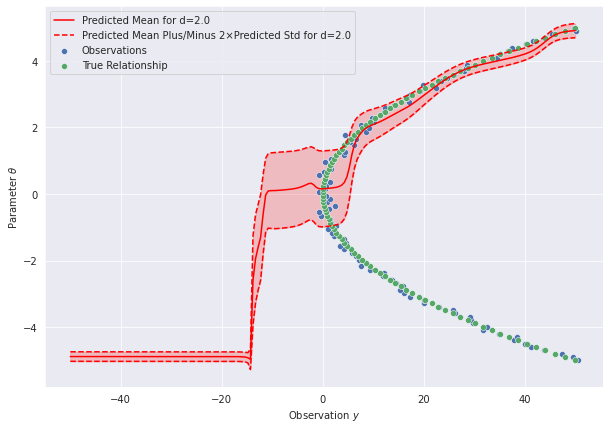

In [39]:
d_idx = 10
plot_phi_function(amortised_dist, d_idx, d=d, y_obs=y, model=model_func)

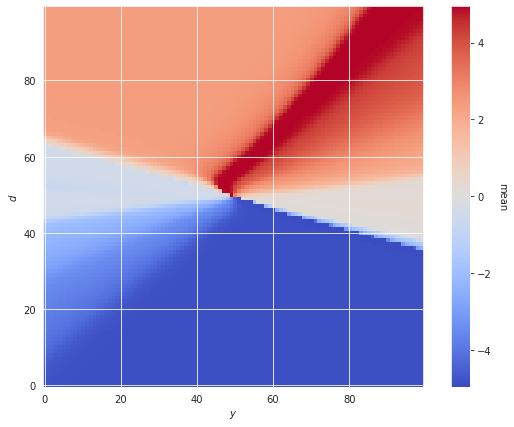

In [40]:
plot_phi_surface(amortised_dist, 'mean')

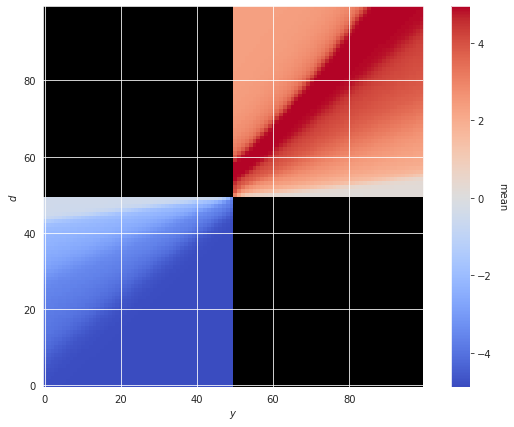

In [41]:
plot_phi_surface(amortised_dist, 'mean', apply_mask=True)

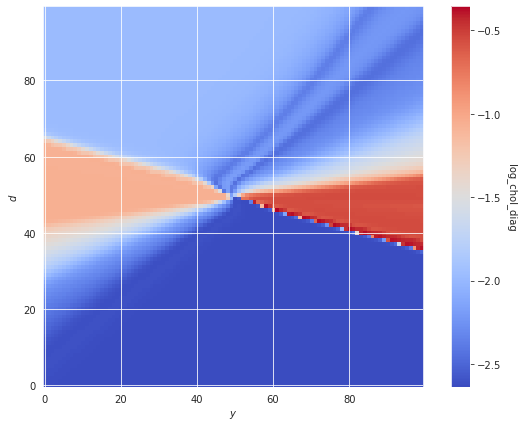

In [42]:
plot_phi_surface(amortised_dist, 'log_chol_diag')

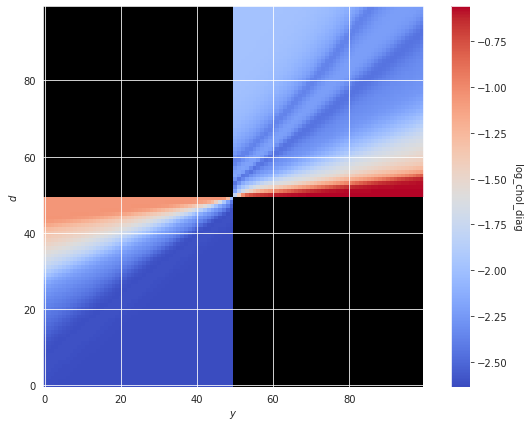

In [43]:
plot_phi_surface(amortised_dist, 'log_chol_diag', apply_mask=True)

<AxesSubplot:>

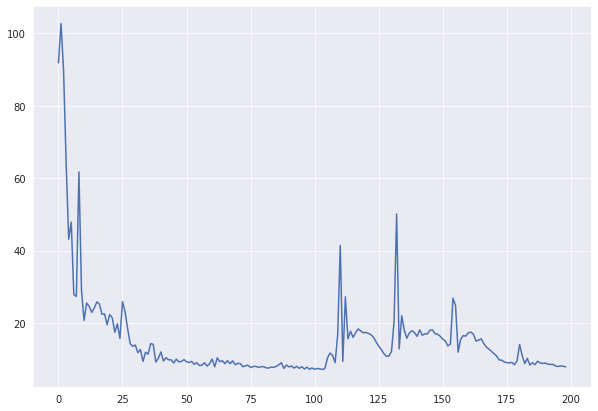

In [44]:
sns.lineplot(x=jnp.arange(len(loss)), y=jnp.array(loss))

Try Forward KL divergence:

In [74]:
model, model_grad = approx_post.models.from_jax(model_func)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)
prngkey = jax.random.PRNGKey(10)
approx_dist = approx_post.distributions.approx.Gaussian(1)
preprocessing = approx_post.distributions.amortised.Preprocessing.std_scaling(y, d) #,d
phi_lims = None # {'mean': {'lb': -50, 'ub': 50}}
amortised_dist = approx_post.distributions.amortised.NeuralNetwork(approx_dist, x_dim=1, d_dim=1, prngkey=prngkey, 
                                                                   num_layers=5, width=10, activation='tanh', 
                                                                   preprocessing=preprocessing, phi_lims=phi_lims)

In [ ]:
loss = approx_post.losses.ForwardKL(joint_dist, use_reparameterisation=False)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(amortised_dist, loss, x=y, d=d, prngkey=prngkey, verbose=True, num_samples=1000, max_iter=100) 

Loss = 0.003801035461947322, Params = Jaxtainer({'W_0': DeviceArray([[ 0.46915352, -0.09533954,  0.5206853 , -1.324442  ,
               1.9356848 ,  0.9552769 ,  1.5268283 ,  0.19877124,
               1.3546568 ,  0.524485  ],
             [-0.12585507,  1.313386  , -0.5257582 , -0.80462223,
               1.0409049 ,  0.786816  , -0.9069331 ,  0.31477904,
               1.8553184 , -1.6147579 ]], dtype=float32), 'b_0': DeviceArray([ 0.09998889, -0.0999874 ,  0.09998439, -0.09989959,
             -0.09957092, -0.09994835,  0.09991905, -0.09990074,
              0.09850197, -0.09999666], dtype=float32), 'W_1': DeviceArray([[ 0.01059286,  0.14724031, -0.49323595, -0.49129713,
               0.48611233, -0.6321362 , -0.52255535,  0.48790324,
               0.4694895 , -0.7133467 ],
             [-0.08138096, -0.879069  , -0.0407149 ,  0.66265273,
              -0.8305863 , -0.46639284,  0.02558669,  0.03062297,
               0.05232893,  0.5985756 ],
             [-0.24847399,  0.41079

Loss = 0.003505392000079155, Params = Jaxtainer({'W_0': DeviceArray([[ 0.5234674 , -0.16982819,  0.50987756, -1.3366486 ,
               2.0348952 ,  0.8634298 ,  1.5793217 ,  0.23341776,
               1.3399793 ,  0.43887004],
             [-0.13379773,  1.2371911 , -0.5824543 , -0.85586077,
               1.0569609 ,  0.7240713 , -0.8848135 ,  0.37035805,
               1.9372447 , -1.7064658 ]], dtype=float32), 'b_0': DeviceArray([ 0.18348   , -0.03082452,  0.19264822, -0.09108284,
             -0.03434131, -0.17231622,  0.10896719, -0.18202835,
              0.1914019 , -0.13145575], dtype=float32), 'W_1': DeviceArray([[-0.04762528,  0.23882931, -0.46155792, -0.54690385,
               0.4949426 , -0.69218063, -0.5988195 ,  0.42442203,
               0.5265467 , -0.81338704],
             [-0.14986435, -0.9314438 , -0.00376946,  0.614832  ,
              -0.8992085 , -0.54273266, -0.02758082, -0.03819776,
               0.10722893,  0.61214685],
             [-0.30673334,  0.50218

Loss = 0.003375082742422819, Params = Jaxtainer({'W_0': DeviceArray([[ 0.56275743, -0.22458246,  0.4928    , -1.3384665 ,
               2.1303544 ,  0.786278  ,  1.5956585 ,  0.27276778,
               1.3052771 ,  0.37997618],
             [-0.13646129,  1.1761835 , -0.6341097 , -0.92391926,
               1.0067738 ,  0.7203925 , -0.91796803,  0.42507067,
               1.955084  , -1.7726744 ]], dtype=float32), 'b_0': DeviceArray([ 0.21790901,  0.02913088,  0.26162088, -0.08717813,
              0.04538961, -0.25646916,  0.10641097, -0.22262809,
              0.28088862, -0.15483713], dtype=float32), 'W_1': DeviceArray([[-0.09330318,  0.29428017, -0.43468282, -0.58658624,
               0.5035652 , -0.7497934 , -0.6590538 ,  0.3747444 ,
               0.5695984 , -0.88322955],
             [-0.20209086, -0.9347062 ,  0.03358508,  0.5819699 ,
              -0.94519013, -0.58523315, -0.07141449, -0.09101106,
               0.15049104,  0.61292255],
             [-0.35228997,  0.55528

Loss = 0.003131415229290724, Params = Jaxtainer({'W_0': DeviceArray([[ 0.59314656, -0.27287394,  0.4600231 , -1.3238165 ,
               2.2197428 ,  0.71589094,  1.605458  ,  0.3145222 ,
               1.269634  ,  0.31910586],
             [-0.14588772,  1.1114781 , -0.6978    , -1.0043132 ,
               0.9555396 ,  0.71577734, -0.95828176,  0.4836167 ,
               1.9706206 , -1.8363086 ]], dtype=float32), 'b_0': DeviceArray([ 0.22531469,  0.08962727,  0.3323977 , -0.06934722,
              0.11596566, -0.34113353,  0.07872824, -0.26308486,
              0.35304704, -0.16489416], dtype=float32), 'W_1': DeviceArray([[-1.30285680e-01,  3.48528445e-01, -4.14130241e-01,
              -6.13798261e-01,  5.24428070e-01, -7.93560684e-01,
              -7.08546460e-01,  3.34184825e-01,  6.05148315e-01,
              -9.42468762e-01],
             [-2.44374901e-01, -9.34374511e-01,  6.82209283e-02,
               5.61087668e-01, -9.78236794e-01, -6.21054709e-01,
              -1.0825264

Loss = 0.002946767257526517, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6212377 , -0.31407797,  0.42909062, -1.3101127 ,
               2.2879927 ,  0.65943617,  1.621054  ,  0.35002318,
               1.2363703 ,  0.2632518 ],
             [-0.15008213,  1.0548313 , -0.7548687 , -1.0776974 ,
               0.91919225,  0.6969727 , -0.98628604,  0.532713  ,
               1.9917581 , -1.8921813 ]], dtype=float32), 'b_0': DeviceArray([ 0.21746197,  0.14250931,  0.39083436, -0.04606764,
              0.17860019, -0.42533633,  0.03688743, -0.2987558 ,
              0.40891147, -0.17154458], dtype=float32), 'W_1': DeviceArray([[-0.16150717,  0.3950514 , -0.39932907, -0.63633865,
               0.54419994, -0.82995063, -0.7502639 ,  0.29994506,
               0.6351843 , -0.9925045 ],
             [-0.2800046 , -0.9338733 ,  0.09953254,  0.5439446 ,
              -1.0071651 , -0.6517317 , -0.13943544, -0.17114778,
               0.21530393,  0.6115434 ],
             [-0.42101812,  0.64764

Loss = 0.0027788705192506313, Params = Jaxtainer({'W_0': DeviceArray([[ 0.64909786, -0.34957793,  0.4059563 , -1.3045167 ,
               2.3403254 ,  0.6172988 ,  1.6403857 ,  0.38008288,
               1.2197825 ,  0.21520871],
             [-0.14628886,  1.0061762 , -0.7997461 , -1.1398907 ,
               0.893895  ,  0.66856194, -1.0033185 ,  0.5733905 ,
               2.014551  , -1.9397932 ]], dtype=float32), 'b_0': DeviceArray([ 0.1990858 ,  0.18775198,  0.43122825, -0.01643104,
              0.23397313, -0.5093895 , -0.01357167, -0.3302369 ,
              0.4382194 , -0.17863262], dtype=float32), 'W_1': DeviceArray([[-0.1884267 ,  0.43487585, -0.38625902, -0.656829  ,
               0.5606923 , -0.8614729 , -0.7862884 ,  0.27044517,
               0.66106266, -1.0354462 ],
             [-0.31065315, -0.93344414,  0.12622184,  0.5286337 ,
              -1.0319057 , -0.678133  , -0.16628967, -0.20286225,
               0.24095121,  0.6099981 ],
             [-0.44819444,  0.6841

Loss = 0.0027879616245627403, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6765917 , -0.38054085,  0.39034182, -1.3056653 ,
               2.3826957 ,  0.5861748 ,  1.6618651 ,  0.40599778,
               1.2208098 ,  0.17431885],
             [-0.13609973,  0.9639779 , -0.83408177, -1.1935158 ,
               0.87490857,  0.636021  , -1.01175   ,  0.6076242 ,
               2.0367625 , -1.9805573 ]], dtype=float32), 'b_0': DeviceArray([ 0.17441493,  0.226826  ,  0.45718333,  0.01838461,
              0.28215945, -0.5911954 , -0.07064556, -0.35898495,
              0.44386408, -0.18636538], dtype=float32), 'W_1': DeviceArray([[-0.21194091,  0.46946728, -0.37386492, -0.6759123 ,
               0.5746065 , -0.8892461 , -0.817835  ,  0.24470238,
               0.6836708 , -1.072819  ],
             [-0.3373441 , -0.9329861 ,  0.14867887,  0.5150073 ,
              -1.0532871 , -0.70107657, -0.1897151 , -0.23060949,
               0.26335657,  0.60820186],
             [-0.47194383,  0.7159

Loss = 0.0028060218319296837, Params = Jaxtainer({'W_0': DeviceArray([[ 0.70339465, -0.4078124 ,  0.38058478, -1.311681  ,
               2.4189034 ,  0.5632453 ,  1.6850811 ,  0.4286933 ,
               1.2344555 ,  0.13932005],
             [-0.1219864 ,  0.9269668 , -0.8601729 , -1.2387521 ,
               0.859045  ,  0.6022308 , -1.0118287 ,  0.6363608 ,
               2.0578356 , -2.0158343 ]], dtype=float32), 'b_0': DeviceArray([ 0.1456958 ,  0.26097283,  0.47283733,  0.05730315,
              0.3235258 , -0.6691544 , -0.13250507, -0.38594294,
              0.43288198, -0.19430496], dtype=float32), 'W_1': DeviceArray([[-0.2326833 ,  0.49990064, -0.3621166 , -0.69382846,
               0.58665955, -0.9139418 , -0.8457141 ,  0.2220347 ,
               0.70362324, -1.1056685 ],
             [-0.36080652, -0.9324789 ,  0.16775669,  0.5029638 ,
              -1.0722014 , -0.7211913 , -0.21033335, -0.2551181 ,
               0.28309935,  0.60632384],
             [-0.49288148,  0.7439

Loss = 0.002787639619782567, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7293515 , -0.43201077,  0.3752971 , -1.3208658 ,
               2.4516168 ,  0.5464418 ,  1.709635  ,  0.44884503,
               1.2556154 ,  0.10978269],
             [-0.10515897,  0.8942498 , -0.87953573, -1.2756097 ,
               0.8440204 ,  0.5693121 , -1.0039054 ,  0.6602929 ,
               2.0777674 , -2.0465357 ]], dtype=float32), 'b_0': DeviceArray([ 0.11424184,  0.2910581 ,  0.48107007,  0.0989576 ,
              0.35867482, -0.7419234 , -0.19750446, -0.4114681 ,
              0.4115498 , -0.20219778], dtype=float32), 'W_1': DeviceArray([[-0.2511248 ,  0.52692187, -0.35091716, -0.71078616,
               0.59729147, -0.9360503 , -0.8705186 ,  0.20193845,
               0.72136825, -1.1347528 ],
             [-0.38158464, -0.9319365 ,  0.18402341,  0.49234077,
              -1.089212  , -0.7389532 , -0.22860739, -0.27691728,
               0.3006062 ,  0.6044739 ],
             [-0.51145256,  0.76877

Loss = 0.0027193110436201096, Params = Jaxtainer({'W_0': DeviceArray([[ 0.75433874, -0.45360655,  0.3732016 , -1.3312969 ,
               2.482773  ,  0.53409487,  1.7347834 ,  0.4669683 ,
               1.2795665 ,  0.08703537],
             [-0.08572584,  0.8651614 , -0.8934329 , -1.3056132 ,
               0.82822645,  0.5395554 , -0.9893906 ,  0.68006533,
               2.0968757 , -2.073111  ]], dtype=float32), 'b_0': DeviceArray([ 0.08130502,  0.31770247,  0.48418605,  0.14148504,
              0.38843328, -0.8078905 , -0.26434606, -0.4355111 ,
              0.38532022, -0.21008827], dtype=float32), 'W_1': DeviceArray([[-0.26762384,  0.55107474, -0.3401346 , -0.72691834,
               0.60683423, -0.9559405 , -0.89270014,  0.18402565,
               0.73724455, -1.1606524 ],
             [-0.40007478, -0.9313697 ,  0.19786474,  0.4829826 ,
              -1.1046904 , -0.75474113, -0.24490099, -0.29640713,
               0.31619886,  0.60269994],
             [-0.5280156 ,  0.7909

Loss = 0.00267694890499115, Params = Jaxtainer({'W_0': DeviceArray([[ 0.77813685, -0.47297156,  0.37298244, -1.3409293 ,
               2.5136752 ,  0.52453357,  1.75979   ,  0.48346153,
               1.3024411 ,  0.07353373],
             [-0.06373315,  0.83916044, -0.90325916, -1.3321    ,
               0.8109126 ,  0.5150838 , -0.96981317,  0.6963059 ,
               2.1160748 , -2.0957568 ]], dtype=float32), 'b_0': DeviceArray([ 0.04819242,  0.3413738 ,  0.4842737 ,  0.18285042,
              0.41353428, -0.86552465, -0.33242792, -0.45779777,
              0.35777295, -0.21826503], dtype=float32), 'W_1': DeviceArray([[-0.28246203,  0.572762  , -0.32954708, -0.74222505,
               0.6155504 , -0.97388715, -0.9126107 ,  0.16798379,
               0.75151527, -1.1838232 ],
             [-0.41657802, -0.9307944 ,  0.20942989,  0.4747259 ,
              -1.1188577 , -0.7688622 , -0.25950134, -0.31389356,
               0.33012977,  0.60101676],
             [-0.54286563,  0.810741

Loss = 0.0026814197190105915, Params = Jaxtainer({'W_0': DeviceArray([[ 0.80034906, -0.49040937,  0.3732412 , -1.3477596 ,
               2.5450237 ,  0.51641035,  1.7848003 ,  0.49864644,
               1.321239  ,  0.06931838],
             [-0.03974818,  0.8157538 , -0.91061544, -1.3605874 ,
               0.79226345,  0.4976753 , -0.9445025 ,  0.70974624,
               2.137313  , -2.1148686 ]], dtype=float32), 'b_0': DeviceArray([ 0.01648111,  0.36246568,  0.48358378,  0.2211658 ,
              0.43435892, -0.9131438 , -0.40327278, -0.47804952,
              0.33016655, -0.2267763 ], dtype=float32), 'W_1': DeviceArray([[-0.29586118,  0.59229475, -0.31879392, -0.7565433 ,
               0.6237182 , -0.99007374, -0.9305325 ,  0.15356138,
               0.7643926 , -1.2046297 ],
             [-0.43135834, -0.9302429 ,  0.21860084,  0.4673451 ,
              -1.1319704 , -0.78157717, -0.2726342 , -0.3296234 ,
               0.34260702,  0.5994301 ],
             [-0.55621654,  0.8285

Loss = 0.002606752095744014, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8204405 , -0.5061729 ,  0.37261826, -1.3498536 ,
               2.5766218 ,  0.5088961 ,  1.8103083 ,  0.5127415 ,
               1.3334211 ,  0.07379131],
             [-0.01541532,  0.794402  , -0.9171615 , -1.3969272 ,
               0.7729631 ,  0.48876435, -0.9129083 ,  0.72123796,
               2.1630704 , -2.1308863 ]], dtype=float32), 'b_0': DeviceArray([-0.01142483,  0.38138023,  0.48455593,  0.2552522 ,
              0.45122144, -0.94850427, -0.4785455 , -0.49596417,
              0.30009207, -0.23540525], dtype=float32), 'W_1': DeviceArray([[-0.30799145,  0.6099316 , -0.30777672, -0.76957756,
               0.631542  , -1.0046078 , -0.9466972 ,  0.14055955,
               0.77604926, -1.223371  ],
             [-0.44463897, -0.92974806,  0.22543398,  0.460599  ,
              -1.1442007 , -0.79310995, -0.28448418, -0.34380332,
               0.35379893,  0.59793663],
             [-0.5682362 ,  0.84474

Loss = 0.0025161593221127987, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8379502 , -0.5204685 ,  0.37003663, -1.3455985 ,
               2.607164  ,  0.5010792 ,  1.8354431 ,  0.5257896 ,
               1.3369793 ,  0.0850811 ],
             [ 0.00609459,  0.7745461 , -0.92431575, -1.4435196 ,
               0.7535095 ,  0.48842162, -0.8788946 ,  0.7314814 ,
               2.1937518 , -2.144422  ]], dtype=float32), 'b_0': DeviceArray([-0.03245132,  0.39858744,  0.48925123,  0.28364688,
              0.46518266, -0.9702797 , -0.5560566 , -0.51117074,
              0.26694223, -0.24373743], dtype=float32), 'W_1': DeviceArray([[-0.3189723 ,  0.6258858 , -0.29725838, -0.78104526,
               0.63915414, -1.0175617 , -0.9612976 ,  0.12881926,
               0.7866226 , -1.2402931 ],
             [-0.45659542, -0.929327  ,  0.23084113,  0.45433763,
              -1.1556895 , -0.8036461 , -0.2952049 , -0.3566098 ,
               0.36384556,  0.59652674],
             [-0.57909656,  0.8594

Loss = 0.0024288780987262726, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8527759 , -0.5334578 ,  0.36491328, -1.3343197 ,
               2.6351295 ,  0.49172133,  1.8597798 ,  0.53766984,
               1.3302261 ,  0.1001659 ],
             [ 0.02390513,  0.755918  , -0.9327953 , -1.4993781 ,
               0.73440766,  0.49557516, -0.8424513 ,  0.7409828 ,
               2.226622  , -2.1562288 ]], dtype=float32), 'b_0': DeviceArray([-0.04529949,  0.41447192,  0.49882922,  0.30367154,
              0.47803715, -0.97909635, -0.6347502 , -0.52364355,
              0.2414063 , -0.25102806], dtype=float32), 'W_1': DeviceArray([[-0.32891452,  0.640337  , -0.28834924, -0.7908276 ,
               0.64644027, -1.02903   , -0.9744973 ,  0.11820573,
               0.7962304 , -1.2555943 ],
             [-0.46740174, -0.92896765,  0.23607923,  0.4484636 ,
              -1.1663876 , -0.8133499 , -0.30492726, -0.36820292,
               0.37288043,  0.5951902 ],
             [-0.5889123 ,  0.8729

Loss = 0.002397353295236826, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8650768 , -0.545262  ,  0.3573543 , -1.3171957 ,
               2.6601524 ,  0.47957495,  1.8833697 ,  0.548168  ,
               1.3138449 ,  0.11646502],
             [ 0.03850475,  0.7385122 , -0.94260347, -1.5615631 ,
               0.7158071 ,  0.5086434 , -0.8024395 ,  0.7497604 ,
               2.259933  , -2.166877  ]], dtype=float32), 'b_0': DeviceArray([-0.05078358,  0.42933026,  0.5130339 ,  0.31538704,
              0.49036562, -0.9773234 , -0.71489763, -0.5341216 ,
              0.22980303, -0.2569188 ], dtype=float32), 'W_1': DeviceArray([[-0.33792633,  0.6534311 , -0.28142852, -0.79898757,
               0.6531656 , -1.0391562 , -0.98644024,  0.10860106,
               0.8049757 , -1.269434  ],
             [-0.4771885 , -0.9286558 ,  0.24166995,  0.44289532,
              -1.1762351 , -0.82233125, -0.3137631 , -0.37871775,
               0.38101268,  0.5939067 ],
             [-0.59778553,  0.88523

Loss = 0.0023917013313621283, Params = Jaxtainer({'W_0': DeviceArray([[ 0.87517446, -0.5559762 ,  0.3481606 , -1.2968385 ,
               2.6831818 ,  0.46417794,  1.9063121 ,  0.5571186 ,
               1.2900476 ,  0.13210185],
             [ 0.05055274,  0.722473  , -0.95317584, -1.6258565 ,
               0.69711834,  0.5259635 , -0.7583436 ,  0.75744313,
               2.2933621 , -2.176665  ]], dtype=float32), 'b_0': DeviceArray([-0.05075829,  0.44334707,  0.5304317 ,  0.32154644,
              0.50172174, -0.96804386, -0.79679894, -0.5439374 ,
              0.23044936, -0.26171863], dtype=float32), 'W_1': DeviceArray([[-0.34610853,  0.6652874 , -0.27595162, -0.8057571 ,
               0.6592073 , -1.0481273 , -0.9972554 ,  0.09990342,
               0.81294847, -1.2819443 ],
             [-0.486044  , -0.92838657,  0.24724148,  0.43756935,
              -1.1854146 , -0.8306384 , -0.3218083 , -0.3882714 ,
               0.3883311 ,  0.59265083],
             [-0.60581696,  0.8965

Loss = 0.0024021619465202093, Params = Jaxtainer({'W_0': DeviceArray([[ 0.88345784, -0.56569034,  0.33832082, -1.2759266 ,
               2.705384  ,  0.44603464,  1.9283783 ,  0.56450176,
               1.2612706 ,  0.14715874],
             [ 0.06058535,  0.7078969 , -0.9638911 , -1.6878709 ,
               0.6773502 ,  0.54591304, -0.7111433 ,  0.76362205,
               2.3268013 , -2.1855328 ]], dtype=float32), 'b_0': DeviceArray([-0.04723845,  0.45661345,  0.54934573,  0.32513136,
              0.5117382 , -0.9542277 , -0.87959784, -0.55435735,
              0.23968135, -0.26583484], dtype=float32), 'W_1': DeviceArray([[-0.35355136,  0.6760119 , -0.27109244, -0.8114417 ,
               0.664478  , -1.0561292 , -1.0070572 ,  0.09202522,
               0.8202269 , -1.2932416 ],
             [-0.4940319 , -0.92816085,  0.25215298,  0.43245217,
              -1.1940475 , -0.83829427, -0.32914534, -0.39696905,
               0.39490968,  0.5914039 ],
             [-0.6131099 ,  0.9068

Loss = 0.0024239022750407457, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8902589 , -0.57449234,  0.32862163, -1.2559999 ,
               2.7274258 ,  0.4258874 ,  1.9488904 ,  0.5703992 ,
               1.2292259 ,  0.16189171],
             [ 0.06880257,  0.6947871 , -0.9742888 , -1.7453628 ,
               0.6559254 ,  0.56711304, -0.66320187,  0.7681507 ,
               2.3606555 , -2.193475  ]], dtype=float32), 'b_0': DeviceArray([-0.04183196,  0.46918342,  0.5684915 ,  0.3280991 ,
              0.5201893 , -0.9381377 , -0.9617403 , -0.5661138 ,
              0.2536229 , -0.26952353], dtype=float32), 'W_1': DeviceArray([[-0.3603299 ,  0.6857082 , -0.2661761 , -0.81629837,
               0.66891944, -1.0633119 , -1.0159467 ,  0.08488957,
               0.8268782 , -1.3034381 ],
             [-0.5012115 , -0.92797655,  0.25589427,  0.4275659 ,
              -1.2021341 , -0.84532654, -0.33584473, -0.40490326,
               0.40081507,  0.59016395],
             [-0.61975664,  0.9163

Loss = 0.0024393307976424694, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8957931 , -0.58246773,  0.3192225 , -1.2371558 ,
               2.7495868 ,  0.40418348,  1.96726   ,  0.57491016,
               1.1937993 ,  0.1761424 ],
             [ 0.07498416,  0.68307865, -0.9843304 , -1.7983624 ,
               0.6325789 ,  0.58850235, -0.61623025,  0.7711102 ,
               2.395805  , -2.2005792 ]], dtype=float32), 'b_0': DeviceArray([-0.03558534,  0.4811032 ,  0.58744586,  0.33107328,
              0.5269279 , -0.9211249 , -1.0422654 , -0.5793956 ,
              0.270608  , -0.27277535], dtype=float32), 'W_1': DeviceArray([[-0.36649987,  0.6944764 , -0.26111814, -0.82043403,
               0.6726082 , -1.0697728 , -1.0240144 ,  0.07842981,
               0.83295685, -1.3126456 ],
             [-0.5076589 , -0.9278313 ,  0.2585353 ,  0.42291105,
              -1.209774  , -0.851785  , -0.34196544, -0.41215497,
               0.40611538,  0.588949  ],
             [-0.6258303 ,  0.9250

Loss = 0.00241892714984715, Params = Jaxtainer({'W_0': DeviceArray([[ 0.9001164 , -0.5896976 ,  0.3095444 , -1.2183597 ,
               2.7719727 ,  0.3808937 ,  1.9831212 ,  0.57809913,
               1.1527036 ,  0.18954825],
             [ 0.07818718,  0.6726487 , -0.99446666, -1.8479261 ,
               0.6068806 ,  0.609108  , -0.57124215,  0.7726344 ,
               2.4335694 , -2.207064  ]], dtype=float32), 'b_0': DeviceArray([-0.02890409,  0.4924428 ,  0.60668755,  0.3338612 ,
              0.5317751 , -0.9037916 , -1.1206559 , -0.59411025,
              0.29141647, -0.27532792], dtype=float32), 'W_1': DeviceArray([[-0.37209508,  0.7024105 , -0.2563672 , -0.8237622 ,
               0.67562395, -1.0755547 , -1.0313417 ,  0.07259027,
               0.83850384, -1.3209721 ],
             [-0.51346374, -0.9277235 ,  0.260663  ,  0.41841406,
              -1.2170249 , -0.85774493, -0.34755704, -0.41879606,
               0.4108806 ,  0.5877884 ],
             [-0.63139653,  0.932988

Loss = 0.0023985139559954405, Params = Jaxtainer({'W_0': DeviceArray([[ 0.90315807, -0.59625787,  0.2985051 , -1.1979599 ,
               2.7944508 ,  0.35560626,  1.996391  ,  0.58002275,
               1.1029978 ,  0.20072253],
             [ 0.07713778,  0.66332316, -1.0054401 , -1.895561  ,
               0.5786035 ,  0.62801254, -0.5289719 ,  0.7729038 ,
               2.474955  , -2.2134588 ]], dtype=float32), 'b_0': DeviceArray([-0.02154631,  0.5032913 ,  0.6272636 ,  0.33538374,
              0.5347339 , -0.8861619 , -1.1962614 , -0.6099057 ,
              0.3190876 , -0.27673167], dtype=float32), 'W_1': DeviceArray([[-0.37713793,  0.709597  , -0.2524958 , -0.8260672 ,
               0.67815816, -1.0806594 , -1.0380017 ,  0.06732124,
               0.8435518 , -1.3285159 ],
             [-0.5187197 , -0.9276499 ,  0.26295936,  0.41393116,
              -1.2240839 , -0.86330265, -0.3526626 , -0.4248887 ,
               0.41518006,  0.58670807],
             [-0.63651794,  0.9402

Loss = 0.0023763005156069994, Params = Jaxtainer({'W_0': DeviceArray([[ 0.90483093, -0.60221744,  0.28510666, -1.1743892 ,
               2.8167353 ,  0.3278079 ,  2.007251  ,  0.58076525,
               1.043094  ,  0.20873122],
             [ 0.07114908,  0.65492845, -1.0178186 , -1.9428996 ,
               0.54809326,  0.6445457 , -0.4896822 ,  0.7721455 ,
               2.5203507 , -2.220175  ]], dtype=float32), 'b_0': DeviceArray([-0.01310626,  0.5137203 ,  0.6501214 ,  0.33417657,
              0.5358574 , -0.86792284, -1.2685537 , -0.62628555,
              0.35624138, -0.2767161 ], dtype=float32), 'W_1': DeviceArray([[-3.81656885e-01,  7.16112554e-01, -2.49919698e-01,
              -8.27165306e-01,  6.80566311e-01, -1.08508158e+00,
              -1.04405868e+00,  6.25737011e-02,  8.48132193e-01,
              -1.33536255e+00],
             [-5.23508191e-01, -9.27604556e-01,  2.65933394e-01,
               4.09309089e-01, -1.23138487e+00, -8.68554533e-01,
              -3.573220

Loss = 0.0023393614683300257, Params = Jaxtainer({'W_0': DeviceArray([[ 0.90517086, -0.6076336 ,  0.26923996, -1.1469742 ,
               2.838594  ,  0.29723713,  2.0159492 ,  0.5804254 ,
               0.9733238 ,  0.21323994],
             [ 0.06088813,  0.64738774, -1.0315    , -1.9909179 ,
               0.5163195 ,  0.6583569 , -0.45286575,  0.7706076 ,
               2.56967   , -2.2273908 ]], dtype=float32), 'b_0': DeviceArray([-0.00371492,  0.5237465 ,  0.67533267,  0.32961404,
              0.5349327 , -0.84890014, -1.3377973 , -0.6429177 ,
              0.4024232 , -0.27533117], dtype=float32), 'W_1': DeviceArray([[-0.3856977 ,  0.72202057, -0.24850224, -0.8270965 ,
               0.68316   , -1.0888594 , -1.0495692 ,  0.05829754,
               0.8522792 , -1.3415824 ],
             [-0.52788526, -0.92758083,  0.26952714,  0.4044862 ,
              -1.2393253 , -0.8735579 , -0.3615737 , -0.43562296,
               0.4226228 ,  0.5848304 ],
             [-0.6456136 ,  0.9531

Loss = 0.002314966870471835, Params = Jaxtainer({'W_0': DeviceArray([[ 0.90442616, -0.6125482 ,  0.25276372, -1.1161615 ,
               2.860043  ,  0.26404458,  2.022607  ,  0.5790687 ,
               0.89501005,  0.21545471],
             [ 0.04826282,  0.6407723 , -1.0452266 , -2.0393522 ,
               0.4844614 ,  0.6694196 , -0.41746232,  0.7684667 ,
               2.6225367 , -2.2347128 ]], dtype=float32), 'b_0': DeviceArray([ 0.00567838,  0.53333795,  0.7015078 ,  0.3224248 ,
              0.53140116, -0.82943374, -1.4049578 , -0.6598444 ,
              0.45469654, -0.27309847], dtype=float32), 'W_1': DeviceArray([[-0.38932884,  0.7273697 , -0.24720077, -0.82633066,
               0.6862647 , -1.0921253 , -1.0545839 ,  0.054441  ,
               0.8560316 , -1.3472311 ],
             [-0.53187233, -0.9275723 ,  0.27272916,  0.3996982 ,
              -1.2484031 , -0.87828004, -0.36545375, -0.4403345 ,
               0.4258541 ,  0.5840238 ],
             [-0.64961654,  0.95870

Loss = 0.0022865335922688246, Params = Jaxtainer({'W_0': DeviceArray([[ 0.90278935, -0.61699194,  0.23933384, -1.0821992 ,
               2.8812838 ,  0.2277293 ,  2.0269694 ,  0.57657963,
               0.808567  ,  0.21703441],
             [ 0.03494433,  0.63520396, -1.0569432 , -2.0878768 ,
               0.45323518,  0.6779272 , -0.3816885 ,  0.7656613 ,
               2.679695  , -2.2415216 ]], dtype=float32), 'b_0': DeviceArray([ 0.01394057,  0.5425354 ,  0.7264753 ,  0.31388873,
              0.5239377 , -0.8097277 , -1.4719149 , -0.67761844,
              0.50933665, -0.27052513], dtype=float32), 'W_1': DeviceArray([[-0.39262304,  0.7321921 , -0.24495022, -0.8254941 ,
               0.6897713 , -1.0950484 , -1.0591464 ,  0.05095773,
               0.8594274 , -1.3523505 ],
             [-0.53546447, -0.9275741 ,  0.2744661 ,  0.39538485,
              -1.2585768 , -0.8826369 , -0.36899894, -0.4446405 ,
               0.42879266,  0.58328635],
             [-0.6532441 ,  0.9638

Loss = 0.002257157349959016, Params = Jaxtainer({'W_0': DeviceArray([[ 0.9000177 , -0.62099665,  0.23089635, -1.0438191 ,
               2.902233  ,  0.18539715,  2.0281901 ,  0.572622  ,
               0.7134237 ,  0.21749665],
             [ 0.0214329 ,  0.630689  , -1.065342  , -2.1372633 ,
               0.42319304,  0.68391705, -0.34182036,  0.76183707,
               2.742437  , -2.2478535 ]], dtype=float32), 'b_0': DeviceArray([ 0.0205937 ,  0.5515331 ,  0.74969065,  0.30484113,
              0.51016444, -0.7881586 , -1.5418587 , -0.6970924 ,
              0.56383574, -0.2672016 ], dtype=float32), 'W_1': DeviceArray([[-0.39563128,  0.7365045 , -0.24254122, -0.82488126,
               0.69311905, -1.0977073 , -1.0632926 ,  0.04781355,
               0.86249673, -1.3569684 ],
             [-0.5386572 , -0.9275835 ,  0.2756014 ,  0.39180234,
              -1.2692083 , -0.88661116, -0.37225106, -0.44856155,
               0.43145615,  0.5825941 ],
             [-0.6564933 ,  0.96854

Loss = 0.002247289987280965, Params = Jaxtainer({'W_0': DeviceArray([[ 0.89574075, -0.62459683,  0.22693558, -0.99988586,
               2.9212508 ,  0.13313846,  2.0241363 ,  0.5667941 ,
               0.6106228 ,  0.21390696],
             [ 0.00928947,  0.6272267 , -1.0696033 , -2.1879299 ,
               0.39726776,  0.6873074 , -0.289702  ,  0.756821  ,
               2.809837  , -2.254359  ]], dtype=float32), 'b_0': DeviceArray([ 0.02501092,  0.5605363 ,  0.77187055,  0.2957519 ,
              0.48766044, -0.76181567, -1.6197581 , -0.7189547 ,
              0.61889863, -0.26211113], dtype=float32), 'W_1': DeviceArray([[-0.39839354,  0.7403095 , -0.24250156, -0.82473403,
               0.695885  , -1.1001455 , -1.0670495 ,  0.04497771,
               0.86525136, -1.3610936 ],
             [-0.5414675 , -0.9275997 ,  0.27884433,  0.38913387,
              -1.2798997 , -0.8902101 , -0.37525737, -0.45211902,
               0.43390456,  0.5819009 ],
             [-0.6593429 ,  0.97288

Loss = 0.0022511458955705166, Params = Jaxtainer({'W_0': DeviceArray([[ 8.9009976e-01, -6.2781113e-01,  2.4190338e-01,
              -9.5417076e-01,  2.9356720e+00,  7.8155085e-02,
               2.0129259e+00,  5.5889833e-01,  5.0239235e-01,
               2.1100830e-01],
             [ 1.6001696e-03,  6.2497246e-01, -1.0636185e+00,
              -2.2374308e+00,  3.7864974e-01,  6.8915176e-01,
              -2.2338513e-01,  7.5136799e-01,  2.8798289e+00,
              -2.2589383e+00]], dtype=float32), 'b_0': DeviceArray([ 0.02541108,  0.5695486 ,  0.7845268 ,  0.28944954,
              0.45728144, -0.73544574, -1.7069719 , -0.7438339 ,
              0.6665664 , -0.25776225], dtype=float32), 'W_1': DeviceArray([[-0.40094033,  0.7436005 , -0.2423503 , -0.82558995,
               0.69793034, -1.1027508 , -1.070444  ,  0.04241246,
               0.8676688 , -1.3647126 ],
             [-0.5439358 , -0.92762715,  0.28148985,  0.38780922,
              -1.2906362 , -0.8930633 , -0.37805045, 

Loss = 0.0022698368411511183, Params = Jaxtainer({'W_0': DeviceArray([[ 0.88357925, -0.6306504 ,  0.2817799 , -0.91057086,
               2.9479015 ,  0.05112834,  1.9995173 ,  0.54883754,
               0.39714584,  0.21539575],
             [-0.00497111,  0.6236537 , -1.0440152 , -2.2832646 ,
               0.3619251 ,  0.6934523 , -0.15613674,  0.7455441 ,
               2.9504986 , -2.25941   ]], dtype=float32), 'b_0': DeviceArray([ 0.02313525,  0.57876354,  0.7802461 ,  0.28614146,
              0.4242375 , -0.71956646, -1.7944571 , -0.7717232 ,
              0.70065653, -0.25718117], dtype=float32), 'W_1': DeviceArray([[-0.4033092 ,  0.7463893 , -0.23820315, -0.8273723 ,
               0.6992378 , -1.1057594 , -1.0735098 ,  0.04007078,
               0.8698334 , -1.3678668 ],
             [-0.5460664 , -0.9276708 ,  0.27930993,  0.387649  ,
              -1.3014153 , -0.8949568 , -0.38063595, -0.45820937,
               0.438363  ,  0.5803528 ],
             [-0.6638466 ,  0.9805

Loss = 0.0022487251553684473, Params = Jaxtainer({'W_0': DeviceArray([[ 0.87583417, -0.63313806,  0.32729536, -0.8674154 ,
               2.956787  ,  0.02395588,  1.9842343 ,  0.53618383,
               0.2867546 ,  0.21482036],
             [-0.00996101,  0.62315184, -1.0186387 , -2.3273234 ,
               0.34750548,  0.69724584, -0.08788548,  0.7397758 ,
               3.0170298 , -2.260213  ]], dtype=float32), 'b_0': DeviceArray([ 0.01937508,  0.5884243 ,  0.7710782 ,  0.28083223,
              0.3917094 , -0.7048703 , -1.880954  , -0.8020146 ,
              0.74215317, -0.255802  ], dtype=float32), 'W_1': DeviceArray([[-0.40549716,  0.7486983 , -0.23576872, -0.82950884,
               0.69987947, -1.1087825 , -1.0762563 ,  0.03793237,
               0.87177044, -1.3705387 ],
             [-0.54793316, -0.9277094 ,  0.27851516,  0.38800347,
              -1.3123711 , -0.89636326, -0.3830497 , -0.4607996 ,
               0.4403319 ,  0.57945687],
             [-0.6656884 ,  0.9839

Loss = 0.002228416968137026, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8666978 , -0.6352878 ,  0.37554651, -0.82524675,
               2.9610603 ,  0.01852353,  1.9659123 ,  0.52067596,
               0.17343706,  0.2117373 ],
             [-0.01065579,  0.6234775 , -0.9897274 , -2.3724048 ,
               0.33635405,  0.7023876 , -0.01649658,  0.73452085,
               3.084488  , -2.2610183 ]], dtype=float32), 'b_0': DeviceArray([ 0.01276673,  0.5985586 ,  0.7582971 ,  0.2727874 ,
              0.36092982, -0.6943961 , -1.9682581 , -0.8350348 ,
              0.7855049 , -0.25420249], dtype=float32), 'W_1': DeviceArray([[-0.40750954,  0.7505469 , -0.233579  , -0.83173865,
               0.69982296, -1.1117224 , -1.0786842 ,  0.03596711,
               0.87346834, -1.3726496 ],
             [-0.54958683, -0.92770696,  0.27753472,  0.38854873,
              -1.3234092 , -0.89743155, -0.38532585, -0.46313056,
               0.44218907,  0.5783563 ],
             [-0.66732055,  0.98690

Loss = 0.0022268376778811216, Params = Jaxtainer({'W_0': DeviceArray([[ 0.85606736, -0.6371117 ,  0.4248113 , -0.7858418 ,
               2.9614224 ,  0.04778092,  1.9415051 ,  0.5020488 ,
               0.07196478,  0.21237278],
             [-0.00520129,  0.62475026, -0.95900387, -2.4173856 ,
               0.3280201 ,  0.7111439 ,  0.06203594,  0.7297575 ,
               3.1517363 , -2.2602437 ]], dtype=float32), 'b_0': DeviceArray([ 0.0025354 ,  0.60917825,  0.742677  ,  0.2611758 ,
              0.33250493, -0.69505   , -2.0591164 , -0.8711567 ,
              0.8266274 , -0.2537045 ], dtype=float32), 'W_1': DeviceArray([[-0.40934464,  0.7519627 , -0.2285844 , -0.83394974,
               0.6985248 , -1.1145439 , -1.0808005 ,  0.03414468,
               0.8749067 , -1.3741099 ],
             [-0.55108285, -0.92763203,  0.2730882 ,  0.38915265,
              -1.3336937 , -0.8982372 , -0.3874976 , -0.46521917,
               0.44401163,  0.5769212 ],
             [-0.66874695,  0.9894

Loss = 0.0021915000397711992, Params = Jaxtainer({'W_0': DeviceArray([[ 8.4385526e-01, -6.3864160e-01,  4.6469554e-01,
              -7.4413049e-01,  2.9602447e+00,  3.8195893e-02,
               1.9174153e+00,  4.7987574e-01, -3.1771615e-02,
               2.0746098e-01],
             [-5.2262377e-04,  6.2675703e-01, -9.3301326e-01,
              -2.4624879e+00,  3.2047608e-01,  7.1060503e-01,
               1.3746703e-01,  7.2449464e-01,  3.1973157e+00,
              -2.2615345e+00]], dtype=float32), 'b_0': DeviceArray([-0.00735978,  0.6205631 ,  0.7354072 ,  0.24203983,
              0.30701196, -0.68875426, -2.1458206 , -0.90982676,
              0.8948723 , -0.2496142 ], dtype=float32), 'W_1': DeviceArray([[-0.41103673,  0.75302035, -0.22850394, -0.83587277,
               0.69485486, -1.1168362 , -1.0826474 ,  0.03244423,
               0.87620777, -1.3751014 ],
             [-0.55241376, -0.9275009 ,  0.27360502,  0.3896111 ,
              -1.3414218 , -0.89926416, -0.3895496 , 

Loss = 0.0021644197404384613, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8308969 , -0.6398807 ,  0.49907583, -0.70448166,
               2.9587991 ,  0.01673751,  1.8954109 ,  0.45430505,
              -0.12499123,  0.202278  ],
             [ 0.00369298,  0.62951833, -0.91000175, -2.5052538 ,
               0.31347775,  0.7052213 ,  0.20852125,  0.718233  ,
               3.2355938 , -2.263088  ]], dtype=float32), 'b_0': DeviceArray([-0.01741802,  0.6325539 ,  0.7316978 ,  0.2186545 ,
              0.28378296, -0.68583727, -2.226293  , -0.9509783 ,
              0.9690448 , -0.24459168], dtype=float32), 'W_1': DeviceArray([[-0.41260833,  0.7537808 , -0.22934687, -0.83756334,
               0.68923044, -1.1188064 , -1.0842562 ,  0.03083138,
               0.8774166 , -1.3756627 ],
             [-0.5535902 , -0.9272902 ,  0.27479947,  0.38998166,
              -1.3469977 , -0.90031624, -0.39148661, -0.46870616,
               0.44720173,  0.57360584],
             [-0.6712495 ,  0.9934

Loss = 0.002156873233616352, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8180407 , -0.6408661 ,  0.5300764 , -0.6682945 ,
               2.957646  ,  0.03363709,  1.8757056 ,  0.42628253,
              -0.08515669,  0.20082684],
             [ 0.00818353,  0.63288534, -0.88887066, -2.5461159 ,
               0.30710477,  0.7021004 ,  0.27434784,  0.71132475,
               3.3008718 , -2.2635648 ]], dtype=float32), 'b_0': DeviceArray([-0.02828187,  0.64461195,  0.72838485,  0.19542903,
              0.26199996, -0.69344807, -2.3004947 , -0.99338615,
              1.0010998 , -0.24097331], dtype=float32), 'W_1': DeviceArray([[-0.41407588,  0.7543094 , -0.227953  , -0.83909863,
               0.6830126 , -1.120657  , -1.0856544 ,  0.0292839 ,
               0.87849355, -1.3757819 ],
             [-0.5546154 , -0.9269923 ,  0.27333117,  0.39034733,
              -1.3518138 , -0.9011999 , -0.39331114, -0.4701023 ,
               0.44860387,  0.5716911 ],
             [-0.6723767 ,  0.99503

Loss = 0.002142013283446431, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8044917 , -0.64167374,  0.55149686, -0.6271681 ,
               2.9569428 ,  0.02783393,  1.8565208 ,  0.39671496,
              -0.07134324,  0.19022156],
             [ 0.01428729,  0.63636804, -0.87483764, -2.583789  ,
               0.3017483 ,  0.685953  ,  0.3372829 ,  0.70404226,
               3.331954  , -2.267145  ]], dtype=float32), 'b_0': DeviceArray([-0.0389952 ,  0.65666795,  0.73489475,  0.16856913,
              0.24024998, -0.6851394 , -2.3702855 , -1.0346619 ,
              1.0580543 , -0.23383407], dtype=float32), 'W_1': DeviceArray([[-0.41544968,  0.75462884, -0.23363498, -0.8403266 ,
               0.6769588 , -1.1218957 , -1.0868344 ,  0.02781115,
               0.8795492 , -1.3755072 ],
             [-0.5554986 , -0.9265766 ,  0.27933615,  0.39061815,
              -1.3565118 , -0.90247476, -0.3950782 , -0.47130185,
               0.4498067 ,  0.5695667 ],
             [-0.6734586 ,  0.99624

Loss = 0.002126279752701521, Params = Jaxtainer({'W_0': DeviceArray([[ 0.79154485, -0.6423287 ,  0.56939846, -0.587875  ,
               2.9569895 ,  0.04893301,  1.8396164 ,  0.36921847,
              -0.04932472,  0.17869225],
             [ 0.02442788,  0.6403379 , -0.862897  , -2.6197143 ,
               0.29771426,  0.667249  ,  0.39559957,  0.69715303,
               3.369227  , -2.2708228 ]], dtype=float32), 'b_0': DeviceArray([-0.05251601,  0.66798955,  0.7418352 ,  0.14710847,
              0.21709093, -0.67664987, -2.435043  , -1.0724506 ,
              1.0919886 , -0.2279721 ], dtype=float32), 'W_1': DeviceArray([[-0.4167374 ,  0.75476503, -0.23948623, -0.84151536,
               0.6726929 , -1.1229746 , -1.0878187 ,  0.02640089,
               0.8805313 , -1.3749192 ],
             [-0.5562517 , -0.9260518 ,  0.28545156,  0.39100587,
              -1.3631761 , -0.9036823 , -0.396789  , -0.47230923,
               0.4508504 ,  0.56731063],
             [-0.6744784 ,  0.99716

Loss = 0.002138544572517276, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7810804 , -0.64284486,  0.58606154, -0.5514563 ,
               2.957714  ,  0.08149656,  1.834053  ,  0.34460708,
              -0.01096991,  0.17719147],
             [ 0.02864235,  0.6451814 , -0.85150796, -2.6560585 ,
               0.29500705,  0.6435667 ,  0.43991077,  0.6891951 ,
               3.4235206 , -2.2715034 ]], dtype=float32), 'b_0': DeviceArray([-0.06502862,  0.6783901 ,  0.74644464,  0.13438879,
              0.1916597 , -0.6783848 , -2.4880195 , -1.1061131 ,
              1.0857167 , -0.22614668], dtype=float32), 'W_1': DeviceArray([[-0.4178624 ,  0.7548959 , -0.24081543, -0.84268886,
               0.6690471 , -1.1240729 , -1.0887518 ,  0.02504723,
               0.88144296, -1.3745984 ],
             [-0.5569876 , -0.9256068 ,  0.28661716,  0.39152354,
              -1.3700031 , -0.9046444 , -0.3982854 , -0.47313356,
               0.45171702,  0.5655531 ],
             [-0.6752997 ,  0.99805

Loss = 0.0021443108562380075, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7705842 , -0.6432185 ,  0.59444386, -0.5050664 ,
               2.9586637 ,  0.07486067,  1.833822  ,  0.31742278,
               0.00662728,  0.16325885],
             [ 0.03027781,  0.6505328 , -0.8470063 , -2.69035   ,
               0.29283434,  0.60189056,  0.47762743,  0.67813164,
               3.4565225 , -2.2762063 ]], dtype=float32), 'b_0': DeviceArray([-0.07532977,  0.68873155,  0.7603041 ,  0.11957926,
              0.16570076, -0.6699268 , -2.5342097 , -1.1383052 ,
              1.1014144 , -0.21946166], dtype=float32), 'W_1': DeviceArray([[-0.4189336 ,  0.7549147 , -0.25208303, -0.84363925,
               0.6639823 , -1.1246251 , -1.0895342 ,  0.02377102,
               0.8823653 , -1.3740368 ],
             [-0.55759186, -0.92511034,  0.29836497,  0.39201635,
              -1.3742087 , -0.9059852 , -0.3997189 , -0.47382584,
               0.4523866 ,  0.563702  ],
             [-0.6760732 ,  0.9987

Loss = 0.002126488136127591, Params = Jaxtainer({'W_0': DeviceArray([[ 0.76060534, -0.64361   ,  0.60103977, -0.45376763,
               2.9597876 ,  0.10610539,  1.8382645 ,  0.32303262,
               0.02324036,  0.15307638],
             [ 0.03336182,  0.6555111 , -0.84378946, -2.7220273 ,
               0.29102772,  0.5648866 ,  0.50974345,  0.67331463,
               3.4886377 , -2.2794323 ]], dtype=float32), 'b_0': DeviceArray([-0.08532909,  0.69784945,  0.7741617 ,  0.10831393,
              0.14001943, -0.6359042 , -2.5734513 , -1.147826  ,
              1.1076595 , -0.21586871], dtype=float32), 'W_1': DeviceArray([[-0.42000252,  0.75481725, -0.2593654 , -0.84442234,
               0.66639054, -1.1250979 , -1.0901817 ,  0.02258488,
               0.8832867 , -1.3730364 ],
             [-0.5580217 , -0.9245399 ,  0.30590534,  0.39246425,
              -1.3885045 , -0.9072245 , -0.40110353, -0.4744219 ,
               0.45289877,  0.5615208 ],
             [-0.6768777 ,  0.99930

Loss = 0.002119887387380004, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7505423 , -0.643825  ,  0.6063387 , -0.40284726,
               2.9612222 ,  0.11934277,  1.8393525 ,  0.322647  ,
               0.04164232,  0.15893973],
             [ 0.03585476,  0.6612212 , -0.8416884 , -2.7510712 ,
               0.28796327,  0.51840925,  0.5430861 ,  0.66366297,
               3.5199554 , -2.2785325 ]], dtype=float32), 'b_0': DeviceArray([-0.09468085,  0.7069479 ,  0.78775823,  0.09767524,
              0.11545415, -0.61733836, -2.611595  , -1.15973   ,
              1.1096487 , -0.2154048 ], dtype=float32), 'W_1': DeviceArray([[-0.42103657,  0.7545884 , -0.26291546, -0.8449887 ,
               0.6659714 , -1.1255453 , -1.090691  ,  0.02148147,
               0.8841596 , -1.3714694 ],
             [-0.5583271 , -0.923883  ,  0.30925125,  0.39280087,
              -1.3982493 , -0.90831536, -0.40244895, -0.47493252,
               0.45333502,  0.55890834],
             [-0.6776726 ,  0.99965

Loss = 0.002106487052515149, Params = Jaxtainer({'W_0': DeviceArray([[ 0.74054503, -0.64392215,  0.6072208 , -0.34210768,
               2.9624512 ,  0.10875691,  1.8328253 ,  0.31949726,
               0.04755376,  0.15402506],
             [ 0.03563681,  0.667352  , -0.84301156, -2.776235  ,
               0.28495798,  0.45845336,  0.5807607 ,  0.6508592 ,
               3.5377715 , -2.280822  ]], dtype=float32), 'b_0': DeviceArray([-0.10157761,  0.71591765,  0.8056353 ,  0.08411864,
              0.09285244, -0.59710276, -2.651346  , -1.1711614 ,
              1.1289212 , -0.21102932], dtype=float32), 'W_1': DeviceArray([[-0.42199066,  0.7543124 , -0.27407917, -0.8453147 ,
               0.6637595 , -1.1257325 , -1.0911078 ,  0.02046741,
               0.88495934, -1.3695546 ],
             [-0.55857974, -0.9232165 ,  0.32068026,  0.39301956,
              -1.4048905 , -0.9095245 , -0.4037177 , -0.47538325,
               0.45374632,  0.5560709 ],
             [-0.67839396,  0.99993

Loss = 0.0022372042294591665, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7318258 , -0.64415807,  0.6085561 , -0.27267468,
               2.9632993 ,  0.15722565,  1.8271502 ,  0.35221413,
               0.05679577,  0.16541141],
             [ 0.03324723,  0.67238456, -0.8439367 , -2.798608  ,
               0.28316632,  0.438461  ,  0.614866  ,  0.6514511 ,
               3.5579605 , -2.277538  ]], dtype=float32), 'b_0': DeviceArray([-0.10609224,  0.7232654 ,  0.8214189 ,  0.07613279,
              0.07249764, -0.5405517 , -2.687711  , -1.1573414 ,
              1.1379433 , -0.21091884], dtype=float32), 'W_1': DeviceArray([[-0.42285198,  0.7540862 , -0.27059388, -0.845464  ,
               0.6804089 , -1.1259809 , -1.0915093 ,  0.0195434 ,
               0.88567275, -1.367594  ],
             [-0.55881274, -0.922633  ,  0.31657258,  0.3931315 ,
              -1.4372951 , -0.9105218 , -0.40484425, -0.47579163,
               0.45415094,  0.55328953],
             [-0.679027  ,  1.0002

Loss = 0.0022310956846922636, Params = Jaxtainer({'W_0': DeviceArray([[ 0.72195894, -0.644056  ,  0.6042788 , -0.2019895 ,
               2.963756  ,  0.18676227,  1.814078  ,  0.3694292 ,
               0.05088497,  0.16037579],
             [ 0.02424765,  0.67909765, -0.84936345, -2.8165047 ,
               0.2806829 ,  0.40128595,  0.65180266,  0.64112604,
               3.5633266 , -2.2795625 ]], dtype=float32), 'b_0': DeviceArray([-0.11004693,  0.73287207,  0.84283537,  0.05293342,
              0.05324413, -0.49262884, -2.7258987 , -1.1595509 ,
              1.1671923 , -0.20473641], dtype=float32), 'W_1': DeviceArray([[-0.4236093 ,  0.7538474 , -0.27763045, -0.84541136,
               0.69207764, -1.1258926 , -1.0918514 ,  0.01875443,
               0.8862985 , -1.3658309 ],
             [-0.55901873, -0.9221338 ,  0.323278  ,  0.39313382,
              -1.4649968 , -0.9117552 , -0.40586326, -0.4761927 ,
               0.45453724,  0.55081266],
             [-0.6795527 ,  1.0005

Loss = 0.002243739552795887, Params = Jaxtainer({'W_0': DeviceArray([[ 0.70887387, -0.6436951 ,  0.5982027 , -0.13441488,
               2.9632201 ,  0.20789301,  1.791521  ,  0.37704363,
               0.04014153,  0.15668193],
             [ 0.00685299,  0.68768775, -0.85722595, -2.833894  ,
               0.27648547,  0.350091  ,  0.6943805 ,  0.6142101 ,
               3.5702834 , -2.2813022 ]], dtype=float32), 'b_0': DeviceArray([-0.12203655,  0.7449388 ,  0.8620372 ,  0.02805173,
              0.03378484, -0.46544948, -2.7662435 , -1.1782376 ,
              1.1887032 , -0.19848096], dtype=float32), 'W_1': DeviceArray([[-0.42436507,  0.7529831 , -0.2852882 , -0.8453852 ,
               0.70030516, -1.1257588 , -1.0920264 ,  0.01813524,
               0.88689876, -1.3640531 ],
             [-0.55915946, -0.9221437 ,  0.32986987,  0.39288592,
              -1.4919759 , -0.912928  , -0.4067531 , -0.47658476,
               0.45483097,  0.54850554],
             [-0.6801118 ,  1.00039

Loss = 0.0023007341660559177, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6908166 , -0.64327246,  0.59534794, -0.11519101,
               2.9603035 ,  0.22774744,  1.7593902 ,  0.3796969 ,
               0.04737314,  0.18904914],
             [-0.01978651,  0.6963594 , -0.86609995, -2.8587236 ,
               0.26918697,  0.28782007,  0.74298376,  0.56653893,
               3.5991468 , -2.2713487 ]], dtype=float32), 'b_0': DeviceArray([-0.1515693 ,  0.75796425,  0.86836594,  0.03582697,
              0.01254013, -0.47650257, -2.8080528 , -1.2126292 ,
              1.1699321 , -0.2043388 ], dtype=float32), 'W_1': DeviceArray([[-0.4253263 ,  0.7504895 , -0.27709132, -0.84575105,
               0.7067408 , -1.1259854 , -1.0918605 ,  0.01762219,
               0.88766575, -1.3614807 ],
             [-0.559208  , -0.92380536,  0.3186624 ,  0.39198893,
              -1.518347  , -0.91360724, -0.40737262, -0.47688946,
               0.4548339 ,  0.5457308 ],
             [-0.6809928 ,  0.9989

Loss = 0.0023322158958762884, Params = Jaxtainer({'W_0': DeviceArray([[ 0.66792554, -0.64292455,  0.5863232 , -0.0583283 ,
               2.9547582 ,  0.23627666,  1.71942   ,  0.37884036,
               0.04254941,  0.21000487],
             [-0.05312115,  0.70339876, -0.8823032 , -2.8707616 ,
               0.25664476,  0.21481293,  0.7924894 ,  0.50417286,
               3.6267908 , -2.2661705 ]], dtype=float32), 'b_0': DeviceArray([-0.19763583,  0.7707977 ,  0.8742689 ,  0.05435923,
             -0.01194181, -0.50723076, -2.8530116 , -1.2581826 ,
              1.1512153 , -0.20697637], dtype=float32), 'W_1': DeviceArray([[-0.42654562,  0.7466773 , -0.27635464, -0.8465501 ,
               0.71153116, -1.1259602 , -1.0913223 ,  0.01717276,
               0.88872814, -1.3578799 ],
             [-0.5590714 , -0.92704856,  0.31504232,  0.39057454,
              -1.5414361 , -0.9144801 , -0.40766975, -0.47706616,
               0.45439202,  0.54226416],
             [-0.6822766 ,  0.9963

Loss = 0.0022544271778315306, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6404657 , -0.6425892 ,  0.56872416,  0.02538332,
               2.9468927 ,  0.2325356 ,  1.6730571 ,  0.3728173 ,
               0.02557801,  0.22172897],
             [-0.09463513,  0.7095533 , -0.908288  , -2.86349   ,
               0.24012345,  0.13197738,  0.8348082 ,  0.42999518,
               3.643662  , -2.2652726 ]], dtype=float32), 'b_0': DeviceArray([-0.25380385,  0.78388524,  0.88492   ,  0.07278268,
             -0.03798752, -0.5475909 , -2.9031293 , -1.3132207 ,
              1.1430161 , -0.20628236], dtype=float32), 'W_1': DeviceArray([[-0.42792386,  0.7419466 , -0.28235012, -0.8476589 ,
               0.71545744, -1.1254225 , -1.0905228 ,  0.01679276,
               0.89005494, -1.3538713 ],
             [-0.55867314, -0.93148243,  0.31830984,  0.38902467,
              -1.5627506 , -0.91585976, -0.40769893, -0.47713575,
               0.4535183 ,  0.5384907 ],
             [-0.6838153 ,  0.9927

Loss = 0.00217304821126163, Params = Jaxtainer({'W_0': DeviceArray([[ 0.60993576, -0.6421618 ,  0.54916066,  0.11548851,
               2.9380298 ,  0.22092578,  1.6146953 ,  0.36056763,
               0.00769234,  0.22960399],
             [-0.13535245,  0.7156063 , -0.936049  , -2.8526955 ,
               0.22368948,  0.05481312,  0.8709296 ,  0.34955552,
               3.669471  , -2.2658215 ]], dtype=float32), 'b_0': DeviceArray([-0.31930944,  0.79720587,  0.88965416,  0.10677662,
             -0.06253646, -0.60175085, -2.9623525 , -1.3752534 ,
              1.1142867 , -0.20631956], dtype=float32), 'W_1': DeviceArray([[-0.42943236,  0.7365513 , -0.2904158 , -0.8494106 ,
               0.71829116, -1.1249197 , -1.0895293 ,  0.01645956,
               0.8916251 , -1.3492953 ],
             [-0.55794984, -0.9366509 ,  0.3235365 ,  0.3880771 ,
              -1.5819772 , -0.9171602 , -0.40765208, -0.47711846,
               0.45223895,  0.5341613 ],
             [-0.6855627 ,  0.988421

Loss = 0.002235970227047801, Params = Jaxtainer({'W_0': DeviceArray([[ 0.5819074 , -0.64162683,  0.5379071 ,  0.05548421,
               2.9291444 ,  0.21192391,  1.5528404 ,  0.3454122 ,
               0.013626  ,  0.24354568],
             [-0.16679925,  0.72167766, -0.95369816, -2.9088283 ,
               0.2062756 ,  0.007273  ,  0.8993777 ,  0.27088305,
               3.7229192 , -2.2627945 ]], dtype=float32), 'b_0': DeviceArray([-0.39125395,  0.8099182 ,  0.8778941 ,  0.18082708,
             -0.08534264, -0.6699573 , -3.024792  , -1.438164  ,
              1.0485337 , -0.21352996], dtype=float32), 'W_1': DeviceArray([[-0.43106583,  0.7311677 , -0.29221785, -0.8525251 ,
               0.7202843 , -1.1252091 , -1.0884688 ,  0.01612978,
               0.8934016 , -1.3443979 ],
             [-0.5568801 , -0.9415898 ,  0.3221829 ,  0.38883448,
              -1.5990674 , -0.9175139 , -0.4076192 , -0.47702157,
               0.45060146,  0.5294321 ],
             [-0.68742913,  0.98388

Loss = 0.002188054844737053, Params = Jaxtainer({'W_0': DeviceArray([[ 5.5595386e-01, -6.4104003e-01,  5.2804655e-01,
              -8.0884993e-04,  2.9195995e+00,  2.0220841e-01,
               1.4855475e+00,  3.2836056e-01,  2.1639869e-02,
               2.5632370e-01],
             [-1.8759696e-01,  7.2795081e-01, -9.6473485e-01,
              -2.9632933e+00,  1.9181691e-01, -1.8070091e-02,
               9.2347139e-01,  1.9727418e-01,  3.7833810e+00,
              -2.2596889e+00]], dtype=float32), 'b_0': DeviceArray([-0.4632642 ,  0.8218472 ,  0.86392254,  0.25647557,
             -0.10426627, -0.7382475 , -3.0902467 , -1.498784  ,
              0.97378534, -0.22186002], dtype=float32), 'W_1': DeviceArray([[-0.43270338,  0.72602034, -0.29379696, -0.8565481 ,
               0.721774  , -1.1256474 , -1.0874158 ,  0.01585437,
               0.8951694 , -1.339521  ],
             [-0.55564   , -0.9460871 ,  0.32087848,  0.39078975,
              -1.6145196 , -0.91768277, -0.4076273 , -

Loss = 0.002173743210732937, Params = Jaxtainer({'W_0': DeviceArray([[ 0.528732  , -0.64047194,  0.5110413 , -0.04749134,
               2.9072556 ,  0.18579276,  1.415094  ,  0.30938733,
               0.01718961,  0.26311344],
             [-0.20863271,  0.7342494 , -0.9777218 , -3.0106983 ,
               0.17705563, -0.04251035,  0.93894625,  0.12693614,
               3.8255806 , -2.2597373 ]], dtype=float32), 'b_0': DeviceArray([-0.52775824,  0.8334329 ,  0.8647417 ,  0.30639178,
             -0.12076703, -0.7892109 , -3.1589417 , -1.5564867 ,
              0.92678446, -0.22509754], dtype=float32), 'W_1': DeviceArray([[-0.43427896,  0.7211845 , -0.29955554, -0.8605026 ,
               0.7228986 , -1.1253017 , -1.0863856 ,  0.01568416,
               0.8967631 , -1.3351039 ],
             [-0.5543249 , -0.95020765,  0.3244344 ,  0.39285073,
              -1.6286575 , -0.9187402 , -0.40765965, -0.4769603 ,
               0.44739914,  0.52031386],
             [-0.6908722 ,  0.97521

Loss = 0.002166865859180689, Params = Jaxtainer({'W_0': DeviceArray([[ 4.9768049e-01, -6.3990772e-01,  4.8603898e-01,
              -8.5237265e-02,  2.8914263e+00,  1.6098624e-01,
               1.3430820e+00,  2.8773373e-01, -4.5522302e-04,
               2.6389432e-01],
             [-2.3614238e-01,  7.4053806e-01, -9.9459356e-01,
              -3.0526652e+00,  1.5936020e-01, -7.5190611e-02,
               9.4373339e-01,  5.8199950e-02,  3.8458276e+00,
              -2.2634184e+00]], dtype=float32), 'b_0': DeviceArray([-0.5835724 ,  0.84517026,  0.88209873,  0.33259025,
             -0.13910373, -0.82074285, -3.230623  , -1.6122149 ,
              0.9100628 , -0.22260594], dtype=float32), 'W_1': DeviceArray([[-4.3583086e-01,  7.1666574e-01, -3.0960965e-01,
              -8.6392814e-01,  7.2358048e-01, -1.1239617e+00,
              -1.0853550e+00,  1.5610213e-02,  8.9816380e-01,
              -1.3311052e+00],
             [-5.5291384e-01, -9.5395303e-01,  3.3295670e-01,
              

Loss = 0.00213169539347291, Params = Jaxtainer({'W_0': DeviceArray([[ 0.4630174 , -0.6392943 ,  0.4560517 , -0.11623276,
               2.87358   ,  0.1296027 ,  1.2704414 ,  0.26263756,
              -0.02726474,  0.2604999 ],
             [-0.26751724,  0.747299  , -1.0125582 , -3.091601  ,
               0.14108156, -0.11451404,  0.94194746, -0.0100052 ,
               3.8524415 , -2.2695346 ]], dtype=float32), 'b_0': DeviceArray([-0.63361484,  0.8569848 ,  0.90983886,  0.3438574 ,
             -0.1587795 , -0.84053165, -3.302786  , -1.6668352 ,
              0.91096663, -0.21647917], dtype=float32), 'W_1': DeviceArray([[-0.4373393 ,  0.7124488 , -0.32195088, -0.86696124,
               0.72375965, -1.1219773 , -1.0843158 ,  0.01561753,
               0.8993442 , -1.327452  ],
             [-0.55147856, -0.9573531 ,  0.34418544,  0.39599025,
              -1.6530261 , -0.92380196, -0.4078443 , -0.4771987 ,
               0.44507736,  0.5127632 ],
             [-0.69365627,  0.967496

Loss = 0.002131735673174262, Params = Jaxtainer({'W_0': DeviceArray([[ 0.42734122, -0.6385804 ,  0.42690027, -0.14255168,
               2.8551066 ,  0.09792943,  1.1979997 ,  0.2341099 ,
              -0.05662501,  0.2566024 ],
             [-0.2962784 ,  0.7549488 , -1.0264269 , -3.129567  ,
               0.1238063 , -0.14801584,  0.93614405, -0.07759561,
               3.8563507 , -2.2755864 ]], dtype=float32), 'b_0': DeviceArray([-0.6826585 ,  0.8685579 ,  0.9391779 ,  0.34870297,
             -0.17828211, -0.85922676, -3.374164  , -1.720359  ,
              0.91530585, -0.20990944], dtype=float32), 'W_1': DeviceArray([[-0.43881607,  0.7085664 , -0.33335668, -0.87057173,
               0.72338545, -1.1199893 , -1.0832887 ,  0.01569094,
               0.90030944, -1.3240622 ],
             [-0.5500421 , -0.96043384,  0.35464647,  0.39821064,
              -1.662951  , -0.926681  , -0.40802693, -0.47741497,
               0.4443249 ,  0.5093992 ],
             [-0.6947627 ,  0.96409

Loss = 0.002153660636395216, Params = Jaxtainer({'W_0': DeviceArray([[ 0.3978871 , -0.63786745,  0.4035023 , -0.16601938,
               2.8370173 ,  0.07645276,  1.1295989 ,  0.20571905,
              -0.0795045 ,  0.2548438 ],
             [-0.31339893,  0.7627996 , -1.0320083 , -3.1666765 ,
               0.10902402, -0.1562898 ,  0.9271381 , -0.14089417,
               3.8629065 , -2.2798772 ]], dtype=float32), 'b_0': DeviceArray([-0.7305467 ,  0.8790014 ,  0.9645841 ,  0.34966958,
             -0.19591284, -0.88254535, -3.4422102 , -1.7701151 ,
              0.9182126 , -0.204668  ], dtype=float32), 'W_1': DeviceArray([[-0.44027692,  0.7050683 , -0.34208035, -0.87583494,
               0.7227834 , -1.1184577 , -1.082344  ,  0.01582587,
               0.90108   , -1.3209678 ],
             [-0.5486203 , -0.9633072 ,  0.36246485,  0.4024715 ,
              -1.671626  , -0.929015  , -0.40819448, -0.47769508,
               0.44382855,  0.5063472 ],
             [-0.6956202 ,  0.96116

Loss = 0.002124854363501072, Params = Jaxtainer({'W_0': DeviceArray([[ 0.37492192, -0.6371819 ,  0.38388243, -0.186623  ,
               2.8192728 ,  0.0639957 ,  1.0670015 ,  0.17749341,
              -0.09841514,  0.2534877 ],
             [-0.3189452 ,  0.7706618 , -1.0306277 , -3.2031033 ,
               0.09812543, -0.14229785,  0.9164265 , -0.20002934,
               3.8697383 , -2.2834084 ]], dtype=float32), 'b_0': DeviceArray([-0.7759694 ,  0.8883028 ,  0.98864686,  0.34628543,
             -0.21100256, -0.9082155 , -3.5057063 , -1.8160195 ,
              0.92255837, -0.19928518], dtype=float32), 'W_1': DeviceArray([[-0.44172272,  0.7019245 , -0.34950584, -0.8825738 ,
               0.72194415, -1.1172395 , -1.0814676 ,  0.01605369,
               0.90165627, -1.3181309 ],
             [-0.54723716, -0.96603364,  0.36908975,  0.40857863,
              -1.6790836 , -0.9309653 , -0.4083232 , -0.47808215,
               0.44360173,  0.5035721 ],
             [-0.69621533,  0.95871

Loss = 0.002106273081153631, Params = Jaxtainer({'W_0': DeviceArray([[ 0.3534225 , -0.6365366 ,  0.36200634, -0.20361379,
               2.8013964 ,  0.05079174,  1.0069935 ,  0.14842018,
              -0.12412658,  0.24884675],
             [-0.31869462,  0.7783205 , -1.0260584 , -3.2382271 ,
               0.09266026, -0.11951379,  0.9055382 , -0.25586957,
               3.8658466 , -2.2884505 ]], dtype=float32), 'b_0': DeviceArray([-0.8166286 ,  0.89678234,  1.0183411 ,  0.33677626,
             -0.22311044, -0.92720264, -3.5652876 , -1.8585917 ,
              0.93911415, -0.19128758], dtype=float32), 'W_1': DeviceArray([[-0.44312587,  0.6990903 , -0.3578297 , -0.88976914,
               0.72077847, -1.115796  , -1.0806077 ,  0.01643135,
               0.90201646, -1.3155228 ],
             [-0.5459378 , -0.9686195 ,  0.37686193,  0.41533315,
              -1.6851742 , -0.93315315, -0.40847972, -0.4786532 ,
               0.44368252,  0.50104463],
             [-0.69658226,  0.95667

Loss = 0.00210775900632143, Params = Jaxtainer({'W_0': DeviceArray([[ 0.32796967, -0.63593787,  0.3343202 , -0.21696529,
               2.7830365 ,  0.02873984,  0.9504708 ,  0.11722959,
              -0.16368766,  0.23943919],
             [-0.3219304 ,  0.7856927 , -1.0207362 , -3.271744  ,
               0.09301783, -0.10068485,  0.8947842 , -0.31002337,
               3.845354  , -2.296015  ]], dtype=float32), 'b_0': DeviceArray([-0.850688  ,  0.9046341 ,  1.0565213 ,  0.3222097 ,
             -0.23199475, -0.93452364, -3.6205282 , -1.8983041 ,
              0.9715389 , -0.17938064], dtype=float32), 'W_1': DeviceArray([[-0.44446173,  0.6965206 , -0.36800084, -0.89664596,
               0.71904624, -1.1137761 , -1.0796847 ,  0.01698155,
               0.9021673 , -1.3131431 ],
             [-0.5447679 , -0.9710784 ,  0.38682592,  0.42185304,
              -1.6894892 , -0.9359718 , -0.4087488 , -0.47943997,
               0.44407707,  0.4987573 ],
             [-0.69674885,  0.954994

Loss = 0.002108712447807193, Params = Jaxtainer({'W_0': DeviceArray([[ 0.3263728 , -0.63556904,  0.30409312, -0.22818607,
               2.7642064 ,  0.01102164,  0.9130517 ,  0.09123699,
              -0.21425882,  0.2280209 ],
             [-0.30845398,  0.79188085, -1.012707  , -3.3031769 ,
               0.09798619, -0.06860465,  0.88503844, -0.35791802,
               3.8121812 , -2.3042388 ]], dtype=float32), 'b_0': DeviceArray([-0.86415875,  0.9110064 ,  1.099671  ,  0.30701432,
             -0.23788962, -0.92455256, -3.6671984 , -1.9316292 ,
              1.011116  , -0.16341656], dtype=float32), 'W_1': DeviceArray([[-0.4457476 ,  0.69425607, -0.3790986 , -0.9034295 ,
               0.7175761 , -1.1114984 , -1.0789348 ,  0.01766639,
               0.902182  , -1.3109952 ],
             [-0.54372877, -0.9736324 ,  0.3973947 ,  0.4284456 ,
              -1.695474  , -0.93904215, -0.40835193, -0.48038355,
               0.44468448,  0.4967301 ],
             [-0.6967046 ,  0.95389

Loss = 0.0021124775521457195, Params = Jaxtainer({'W_0': DeviceArray([[ 0.34939206, -0.6354018 ,  0.28053457, -0.23944724,
               2.74454   ,  0.00898379,  0.89839315,  0.07351528,
              -0.25639978,  0.21894355],
             [-0.2841325 ,  0.7969204 , -0.9990401 , -3.3349097 ,
               0.10441252, -0.0194899 ,  0.8760134 , -0.39962417,
               3.791994  , -2.3108735 ]], dtype=float32), 'b_0': DeviceArray([-0.86027014,  0.915924  ,  1.1369636 ,  0.29904747,
             -0.24204111, -0.9100064 , -3.7046468 , -1.9595478 ,
              1.0238599 , -0.14864793], dtype=float32), 'W_1': DeviceArray([[-0.44700673,  0.6922796 , -0.38955986, -0.91036755,
               0.7165917 , -1.1098033 , -1.0783803 ,  0.01839279,
               0.90225273, -1.3090957 ],
             [-0.54278934, -0.97629404,  0.40689978,  0.43557498,
              -1.7036227 , -0.9413593 , -0.40726086, -0.48136085,
               0.4452678 ,  0.49498507],
             [-0.69645256,  0.9533

Loss = 0.002111772308126092, Params = Jaxtainer({'W_0': DeviceArray([[ 0.3839385 , -0.6354486 ,  0.27195656, -0.2520371 ,
               2.7214935 ,  0.02590328,  0.8994302 ,  0.06472546,
              -0.26729122,  0.21565261],
             [-0.28454846,  0.7993918 , -0.9797655 , -3.3686764 ,
               0.10738482,  0.0257318 ,  0.8672634 , -0.43646926,
               3.8064437 , -2.314712  ]], dtype=float32), 'b_0': DeviceArray([-0.83526003,  0.9202379 ,  1.1604085 ,  0.30223098,
             -0.24565177, -0.89128184, -3.7352371 , -1.9832302 ,
              0.99423724, -0.13985494], dtype=float32), 'W_1': DeviceArray([[-0.4481864 ,  0.6905922 , -0.39833632, -0.9158208 ,
               0.7161442 , -1.1088728 , -1.0779957 ,  0.01907037,
               0.90257996, -1.307476  ],
             [-0.5419673 , -0.9790202 ,  0.41433486,  0.4424068 ,
              -1.7131989 , -0.9425291 , -0.40572882, -0.48226303,
               0.44559756,  0.49355185],
             [-0.6960942 ,  0.95317

Loss = 0.0021008034236729145, Params = Jaxtainer({'W_0': DeviceArray([[ 0.41079524, -0.6355967 ,  0.27162063, -0.26498538,
               2.6926398 ,  0.04125328,  0.90287703,  0.05888595,
              -0.25991794,  0.21483758],
             [-0.32577217,  0.79926604, -0.9594979 , -3.4024806 ,
               0.10302979,  0.04009597,  0.8579624 , -0.47163847,
               3.837668  , -2.3177505 ]], dtype=float32), 'b_0': DeviceArray([-0.7940687 ,  0.9250542 ,  1.1745282 ,  0.31299406,
             -0.24997154, -0.86622465, -3.7631264 , -2.0039818 ,
              0.9421305 , -0.13575122], dtype=float32), 'W_1': DeviceArray([[-0.44922224,  0.6891162 , -0.40616277, -0.9188571 ,
               0.7152419 , -1.1079805 , -1.0775338 ,  0.01971998,
               0.9030545 , -1.3061693 ],
             [-0.54130775, -0.9816619 ,  0.42077425,  0.448248  ,
              -1.7214366 , -0.9433025 , -0.40433732, -0.48312095,
               0.44580004,  0.49246916],
             [-0.6957092 ,  0.9532

Loss = 0.0020942632108926773, Params = Jaxtainer({'W_0': DeviceArray([[ 0.42320198, -0.6357587 ,  0.27301514, -0.2774125 ,
               2.6590989 ,  0.04446033,  0.901168  ,  0.05311579,
              -0.24776226,  0.21345824],
             [-0.39536545,  0.7977032 , -0.94116735, -3.434443  ,
               0.09284142,  0.02328926,  0.84734726, -0.506141  ,
               3.8697    , -2.3215163 ]], dtype=float32), 'b_0': DeviceArray([-0.74271166,  0.9305327 ,  1.1845282 ,  0.32786968,
             -0.25769192, -0.8362775 , -3.790906  , -2.0223277 ,
              0.8817311 , -0.13404141], dtype=float32), 'W_1': DeviceArray([[-0.45008162,  0.68781185, -0.41355664, -0.919739  ,
               0.71332633, -1.1067097 , -1.0768968 ,  0.02038904,
               0.90349275, -1.3052073 ],
             [-0.5408589 , -0.98418444,  0.42688867,  0.4525692 ,
              -1.7272607 , -0.9443144 , -0.40327567, -0.48399287,
               0.4460838 ,  0.49177933],
             [-0.69529533,  0.9534

Loss = 0.002086932770907879, Params = Jaxtainer({'W_0': DeviceArray([[ 0.4262459 , -0.6358804 ,  0.2756106 , -0.28938666,
               2.6230562 ,  0.0376741 ,  0.8936328 ,  0.04755766,
              -0.22998562,  0.2114742 ],
             [-0.47171926,  0.7966244 , -0.9244255 , -3.4645343 ,
               0.07916489, -0.00759024,  0.835228  , -0.5387104 ,
               3.904128  , -2.3258398 ]], dtype=float32), 'b_0': DeviceArray([-0.6939119 ,  0.9357647 ,  1.1903024 ,  0.34652418,
             -0.27018538, -0.81094605, -3.819036  , -2.0390568 ,
              0.81278884, -0.13480194], dtype=float32), 'W_1': DeviceArray([[-0.4507943 ,  0.6866696 , -0.420414  , -0.9200932 ,
               0.71039224, -1.1054571 , -1.0760956 ,  0.02108497,
               0.9038106 , -1.3046252 ],
             [-0.5406034 , -0.98659027,  0.4326062 ,  0.45610422,
              -1.7307364 , -0.9453374 , -0.4025456 , -0.48488724,
               0.4465303 ,  0.49151725],
             [-0.6947549 ,  0.95381

Loss = 0.0020853481255471706, Params = Jaxtainer({'W_0': DeviceArray([[ 0.43173814, -0.6359463 ,  0.2822147 , -0.30131495,
               2.5852706 ,  0.03303146,  0.88312346,  0.04448374,
              -0.1995506 ,  0.21022715],
             [-0.5357394 ,  0.79683214, -0.9066129 , -3.4939945 ,
               0.06372964, -0.02931995,  0.8214501 , -0.5666218 ,
               3.9513905 , -2.329572  ]], dtype=float32), 'b_0': DeviceArray([-0.65856266,  0.93994385,  1.1885834 ,  0.36912608,
             -0.28559276, -0.80395746, -3.8469908 , -2.0553377 ,
              0.728913  , -0.13933203], dtype=float32), 'W_1': DeviceArray([[-0.45145392,  0.6856952 , -0.42640558, -0.92178017,
               0.7068152 , -1.1050955 , -1.0752035 ,  0.02179945,
               0.9039756 , -1.3044482 ],
             [-0.5404048 , -0.9888821 ,  0.43753895,  0.46098968,
              -1.7325231 , -0.9453485 , -0.40205425, -0.48579055,
               0.44713315,  0.49168962],
             [-0.6939799 ,  0.9543

Loss = 0.0020866384729743004, Params = Jaxtainer({'W_0': DeviceArray([[ 0.44806683, -0.63599837,  0.29082525, -0.31267315,
               2.5457416 ,  0.0392617 ,  0.8732693 ,  0.04609803,
              -0.16531532,  0.20887627],
             [-0.5759389 ,  0.7981631 , -0.8871074 , -3.5223172 ,
               0.04813847, -0.02782908,  0.80609906, -0.5881727 ,
               4.0032673 , -2.3327715 ]], dtype=float32), 'b_0': DeviceArray([-0.6388523 ,  0.9428208 ,  1.1819737 ,  0.391826  ,
             -0.30219314, -0.81415135, -3.873923  , -2.0714583 ,
              0.6403502 , -0.1452187 ], dtype=float32), 'W_1': DeviceArray([[-0.45209944,  0.68489456, -0.43168914, -0.92552084,
               0.70335525, -1.1055872 , -1.074332  ,  0.02257158,
               0.9039055 , -1.3046925 ],
             [-0.540187  , -0.9910726 ,  0.44181356,  0.46825662,
              -1.7339194 , -0.9443243 , -0.40164757, -0.48674774,
               0.4479491 ,  0.49229184],
             [-0.6929506 ,  0.9549

Loss = 0.002084523206576705, Params = Jaxtainer({'W_0': DeviceArray([[ 0.47162268, -0.6360754 ,  0.29553676, -0.32268804,
               2.5038698 ,  0.048243  ,  0.86529696,  0.05206239,
              -0.13919592,  0.20536333],
             [-0.59729993,  0.80028594, -0.86883056, -3.5468953 ,
               0.03282249, -0.0146334 ,  0.7894263 , -0.60429746,
               4.0416775 , -2.3367815 ]], dtype=float32), 'b_0': DeviceArray([-0.62780136,  0.94471335,  1.1775789 ,  0.41161662,
             -0.3209303 , -0.82699776, -3.899523  , -2.0867527 ,
              0.569697  , -0.14840423], dtype=float32), 'W_1': DeviceArray([[-0.4526854 ,  0.6842553 , -0.43685785, -0.9305252 ,
               0.7003209 , -1.106008  , -1.0735002 ,  0.02344507,
               0.903563  , -1.3053579 ],
             [-0.53999233, -0.99316293,  0.44607708,  0.4769771 ,
              -1.73544   , -0.9433678 , -0.4012968 , -0.48781005,
               0.44900545,  0.49331257],
             [-0.691725  ,  0.95561

Loss = 0.0020829548593610525, Params = Jaxtainer({'W_0': DeviceArray([[ 0.49425673, -0.63619703,  0.29384616, -0.33132637,
               2.458849  ,  0.04836394,  0.85832405,  0.0607977 ,
              -0.12448442,  0.19904847],
             [-0.6126406 ,  0.80283916, -0.8542277 , -3.5667198 ,
               0.01810082, -0.00665844,  0.77163684, -0.6170163 ,
               4.0621624 , -2.3423169 ]], dtype=float32), 'b_0': DeviceArray([-0.61726415,  0.9460366 ,  1.1787951 ,  0.42891395,
             -0.34254977, -0.83363837, -3.924021  , -2.1006095 ,
              0.52212733, -0.14783747], dtype=float32), 'W_1': DeviceArray([[-0.45313954,  0.68375623, -0.4421982 , -0.93559057,
               0.6973108 , -1.1057299 , -1.0726489 ,  0.02443824,
               0.90295196, -1.3064237 ],
             [-0.53990865, -0.9951472 ,  0.45065582,  0.48559028,
              -1.7364726 , -0.9432714 , -0.40107328, -0.48899907,
               0.45029157,  0.4947264 ],
             [-0.69039565,  0.9563

Loss = 0.002080207923427224, Params = Jaxtainer({'W_0': DeviceArray([[ 0.51399076, -0.6363717 ,  0.2869133 , -0.33889565,
               2.412151  ,  0.03626464,  0.85169333,  0.07160556,
              -0.11867575,  0.19063194],
             [-0.626015  ,  0.8056096 , -0.843147  , -3.5824757 ,
               0.00576651, -0.00879129,  0.75291926, -0.627086  ,
               4.0686812 , -2.3490672 ]], dtype=float32), 'b_0': DeviceArray([-0.60496587,  0.9469184 ,  1.185049  ,  0.4444126 ,
             -0.3650894 , -0.83420396, -3.9475646 , -2.1130896 ,
              0.4926023 , -0.14430058], dtype=float32), 'W_1': DeviceArray([[-0.4534428 ,  0.68337995, -0.4475346 , -0.94036734,
               0.69393057, -1.1047257 , -1.0717443 ,  0.02554923,
               0.9020894 , -1.3078128 ],
             [-0.5399591 , -0.99702424,  0.45535755,  0.4936528 ,
              -1.7364454 , -0.94407797, -0.40101245, -0.49031535,
               0.4517866 ,  0.4964486 ],
             [-0.689003  ,  0.95723

Loss = 0.002079320838674903, Params = Jaxtainer({'W_0': DeviceArray([[ 5.3492910e-01, -6.3661206e-01,  2.7902886e-01,
              -3.4591198e-01,  2.3665047e+00,  1.8261908e-02,
               8.4588373e-01,  8.5447386e-02, -1.1445466e-01,
               1.8257077e-01],
             [-6.3301587e-01,  8.0848163e-01, -8.3336902e-01,
              -3.5961535e+00, -3.7381211e-03, -1.3459644e-02,
               7.3341131e-01, -6.3386858e-01,  4.0692191e+00,
              -2.3557138e+00]], dtype=float32), 'b_0': DeviceArray([-0.59396017,  0.947126  ,  1.1924437 ,  0.4574682 ,
             -0.38559932, -0.83425885, -3.9700398 , -2.1246743 ,
              0.47295073, -0.13951863], dtype=float32), 'W_1': DeviceArray([[-0.45363522,  0.68312377, -0.4522037 , -0.9452188 ,
               0.690273  , -1.1034815 , -1.0708325 ,  0.02674708,
               0.9010306 , -1.309448  ],
             [-0.5400933 , -0.998806  ,  0.45945588,  0.5016598 ,
              -1.7355205 , -0.94519216, -0.4010578 , -

Loss = 0.002082238672301173, Params = Jaxtainer({'W_0': DeviceArray([[ 0.56077546, -0.63693166,  0.276328  , -0.35266754,
               2.3212779 ,  0.01101073,  0.8409083 ,  0.10364971,
              -0.10239595,  0.17852186],
             [-0.63028276,  0.81119084, -0.82207847, -3.6078346 ,
              -0.01411787, -0.00536233,  0.71305525, -0.63664365,
               4.071993  , -2.3606052 ]], dtype=float32), 'b_0': DeviceArray([-0.588007  ,  0.94644874,  1.1955196 ,  0.47064468,
             -0.4059466 , -0.84081924, -3.9915638 , -2.1356652 ,
              0.453843  , -0.13566826], dtype=float32), 'W_1': DeviceArray([[-4.5378420e-01,  6.8299836e-01, -4.5531720e-01,
              -9.5052111e-01,  6.8704998e-01, -1.1026727e+00,
              -1.0700725e+00,  2.7961068e-02,  8.9988828e-01,
              -1.3112885e+00],
             [-5.4022807e-01, -1.0005152e+00,  4.6199477e-01,
               5.1012158e-01, -1.7347420e+00, -9.4581115e-01,
              -4.0103579e-01, -4.9315602

Loss = 0.002074554795399308, Params = Jaxtainer({'W_0': DeviceArray([[ 0.58742   , -0.6373197 ,  0.27791727, -0.35915345,
               2.2775233 ,  0.00682562,  0.83382535,  0.11622913,
              -0.08455026,  0.17715551],
             [-0.6244684 ,  0.8130265 , -0.8106373 , -3.6182694 ,
              -0.03043545,  0.007997  ,  0.6915731 , -0.638962  ,
               4.0762753 , -2.3643029 ]], dtype=float32), 'b_0': DeviceArray([-0.5844597 ,  0.94540125,  1.1949313 ,  0.48308185,
             -0.42564812, -0.8525193 , -4.0130844 , -2.1468053 ,
              0.4356972 , -0.13301483], dtype=float32), 'W_1': DeviceArray([[-4.5396727e-01,  6.8293196e-01, -4.5707265e-01,
              -9.5592314e-01,  6.8330508e-01, -1.1020930e+00,
              -1.0693671e+00,  2.9173138e-02,  8.9880371e-01,
              -1.3132455e+00],
             [-5.4027706e-01, -1.0020951e+00,  4.6319625e-01,
               5.1859975e-01, -1.7326679e+00, -9.4619715e-01,
              -4.0105599e-01, -4.9457559

Loss = 0.0020665195770561695, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6105009 , -0.6377708 ,  0.27880448, -0.36510178,
               2.237925  , -0.00590532,  0.82285523,  0.11442368,
              -0.0690048 ,  0.1745666 ],
             [-0.62288004,  0.81310767, -0.80200195, -3.6281445 ,
              -0.05593414,  0.01568805,  0.6688742 , -0.644519  ,
               4.076852  , -2.3683121 ]], dtype=float32), 'b_0': DeviceArray([-0.5792577 ,  0.9446772 ,  1.1947734 ,  0.49320713,
             -0.44256026, -0.86091083, -4.0351615 , -2.1585417 ,
              0.42386538, -0.1302432 ], dtype=float32), 'W_1': DeviceArray([[-4.5428029e-01,  6.8284309e-01, -4.5835021e-01,
              -9.6108258e-01,  6.7856437e-01, -1.1011562e+00,
              -1.0686599e+00,  3.0390816e-02,  8.9792740e-01,
              -1.3151894e+00],
             [-5.4013485e-01, -1.0034815e+00,  4.6400487e-01,
               5.2667099e-01, -1.7286165e+00, -9.4703746e-01,
              -4.0117458e-01, -4.959982

Loss = 0.002066546119749546, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6296791 , -0.6383115 ,  0.2781042 , -0.3702373 ,
               2.2010472 ,  0.00843363,  0.80911136,  0.11715201,
              -0.05859405,  0.17267393],
             [-0.6280112 ,  0.8110015 , -0.79678893, -3.6369944 ,
              -0.09339953,  0.03893593,  0.6449555 , -0.6463912 ,
               4.0722747 , -2.3715277 ]], dtype=float32), 'b_0': DeviceArray([-0.5718927 ,  0.9443934 ,  1.1956204 ,  0.50255954,
             -0.4579566 , -0.8507217 , -4.05756   , -2.1666515 ,
              0.41902077, -0.12563014], dtype=float32), 'W_1': DeviceArray([[-4.5477614e-01,  6.8285614e-01, -4.5826203e-01,
              -9.6603638e-01,  6.7839229e-01, -1.0998069e+00,
              -1.0687821e+00,  3.1570975e-02,  8.9737034e-01,
              -1.3170689e+00],
             [-5.3973836e-01, -1.0048056e+00,  4.6347728e-01,
               5.3441101e-01, -1.7308378e+00, -9.4839042e-01,
              -4.0048638e-01, -4.9736905

Loss = 0.002059859922155738, Params = Jaxtainer({'W_0': DeviceArray([[ 0.64500505, -0.6388816 ,  0.2764654 , -0.37461326,
               2.1665533 ,  0.01074517,  0.7923564 ,  0.10348843,
              -0.05243982,  0.16691566],
             [-0.63953704,  0.8072532 , -0.7947003 , -3.6465573 ,
              -0.14258492,  0.05535929,  0.62011063, -0.6528282 ,
               4.0652566 , -2.3757286 ]], dtype=float32), 'b_0': DeviceArray([-0.56399393,  0.9445458 ,  1.1957207 ,  0.51016307,
             -0.4710877 , -0.8391492 , -4.080352  , -2.175523  ,
              0.41891348, -0.12059575], dtype=float32), 'W_1': DeviceArray([[-0.45545626,  0.6828161 , -0.45846894, -0.97086036,
               0.6771803 , -1.0982907 , -1.0688915 ,  0.0326949 ,
               0.8970998 , -1.3188484 ],
             [-0.5390897 , -1.0059366 ,  0.4633565 ,  0.5419194 ,
              -1.7311124 , -0.9499639 , -0.39988917, -0.4986694 ,
               0.45941472,  0.50944996],
             [-0.682218  ,  0.96230

Loss = 0.0020622285082936287, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6603207 , -0.6394618 ,  0.2821661 , -0.37856925,
               2.1386318 ,  0.0258181 ,  0.7755492 ,  0.08679616,
              -0.041632  ,  0.16229011],
             [-0.6504186 ,  0.80299777, -0.78986794, -3.658598  ,
              -0.19597673,  0.08444457,  0.59507567, -0.65840477,
               4.0653753 , -2.3786907 ]], dtype=float32), 'b_0': DeviceArray([-0.5597241 ,  0.9443466 ,  1.1887965 ,  0.5160894 ,
             -0.47880787, -0.8337701 , -4.102519  , -2.183964  ,
              0.41320157, -0.11666157], dtype=float32), 'W_1': DeviceArray([[-0.45613334,  0.6828357 , -0.45814317, -0.9754426 ,
               0.6770524 , -1.0976933 , -1.06926   ,  0.03374925,
               0.8969059 , -1.3204831 ],
             [-0.53840685, -1.0069908 ,  0.46273956,  0.5490452 ,
              -1.732591  , -0.9505071 , -0.39908803, -0.4998969 ,
               0.45985597,  0.51149327],
             [-0.68186074,  0.9629

Loss = 0.002060181461274624, Params = Jaxtainer({'W_0': DeviceArray([[ 0.67510325, -0.6400293 ,  0.29298687, -0.3819233 ,
               2.1115222 ,  0.03524533,  0.76036143,  0.06798889,
              -0.02859122,  0.15676071],
             [-0.66043276,  0.79921275, -0.7831081 , -3.6723843 ,
              -0.24915043,  0.11113132,  0.5705865 , -0.66260785,
               4.0717006 , -2.381276  ]], dtype=float32), 'b_0': DeviceArray([-0.5598632 ,  0.94358015,  1.1758528 ,  0.52255285,
             -0.4858859 , -0.83826846, -4.123525  , -2.1927786 ,
              0.4019981 , -0.1136368 ], dtype=float32), 'W_1': DeviceArray([[-0.4566795 ,  0.6829232 , -0.45799425, -0.9798026 ,
               0.6764818 , -1.097859  , -1.0696228 ,  0.03472869,
               0.8965818 , -1.3220931 ],
             [-0.5378258 , -1.0079838 ,  0.4623598 ,  0.55583966,
              -1.7330806 , -0.9501877 , -0.39835998, -0.5010404 ,
               0.46038663,  0.51353896],
             [-0.68146604,  0.96357

Loss = 0.0020572601351886988, Params = Jaxtainer({'W_0': DeviceArray([[ 0.68701774, -0.64060867,  0.30172533, -0.38429144,
               2.075885  ,  0.03577503,  0.7480256 ,  0.05170495,
              -0.02150512,  0.14795506],
             [-0.6735388 ,  0.79604423, -0.7788685 , -3.6856437 ,
              -0.30249855,  0.12636256,  0.54696107, -0.664739  ,
               4.0768065 , -2.3846288 ]], dtype=float32), 'b_0': DeviceArray([-0.5626804 ,  0.9424002 ,  1.1621855 ,  0.53230006,
             -0.49917945, -0.84375036, -4.1430798 , -2.2011533 ,
              0.3921202 , -0.10924669], dtype=float32), 'W_1': DeviceArray([[-0.45706826,  0.6831034 , -0.45894554, -0.9840958 ,
               0.6759541 , -1.0979599 , -1.0699736 ,  0.03561483,
               0.89605844, -1.3238251 ],
             [-0.537361  , -1.0089444 ,  0.46320018,  0.5625509 ,
              -1.7333273 , -0.9499455 , -0.39770713, -0.5020652 ,
               0.46105802,  0.51575536],
             [-0.6808941 ,  0.9642

Loss = 0.002057703211903572, Params = Jaxtainer({'W_0': DeviceArray([[ 0.69603896, -0.6412212 ,  0.30742168, -0.38597766,
               2.030047  ,  0.04275333,  0.7400317 ,  0.04085395,
              -0.02062644,  0.13883832],
             [-0.6905673 ,  0.7933847 , -0.77789915, -3.698986  ,
              -0.35728994,  0.13551825,  0.52450174, -0.6645172 ,
               4.0799394 , -2.3879056 ]], dtype=float32), 'b_0': DeviceArray([-0.56710994,  0.9407945 ,  1.148834  ,  0.54262745,
             -0.51919526, -0.8436614 , -4.160788  , -2.2084646 ,
              0.38529423, -0.10259625], dtype=float32), 'W_1': DeviceArray([[-4.5729607e-01,  6.8341660e-01, -4.6088168e-01,
              -9.8835778e-01,  6.7714220e-01, -1.0978402e+00,
              -1.0704788e+00,  3.6396887e-02,  8.9536399e-01,
              -1.3256948e+00],
             [-5.3701079e-01, -1.0099109e+00,  4.6513796e-01,
               5.6922817e-01, -1.7357929e+00, -9.4995660e-01,
              -3.9695552e-01, -5.0296575

Loss = 0.002056295285001397, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7037871 , -0.6418282 ,  0.31361246, -0.38781625,
               1.9898727 ,  0.03352767,  0.7337279 ,  0.0310673 ,
              -0.02088233,  0.13094139],
             [-0.708226  ,  0.7912788 , -0.7771181 , -3.715568  ,
              -0.40774384,  0.13055351,  0.5035251 , -0.66311914,
               4.08496   , -2.3904688 ]], dtype=float32), 'b_0': DeviceArray([-0.57122785,  0.9388001 ,  1.1348243 ,  0.54711676,
             -0.5347684 , -0.8490177 , -4.176956  , -2.2155097 ,
              0.37973422, -0.09596897], dtype=float32), 'W_1': DeviceArray([[-0.4573877 ,  0.68381435, -0.46281374, -0.9923571 ,
               0.6769505 , -1.0977851 , -1.0708535 ,  0.03713363,
               0.89455944, -1.3274971 ],
             [-0.5367728 , -1.0108356 ,  0.46710697,  0.5754849 ,
              -1.7359573 , -0.9498963 , -0.39641282, -0.5038396 ,
               0.46271515,  0.5204138 ],
             [-0.6792375 ,  0.96595

Loss = 0.002060331404209137, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7116347 , -0.6424364 ,  0.32328773, -0.39011806,
               1.9567558 ,  0.02924899,  0.7305196 ,  0.02469278,
              -0.01824076,  0.13315204],
             [-0.7248185 ,  0.7895311 , -0.7743789 , -3.7350569 ,
              -0.45427147,  0.12271716,  0.48444718, -0.6604855 ,
               4.0940247 , -2.3898892 ]], dtype=float32), 'b_0': DeviceArray([-0.57517415,  0.9363447 ,  1.1183593 ,  0.5455608 ,
             -0.5454345 , -0.8565839 , -4.191171  , -2.2220204 ,
              0.3728947 , -0.09044064], dtype=float32), 'W_1': DeviceArray([[-0.4573739 ,  0.68433505, -0.46350816, -0.99608815,
               0.67713076, -1.0980657 , -1.0713078 ,  0.03781432,
               0.8937887 , -1.3291765 ],
             [-0.5366199 , -1.0117553 ,  0.46779013,  0.58130985,
              -1.7363983 , -0.9494592 , -0.39586005, -0.5046792 ,
               0.46354255,  0.52250886],
             [-0.6783128 ,  0.96695

Loss = 0.0020554137881845236, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7176391 , -0.6430335 ,  0.33142292, -0.3923294 ,
               1.9193707 ,  0.01890706,  0.7285038 ,  0.01980106,
              -0.01807743,  0.13935825],
             [-0.7440397 ,  0.7879173 , -0.7730252 , -3.7540448 ,
              -0.50050724,  0.10519914,  0.46677878, -0.6585378 ,
               4.1009874 , -2.3881302 ]], dtype=float32), 'b_0': DeviceArray([-0.57860225,  0.93385434,  1.1031476 ,  0.5425772 ,
             -0.55798066, -0.86462724, -4.204116  , -2.227485  ,
              0.3693209 , -0.08497444], dtype=float32), 'W_1': DeviceArray([[-0.45735595,  0.68493986, -0.46400073, -0.99967206,
               0.67674524, -1.0981661 , -1.0717001 ,  0.03844913,
               0.8931857 , -1.3308103 ],
             [-0.5364378 , -1.0126495 ,  0.46828791,  0.58692676,
              -1.7358172 , -0.94923687, -0.3954306 , -0.50546944,
               0.46418405,  0.5245549 ],
             [-0.67739594,  0.9680

Loss = 0.002054224256426096, Params = Jaxtainer({'W_0': DeviceArray([[ 0.721603  , -0.643619  ,  0.33557034, -0.39423183,
               1.8812755 ,  0.0172718 ,  0.72784036,  0.01591133,
              -0.02356421,  0.14722247],
             [-0.7653912 ,  0.78631455, -0.7735756 , -3.771659  ,
              -0.5444019 ,  0.0851982 ,  0.45073888, -0.6579432 ,
               4.1024756 , -2.3858984 ]], dtype=float32), 'b_0': DeviceArray([-0.57961506,  0.9315074 ,  1.0926098 ,  0.53878003,
             -0.5715442 , -0.865032  , -4.215716  , -2.231499  ,
              0.37232032, -0.07801352], dtype=float32), 'W_1': DeviceArray([[-0.4573454 ,  0.6856307 , -0.46502927, -1.003001  ,
               0.67706573, -1.0978127 , -1.0721374 ,  0.0390738 ,
               0.8927735 , -1.3323299 ],
             [-0.53622794, -1.0135338 ,  0.4693835 ,  0.592176  ,
              -1.7361524 , -0.9495444 , -0.39499754, -0.50624734,
               0.4646234 ,  0.526462  ],
             [-0.67653066,  0.96917

Loss = 0.0020519178360700607, Params = Jaxtainer({'W_0': DeviceArray([[ 7.2463691e-01, -6.4415538e-01,  3.3762422e-01,
              -3.9603522e-01,  1.8486860e+00,  1.4575981e-03,
               7.2726566e-01,  1.1795763e-02, -3.2786451e-02,
               1.5211934e-01],
             [-7.8584236e-01,  7.8498960e-01, -7.7415299e-01,
              -3.7888272e+00, -5.8373576e-01,  5.7224154e-02,
               4.3626744e-01, -6.5817314e-01,  4.1003952e+00,
              -2.3843508e+00]], dtype=float32), 'b_0': DeviceArray([-0.5786023 ,  0.9292941 ,  1.0856752 ,  0.53314555,
             -0.5833118 , -0.86700684, -4.2262435 , -2.2348506 ,
              0.3801951 , -0.07138538], dtype=float32), 'W_1': DeviceArray([[-0.4573673 ,  0.6863465 , -0.46652168, -1.0060197 ,
               0.6755354 , -1.0972112 , -1.0722992 ,  0.03972869,
               0.8924945 , -1.3336846 ],
             [-0.535976  , -1.0143609 ,  0.47099027,  0.5969507 ,
              -1.7336973 , -0.950144  , -0.39489084, 

Loss = 0.0020597262773662806, Params = Jaxtainer({'W_0': DeviceArray([[ 0.728621  , -0.6446645 ,  0.34311643, -0.39781108,
               1.8177757 ,  0.03676552,  0.7275566 ,  0.01168585,
              -0.03951847,  0.17111325],
             [-0.8025741 ,  0.7841176 , -0.77150416, -3.805017  ,
              -0.61901253,  0.05839558,  0.42305648, -0.65629095,
               4.100009  , -2.377855  ]], dtype=float32), 'b_0': DeviceArray([-0.57895845,  0.92677695,  1.0767062 ,  0.5281674 ,
             -0.59539354, -0.8617822 , -4.2357235 , -2.238281  ,
              0.38605607, -0.06512062], dtype=float32), 'W_1': DeviceArray([[-0.45735547,  0.6872299 , -0.4662262 , -1.0088319 ,
               0.6787802 , -1.0969814 , -1.0730735 ,  0.04036994,
               0.8922545 , -1.3349388 ],
             [-0.5357421 , -1.0152702 ,  0.47071022,  0.60142195,
              -1.7381903 , -0.9503239 , -0.39415377, -0.50785893,
               0.46516395,  0.5296995 ],
             [-0.6749956 ,  0.9716

Loss = 0.0020608510822057724, Params = Jaxtainer({'W_0': DeviceArray([[ 0.73100245, -0.64501715,  0.3474818 , -0.399447  ,
               1.7859383 ,  0.01506164,  0.7247254 ,  0.00844428,
              -0.04880885,  0.17624249],
             [-0.8178236 ,  0.7843022 , -0.7685183 , -3.8202126 ,
              -0.65066445,  0.02740656,  0.4105362 , -0.654114  ,
               4.0974746 , -2.3758864 ]], dtype=float32), 'b_0': DeviceArray([-0.58066684,  0.92468256,  1.0691086 ,  0.523754  ,
             -0.60852885, -0.8815214 , -4.24503   , -2.2425797 ,
              0.39388672, -0.06241884], dtype=float32), 'W_1': DeviceArray([[-0.4574645 ,  0.6879562 , -0.46706283, -1.0114533 ,
               0.6734385 , -1.096663  , -1.0726784 ,  0.04110564,
               0.8919143 , -1.3361171 ],
             [-0.53537333, -1.0159849 ,  0.47163302,  0.6056145 ,
              -1.7302276 , -0.95060337, -0.3946476 , -0.5087407 ,
               0.46546805,  0.5311414 ],
             [-0.67437905,  0.9728

Loss = 0.002055040095001459, Params = Jaxtainer({'W_0': DeviceArray([[ 0.73478174, -0.6453702 ,  0.3534045 , -0.40094483,
               1.754246  ,  0.02112876,  0.7238086 ,  0.00661743,
              -0.05838762,  0.18542878],
             [-0.82829505,  0.78502184, -0.7628948 , -3.8343766 ,
              -0.6783403 ,  0.01857461,  0.39939424, -0.64934653,
               4.0953217 , -2.3718624 ]], dtype=float32), 'b_0': DeviceArray([-0.58403355,  0.9221193 ,  1.0608964 ,  0.5205229 ,
             -0.62252796, -0.8911746 , -4.2530856 , -2.247199  ,
              0.40076968, -0.05850912], dtype=float32), 'W_1': DeviceArray([[-0.45744425,  0.6888033 , -0.46764705, -1.0138712 ,
               0.67259794, -1.0965825 , -1.0728036 ,  0.0418208 ,
               0.89140594, -1.337218  ],
             [-0.5351229 , -1.0167572 ,  0.4723034 ,  0.60951126,
              -1.7287418 , -0.9506037 , -0.39460763, -0.5095974 ,
               0.46590146,  0.532465  ],
             [-0.67366683,  0.97409

Loss = 0.00205595837906003, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7394961 , -0.64573044,  0.3595451 , -0.40237066,
               1.7233882 ,  0.05327645,  0.7246462 ,  0.00578908,
              -0.06955096,  0.19786836],
             [-0.8352533 ,  0.78618896, -0.7557994 , -3.8481863 ,
              -0.7027019 ,  0.0291771 ,  0.38937593, -0.64257693,
               4.092663  , -2.3661842 ]], dtype=float32), 'b_0': DeviceArray([-0.58852273,  0.9191564 ,  1.0530691 ,  0.5169754 ,
             -0.6362584 , -0.88852876, -4.260051  , -2.2518146 ,
              0.40815148, -0.05236777], dtype=float32), 'W_1': DeviceArray([[-0.4572966 ,  0.68975157, -0.46837813, -1.0161072 ,
               0.6766859 , -1.0966142 , -1.0734428 ,  0.04251254,
               0.8907452 , -1.3382466 ],
             [-0.53499204, -1.0175791 ,  0.47314405,  0.61313784,
              -1.734355  , -0.95046884, -0.39403653, -0.51042897,
               0.46645358,  0.5336781 ],
             [-0.67285883,  0.975435

Loss = 0.0020523937419056892, Params = Jaxtainer({'W_0': DeviceArray([[ 7.4260646e-01, -6.4598286e-01,  3.6381933e-01,
              -4.0379846e-01,  1.6894015e+00,  5.5389836e-02,
               7.2547120e-01,  2.4793369e-03, -8.3136007e-02,
               1.9925480e-01],
             [-8.4234840e-01,  7.8794456e-01, -7.4929345e-01,
              -3.8618615e+00, -7.2623432e-01,  2.0053513e-02,
               3.8017255e-01, -6.3641053e-01,  4.0876994e+00,
              -2.3646379e+00]], dtype=float32), 'b_0': DeviceArray([-0.59358543,  0.9166184 ,  1.0473207 ,  0.5120542 ,
             -0.650408  , -0.89987147, -4.266306  , -2.2565053 ,
              0.4183773 , -0.04804517], dtype=float32), 'W_1': DeviceArray([[-0.4572705 ,  0.69058573, -0.47018299, -1.0182054 ,
               0.6750092 , -1.0964779 , -1.0734144 ,  0.04327424,
               0.890076  , -1.3392009 ],
             [-0.53473604, -1.0182731 ,  0.47512507,  0.6165576 ,
              -1.7316558 , -0.9505273 , -0.3941594 , 

Loss = 0.0020500270184129477, Params = Jaxtainer({'W_0': DeviceArray([[ 7.4604118e-01, -6.4618361e-01,  3.6950281e-01,
              -4.0527183e-01,  1.6600655e+00,  5.0999351e-02,
               7.2747070e-01, -1.2754882e-04, -9.3097135e-02,
               1.9894542e-01],
             [-8.4812355e-01,  7.8975856e-01, -7.4142957e-01,
              -3.8749678e+00, -7.4796629e-01,  7.8892307e-03,
               3.7182608e-01, -6.3118154e-01,  4.0848927e+00,
              -2.3635685e+00]], dtype=float32), 'b_0': DeviceArray([-0.5989077 ,  0.9142133 ,  1.0409083 ,  0.5071805 ,
             -0.66258544, -0.9150522 , -4.27168   , -2.2606769 ,
              0.42590022, -0.04542786], dtype=float32), 'W_1': DeviceArray([[-0.45733804,  0.69140387, -0.47149533, -1.0201243 ,
               0.67197204, -1.0965012 , -1.0732995 ,  0.04403634,
               0.88963   , -1.3400365 ],
             [-0.5343961 , -1.0189259 ,  0.47657833,  0.6196994 ,
              -1.7269758 , -0.9504076 , -0.39438382, 

Loss = 0.0020683580078184605, Params = Jaxtainer({'W_0': DeviceArray([[ 7.5115097e-01, -6.4640266e-01,  3.7774429e-01,
              -4.0683708e-01,  1.6404668e+00,  7.9235837e-02,
               7.3091584e-01,  1.3700371e-03, -9.7486109e-02,
               2.0970078e-01],
             [-8.5204870e-01,  7.9115051e-01, -7.3156244e-01,
              -3.8878548e+00, -7.6815873e-01,  1.6538505e-02,
               3.6429101e-01, -6.2699771e-01,  4.0862174e+00,
              -2.3582358e+00]], dtype=float32), 'b_0': DeviceArray([-0.6037355 ,  0.9116474 ,  1.0328892 ,  0.50197417,
             -0.6705767 , -0.9144461 , -4.276207  , -2.2634685 ,
              0.4281404 , -0.04148642], dtype=float32), 'W_1': DeviceArray([[-0.4574213 ,  0.69232666, -0.47140887, -1.0218551 ,
               0.6759265 , -1.0968279 , -1.0738354 ,  0.04471805,
               0.88956887, -1.3407393 ],
             [-0.5340613 , -1.0196455 ,  0.4765427 ,  0.6225355 ,
              -1.732402  , -0.9499481 , -0.39394632, 

Loss = 0.0020506633445620537, Params = Jaxtainer({'W_0': DeviceArray([[ 7.5454903e-01, -6.4654768e-01,  3.8374740e-01,
              -4.0834200e-01,  1.6283338e+00,  9.2145488e-02,
               7.3469120e-01,  2.2481482e-03, -1.0212247e-01,
               2.1475056e-01],
             [-8.5856575e-01,  7.9233599e-01, -7.2328293e-01,
              -3.9004824e+00, -7.8750700e-01,  1.2103663e-02,
               3.5723132e-01, -6.2577736e-01,  4.0851126e+00,
              -2.3553154e+00]], dtype=float32), 'b_0': DeviceArray([-0.6060077 ,  0.90974885,  1.0282589 ,  0.49517962,
             -0.6746577 , -0.9196894 , -4.280111  , -2.265082  ,
              0.4336495 , -0.0386182 ], dtype=float32), 'W_1': DeviceArray([[-0.45770806,  0.693174  , -0.471462  , -1.0234131 ,
               0.6761951 , -1.0968727 , -1.0740434 ,  0.0454468 ,
               0.88983464, -1.3413075 ],
             [-0.5335424 , -1.0202852 ,  0.4766496 ,  0.62508225,
              -1.7325766 , -0.949825  , -0.39384997, 

Loss = 0.00205227080732584, Params = Jaxtainer({'W_0': DeviceArray([[ 7.55590558e-01, -6.46617413e-01,  3.86743605e-01,
              -4.09670264e-01,  1.62078261e+00,  9.00162905e-02,
               7.38627553e-01,  1.97571656e-03, -1.08153746e-01,
               2.13309437e-01],
             [-8.67922425e-01,  7.93591976e-01, -7.17213035e-01,
              -3.91298556e+00, -8.05587649e-01, -5.64767886e-03,
               3.50535780e-01, -6.26405478e-01,  4.08068371e+00,
              -2.35524035e+00]], dtype=float32), 'b_0': DeviceArray([-0.60595715,  0.90848994,  1.0277021 ,  0.48702955,
             -0.6759099 , -0.9313154 , -4.2834854 , -2.2660623 ,
              0.4434813 , -0.0365621 ], dtype=float32), 'W_1': DeviceArray([[-0.45813534,  0.6939205 , -0.47187468, -1.0248109 ,
               0.6725313 , -1.096543  , -1.0738503 ,  0.0462386 ,
               0.890201  , -1.3417456 ],
             [-0.5328965 , -1.0208291 ,  0.477134  ,  0.6273647 ,
              -1.7271658 , -0.95014

Loss = 0.002057137666270137, Params = Jaxtainer({'W_0': DeviceArray([[ 7.5681323e-01, -6.4670402e-01,  3.8944632e-01,
              -4.1092297e-01,  1.6180286e+00,  9.3855120e-02,
               7.4283653e-01,  3.2280870e-03, -1.1078307e-01,
               2.1439220e-01],
             [-8.7597764e-01,  7.9493487e-01, -7.1117270e-01,
              -3.9254584e+00, -8.2114154e-01, -1.8759690e-02,
               3.4456590e-01, -6.2620950e-01,  4.0780087e+00,
              -2.3541698e+00]], dtype=float32), 'b_0': DeviceArray([-0.60545105,  0.9070624 ,  1.028057  ,  0.47879687,
             -0.67507327, -0.9371223 , -4.286425  , -2.266945  ,
              0.45152986, -0.03390815], dtype=float32), 'W_1': DeviceArray([[-0.45845807,  0.694664  , -0.47166392, -1.0260639 ,
               0.67148805, -1.0961818 , -1.0738181 ,  0.04699332,
               0.8904629 , -1.342058  ],
             [-0.53236234, -1.0213547 ,  0.47695383,  0.62941307,
              -1.7254914 , -0.9504921 , -0.39430952, -

Loss = 0.00205967016518116, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7592001 , -0.64680916,  0.39344367, -0.41217166,
               1.6207197 ,  0.10461231,  0.7475344 ,  0.00646144,
              -0.10644089,  0.219432  ],
             [-0.88059807,  0.7965051 , -0.7038099 , -3.9382222 ,
              -0.8333878 , -0.02503365,  0.3395123 , -0.6240138 ,
               4.080506  , -2.3514192 ]], dtype=float32), 'b_0': DeviceArray([-0.60558575,  0.90526617,  1.0275068 ,  0.4711727 ,
             -0.6724151 , -0.9384579 , -4.288844  , -2.2682927 ,
              0.4542733 , -0.03140941], dtype=float32), 'W_1': DeviceArray([[-0.45862818,  0.6954012 , -0.47031897, -1.0271639 ,
               0.67319846, -1.095977  , -1.0739542 ,  0.04770296,
               0.8905112 , -1.3422297 ],
             [-0.53198636, -1.021859  ,  0.4755646 ,  0.6312182 ,
              -1.7277267 , -0.9506572 , -0.39429125, -0.5165467 ,
               0.4663688 ,  0.53853613],
             [-0.6709302 ,  0.983462

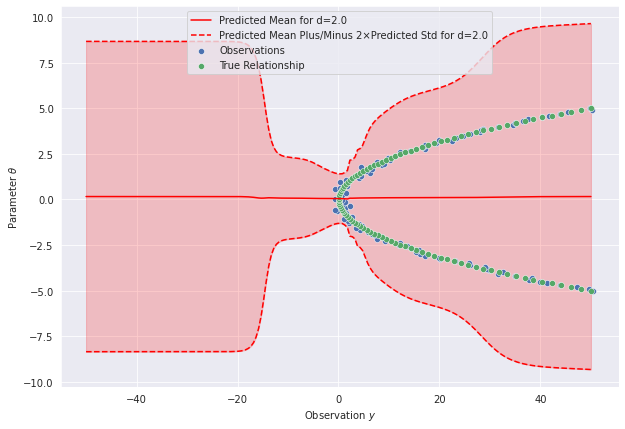

In [69]:
d_idx = 10
plot_phi_function(amortised_dist, d_idx, d=d, y_obs=y, model=model_func)

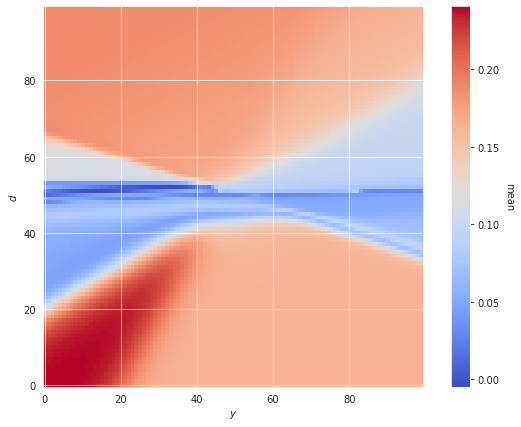

In [70]:
plot_phi_surface(amortised_dist, 'mean')

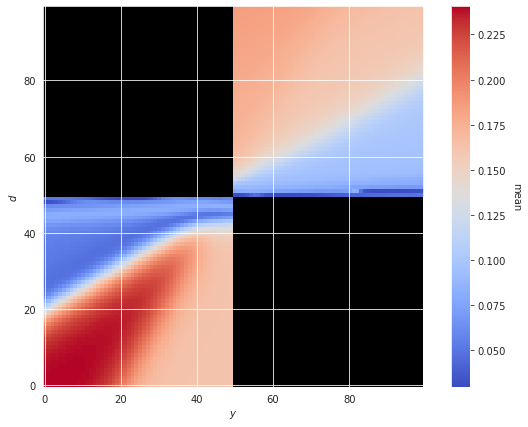

In [71]:
plot_phi_surface(amortised_dist, 'mean', apply_mask=True)

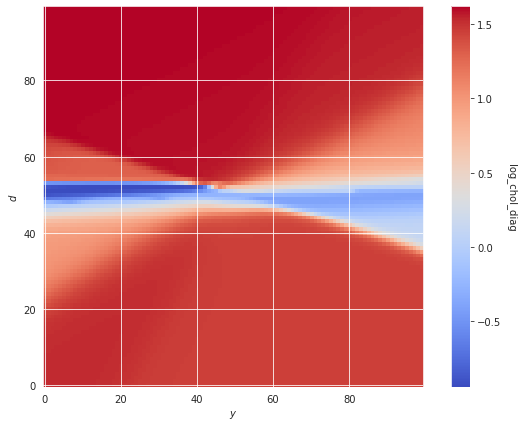

In [72]:
plot_phi_surface(amortised_dist, 'log_chol_diag')

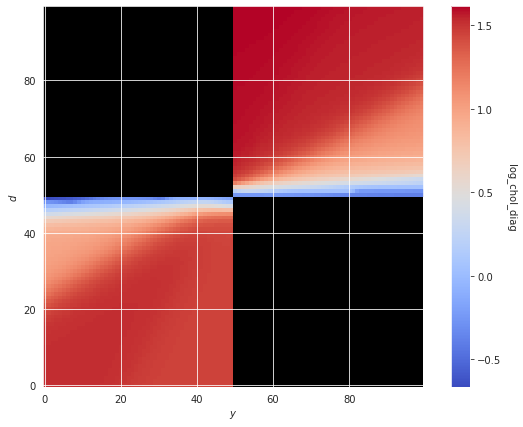

In [73]:
plot_phi_surface(amortised_dist, 'log_chol_diag', apply_mask=True)

In [62]:
sns.lineplot(x=jnp.arange(len(loss)), y=jnp.array(loss))

TypeError: object of type 'ForwardKL' has no len()